## **Χρήστος-Αλέξανδρος Δαρδαμπούνης ΑΕΜ:10335 (Τμήμα Ηλεκτρολόγων Μηχανικών & Μηχανικών Υπολογιστών)**

# Αναφορά σχετικά με την 1 $^{Η}$ Υποχρεωτική Εργασία

Το παρόν notebook περιλαμβάνει την αναφορά σχετική με την πρώτη υποχρεωτική εργασία όπου φτίαχνω ένα νευρωνικό δίκτυο για να την κατηγοροιοποίηση των εικόνων της CIFAR-10 και συγκρίνω την απόδοση του με την απόδοση που είχαν οι αλγόριθμοι πλησιέστερου γείτονα και πλησιέστερου κέντρου.


Στην παρούσα εργασία σχεδιάστηκαν και δοκιμάστηκαν αρκετά και διαφορετικά μοντέλα προκειμένου να μπορέσω να κατορθώσω να πετύχω ένα καλό ποσοστό ακρίβειας για την συγκεκριμένη βάση δεδομένων. Είναι γνωστό πως η CIFAR-10 είναι μια απαιτητική βάση με εικόνες οπότε αναμένουμε το **Multilayer Perceptron(MLP)** πάνω στα raw data να μην αποδόσει σε ικανοποιητικό βαθμό. Για αυτό τον λόγο πέρα από **MLP** θα χρησιμοποιήσω και συνελικτικό νευρωνικό δίκτυο **(CNN)** το οποίο συνίσταται για την κατηγοροποίηση εικόνων καθότι λαμβάνει καλύτερα υπόψη του την πληροφορία που περιέχει το κάθε pixel διότι "συγκεντρώνει" πληροφορία και από τους γείτονες του.

## **Μοντέλα**

Σε όλη την εργασία φτιάχνω αρκετά και διαφορετικά μοντέλα τα οποία τα σώζω και έχω επισυνάψει στην εργασία τον φάκελο με όλα αυτά που έγω θεώρησα πιο σημαντικά έτσι ώστε να μην χρειαστεί να ξαναεκτελεστεί ο κώδικας καθότι αυτό θα απαιτούσε αρκετό χρόνο.

## Εισαγωγή των απαραίτητων βιβλιοθηκών και φόρτωση της βάσης δεδομένων

Αρχικά, κάνω import όλα τα απαραίτητα libraries τα οποία θα χρειαστούν για την σύγκριση των δύο αλγορίθμων οπώς επίσης φορτώνω και την βάση δεδομένων μου σύμφωνα με τις οδηγίες που αναφέρονται στο παρακάτω link : https://www.cs.toronto.edu/~kriz/cifar.html

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
import torchvision.transforms as transforms
import pickle 
import os 
import time
from PIL import Image
from pathlib import Path
from torch import nn
from torch.nn.utils import prune
from torch.utils.data import DataLoader, TensorDataset, ConcatDataset, SubsetRandomSampler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from skimage.feature import hog
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

Οι παραπάνω βιβλιοθήκες είναι χρήσιμες για τους εξής λόγους :
* Η **numpy** για πράξεις μεταξύ πινάκων και διανυσμάτων, για αποφυγή for loops και για κατάλληλο χειρισμό των εικόνων.
* Η **matplolib** για την οπτικοποίηση των αποτελεσμάτων μας. 
* Η **opencv(cv2)** για τον διαχειρισμό των εικόνων της CIFAR-10 όπως επίσης εισάγω από την `PIL` την κλάση `Image()` για να μπορέσω να κάνω data augmentation στις εικόνες μου.
* Η **PyTorch(torch)** για την δημιουργία του νευρωνικού δικτύου και για την εκπαίδευση τους στην κάρτα γραφικών **(GPU)** για μεγαλύτερες ταχύτητες εκτέλεσης.
* Η **os** και η **pickle** για την φόρτωση των αρχείων της CIFAR-10.
* Επίσης από την **sklearn** κάνω import την κλάση `StandardScaler()` και την κλάση `PCA()` για να μειώσω τις διαστάσεις του προβλήματος μου και να βοηθήσω τους αλγόριθμους.
* Επιπλέον, εισάγω από την **skimage** την συνάρτηση `hog()` ο οποίος είναι ένας feature descriptor αλγόριθμος που μετράει τις εμφανίσεις των προσανατολισμών των gradient σε τοπικές μερίδες της εικόνας, δίνοντας έτσι χρήσιμα χαρακτηριστικά τα οποία μπορούν να χρησιμοποιηθούν αντί για ολόκληρο το set των features και άρα μπορεί να βοηθήσει στην κατηγοριοποίση των εικόνων ενώ επίσης μπορεί να επιταγχύνει σημαντικά την διαδικασία εκπαίδευσης.
* Επιπρόσθετα, από την `torch` εισάγω το module `nn` το οποίο παρέχει απαραίτητες συναρτήσεις που θα με βοηθήσουν να στήσω το νευρωνικό (είτε **MLP** είτε **CNN**). Επιπλέον, από το module `torch.nn.utils` εισάγω την κλάση `prune()` το οποίο ίσως το χρησιμοποιήσω για κλάδεμα νευρώνων στο νευρωνικό μου.
* Τέλος, από την `torch.utils.data` εισάγω το `DataLoader()` για την μετατροπή των tensors(στην προκειμένη περίπτωση το σύνολο των εικόνων) σε batches για την πιο εύκολη επεξεργασία του όγκου των δεδομένων της CIFAR-10 από το νευρωνικό. Επιπλέον εισάγω το `TensorDataset()` προκειμένου να συνδυάσω τις εικόνες με τα αντίστοιχα labels τους, το `ConcatDataset()` και το `SubsetRandomSampler()` για να συνδυάσω τα δυο sets (training & testing) και αντίστοιχα να δειγματοληπτήσω από αυτό αντίστοιχα για πιθανό cross-validation. Ακόμα εισάγω την κλάση `torchvision.transforms()` για να κάνω data augmentation στις εικόνες και να αποφύγω το πιθανό overfitting. 

## Φόρτωση της CIFAR-10 

Στο παρακάτω κομμάτι κώδικα φορτώνω όλα τα αρχεία της βάσης και τα χωρίζω σε training και testing, όπως επίσης χωρίζω και τα labels.

In [2]:
directory = r'C:\Users\chris\OneDrive\Υπολογιστής\9ο ΕΞΑΜΗΝΟ\ΝΕΥΡΩΝΙΚΑ ΔΙΚΤΥΑ & ΒΑΘΙΑ ΜΑΘΗΣΗ\cifar-10-python\cifar-10-batches-py'
data = {}
for file in os.listdir(directory):
    with open(directory + "\\" + file, 'rb') as f:
        data[f'{file}'] =  pickle.load(f, encoding='bytes')

filename = r'C:\Users\chris\OneDrive\Υπολογιστής\9ο ΕΞΑΜΗΝΟ\ΝΕΥΡΩΝΙΚΑ ΔΙΚΤΥΑ & ΒΑΘΙΑ ΜΑΘΗΣΗ\cifar-10-python\cifar-10-batches-py\test_batch'
with open(filename, 'rb') as fo:
    test_data = pickle.load(fo, encoding='bytes')


X_train = np.vstack((data['data_batch_1'][b'data'], data['data_batch_2'][b'data'], data['data_batch_3'][b'data'], data['data_batch_4'][b'data'], data['data_batch_5'][b'data']), dtype=np.uint8)
y_train = np.hstack((data['data_batch_1'][b'labels'], data['data_batch_2'][b'labels'], data['data_batch_3'][b'labels'], data['data_batch_4'][b'labels'], data['data_batch_5'][b'labels']), dtype=np.int32)
X_test = test_data[b'data']
y_test = np.array(test_data[b'labels'])
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((50000, 3072), (50000,), (10000, 3072), (10000,))

In [3]:
filename = r'C:\Users\chris\OneDrive\Υπολογιστής\9ο ΕΞΑΜΗΝΟ\ΝΕΥΡΩΝΙΚΑ ΔΙΚΤΥΑ & ΒΑΘΙΑ ΜΑΘΗΣΗ\cifar-10-python\batches.meta'
with open(filename, 'rb') as fo:
    example = pickle.load(fo, encoding='bytes')

label_names = [label_name.decode('utf-8') for label_name in example[b'label_names']] 
label_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

## Image Visualization

Στην συνέχεια για να βεβαιωθώ όταν φορτώθηκαν σωστά τα αρχεία από την CIFAR-10 σχηματίζω τις εικόνες και κάνω plot ενδεικτικά μια από αυτές.

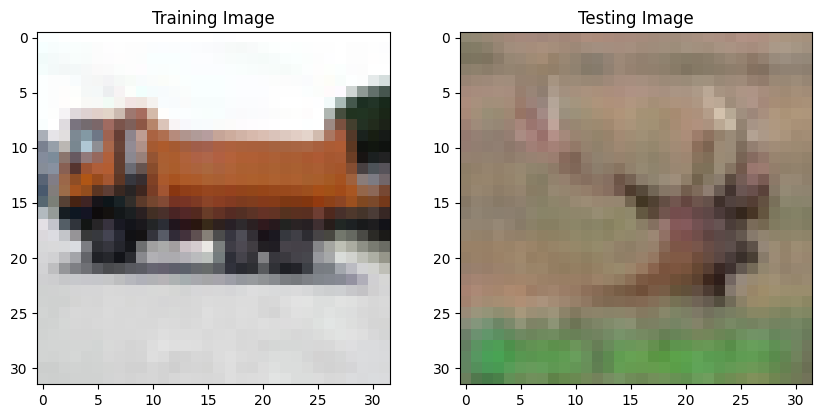

In [4]:
X = np.vstack((X_train, X_test))
img = np.zeros(shape=(32, 32, 3), dtype=np.uint8)
images = np.zeros(shape=(X.shape[0], 32, 32, 3), dtype=np.uint8)
train_images = np.zeros(shape=(X_train.shape[0], 32, 32, 3), dtype=np.uint8)
test_images = np.zeros(shape=(X_test.shape[0], 32, 32, 3), dtype=np.uint8)

for i in range(X.shape[0]):
    red_channel   = X[i, 0:1024].reshape(32, 32)
    green_channel = X[i, 1024:2048].reshape(32, 32)
    blue_channel  = X[i, 2048:3072].reshape(32, 32)

    img = np.dstack((red_channel, green_channel, blue_channel))

    images[i] = img

for i in range(X_train.shape[0]):
    red_channel   = X_train[i, 0:1024].reshape(32, 32)
    green_channel = X_train[i, 1024:2048].reshape(32, 32)
    blue_channel  = X_train[i, 2048:3072].reshape(32, 32)

    img = np.dstack((red_channel, green_channel, blue_channel))

    train_images[i] = img

for i in range(0, X_test.shape[0]):
    red_channel   = X_test[i, 0:1024].reshape(32, 32)
    green_channel = X_test[i, 1024:2048].reshape(32, 32)
    blue_channel  = X_test[i, 2048:3072].reshape(32, 32)

    img = np.dstack((red_channel, green_channel, blue_channel))
    test_images[i] = img

fig, ax = plt.subplots(1, 2, figsize=(10, 8))
ax[0].imshow(train_images[28635])
ax[0].set_title('Training Image')
ax[1].imshow(test_images[2183])
ax[1].set_title('Testing Image')
plt.show()

## ΗΟG Features combined with PCA

Στην ενδιάμεση εργασία είχα καταλήξει στο γεγονός πως τα features που εξήγαγα από την κάθε εικόνα μου έδιναν τα καλύτερα αποτέλεσμα και για τον αλγόριθμο πλησιέστερου γείτονα αλλά και για τον αλγόριθμου πλησιέστερου κέντρου, οπότε για αυτό τον λόγο θεωρώ λογικό να φτιάξω αρχικά ένα νευρωνικό προσαρμοσμένο σε αυτά καθότι αναμένω πως και αυτό θα μου δώσει αρκετά καλά αποτελέσματα. Οπότε, όπως και προηγουμένως κάνω εξαγωγή αυτών των features και στην συνέχεια δημιουργώ την κλάση για το νευρωνικό. 

In [5]:
def compute_hog_features(image):
    hog_features, hog_image = hog(image, pixels_per_cell=(8, 8),
                                  cells_per_block=(2, 2), visualize=True, channel_axis=-1, transform_sqrt=True)
    return hog_features

X_train_HOG = np.zeros(shape=(train_images.shape[0], 324))
X_test_HOG  = np.zeros(shape=(test_images.shape[0], 324))

for i in range(train_images.shape[0]):
    X_train_HOG[i, :] = compute_hog_features(train_images[i])

for i in range(test_images.shape[0]):
    X_test_HOG[i, :] = compute_hog_features(test_images[i])

X_train_HOG.shape, X_test_HOG.shape

((50000, 324), (10000, 324))

In [6]:
pca = PCA(n_components=100) 
sc = StandardScaler()

X_train_HOG_scaled = sc.fit_transform(X_train_HOG)
X_test_HOG_scaled = sc.transform(X_test_HOG)
X_train_HOG_pca = pca.fit_transform(X_train_HOG_scaled)
X_test_HOG_pca = pca.transform(X_test_HOG_scaled)

combined_train = np.hstack((X_train_HOG_scaled, X_train_HOG_pca))
combined_test = np.hstack((X_test_HOG_scaled, X_test_HOG_pca))
combined_test.shape, combined_train.shape

((10000, 424), (50000, 424))

In [5]:
# Building a Neural Network
class CIFARClassifierRELU(nn.Module):

    def __init__(self, in_features, out_features, hidden_units=800):
        super().__init__()
        self.layer = nn.Sequential(
            nn.Linear(in_features=in_features, out_features=hidden_units), # here I create u = w^T*x + b
            nn.ReLU(), # y = φ(u)
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=out_features)
        )

    def forward(self, x):
        return self.layer(x)

Το παραπάνω νευρωνικό δίκτυο αποτελείται 3 hidden layers και από ένα layer εξόδου το οποίο θα έχει σίγουρα 10 εξόδους, όπως δηλαδή και το πλήθος των κλάσεων. Για συνάρτηση ενεργοποίησης επιλέχθηκε η ReLU της οποίας η γραφική παράσταση φαίνεται παρακάτω. Ο λόγος για τον οποίο επιλέχθηκε είναι διότι εισάγει μια μη γραμμικότητα στην όλη υλοποίηση του νευρωνικού, γεγονός που είναι απαραίτητο καθότι τα δεδομένα μας δεν είναι μεταξύ τους γραμμικά διαχωρίσιμα. Μια άλλη συνάρτηση που θα μπορούσε να χρησιμοποιηθεί είναι η σιγμοειδής το οποίο το δοκιμάζω στην συνέχεια για να συγκρίνω την απόδοση. Παρακάτω, υλοποιώ επίσης και μια συνάρτηση για να μπορέσω να τυπώσω την ακρίβεια που έχει το νευρωνικό μου στο training καθώς και στο test set για κάθε epoch.

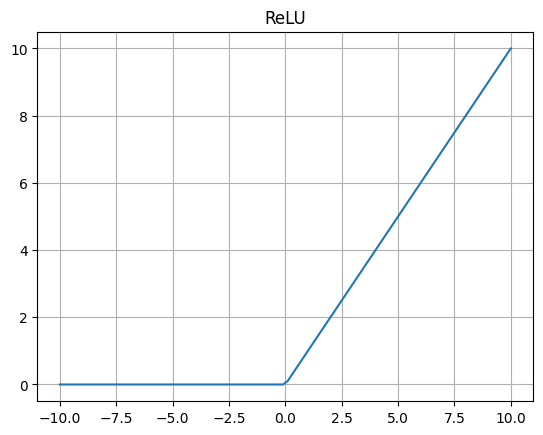

In [8]:
def plot_ReLU(x:np.array):
    y = np.maximum(0, x)
    plt.plot(x, y)
    plt.title("ReLU")
    plt.grid(True)
    plt.show()

x = np.linspace(-10, 10, 100)
plot_ReLU(x)

In [6]:
def accuracy_score(y_true:torch.Tensor, y_pred:torch.Tensor):
    correct = torch.eq(y_true, y_pred).sum().item()
    accuracy = correct / len(y_pred) * 100

    return accuracy

Στην συνέχεια δημιουργώ την μεταβλητή `device` η οποία θα καθορίζει που θα εκπαιδεύεται και που θα τεστάρεται το νευρωνικό μου δίκτυο(όπως έκανα δηλαδή και στην ενδιάμεση εργασία για να επιταγχύνω την ταξινόμηση των εικόνων στις κλάσεις).

In [7]:
# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

Επίσης, υλοποιώ και μια συνάρτηση για να αποθηκεύω κάθε φορά το μοντέλο που φτιάχνω έτσι ώστε να μην απαιτείται κάθε φορά η εκτέλεση του ίδιου κελιού κώδικα(γεγονός που θα είναι σίγουρα χρονοβόρο αφού πρόκειται για την εκπαίδευση του νευρωνικού). Επίσης υλοποιώ και την αντίστοιχη συνάρτηση για να φορτώσω το μοντέλο και να μπορώ να το χρησιμοποιήσω. 

In [8]:
def save_model(model, save_name:str):
    # Creating the models directory 
    MODEL_PATH = Path('my_models')
    MODEL_PATH.mkdir(parents=True, exist_ok=True)

    # Creating the models save path
    MODEL_NAME = save_name
    MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
    
    # Saving the model.state_dict()
    torch.save(obj=model.state_dict(), f=MODEL_SAVE_PATH)
    print('Model Saved Successfully')


def load_model(model, MODEL_SAVE_PATH):
    model.load_state_dict(torch.load(MODEL_SAVE_PATH, weights_only=True))
    model.to(device)
    return model

Τέλος, επιλέγω την κατάλληλη `loss function`, που για την ταξινόμηση πολλαπλών κλάσεων, είναι η `CrossEntropyLoss()` η οποία χρησιμοποιεί την `Softmax()` για την μετατροπή των **raw outputs** σε πιθανότητες(εξαιτίας της μορφής της `Softmax()` **$\text{softmax}(x_i) = \frac{e^{x_i}}{\sum_{j=1}^N e^{x_j}}$** ) και τον κατάλληλο `optimizer`, που σε αυτή την περίπτωση θα χρησιμοποιήσω την μέθοδο του **Stochastic Gradient Descent** .

In [12]:
model_relu = CIFARClassifierRELU(in_features=combined_train.shape[1], out_features=10, hidden_units=1000).to(device)

# Defining a loss function
# For multiclass classification problem we need the CrossEntropyLoss()
loss_fn = nn.CrossEntropyLoss()

# Defining an optimizer 
# I will use the Stochastic Gradient Descent optimizer
optimizer = torch.optim.SGD(params=model_relu.parameters(), lr=0.05, momentum=0.75)

Για να μην είναι τελείως τυχαία η επιλογή των βαρών βάζω ένα συγκεκριμένο seed προκειμένου να λαμβάνω το ίδιο αποτέλεσμα κάθε φορά που εκπαιδεύω το συγκεκριμένο μοντέλο.

In [ ]:
combined_train_tensor = torch.from_numpy(combined_train).to(device).type(torch.float32)
combined_test_tensor  = torch.from_numpy(combined_test).to(device).type(torch.float32)

In [9]:
y_train_tensor = torch.from_numpy(y_train).to(device).type(torch.long)
y_test_tensor  = torch.from_numpy(y_test).to(device).type(torch.long)

## Υλοποίηση Training & Testing Loop
Παρακάτω φαίνεται ο κώδικας για τον οποίο υλοποιώ το training και το testing loop για να εκπαιδεύσω το νευρωνικό. Η σειρά με την οποία πραγματοποιώ την εκπαίδευση είναι αρκετά τυποποιημένη και προτείνεται και από το documentation της PyTorch. Αρχικά, πραγματοποιώ το πάντοτε το `forward pass`. Στην συνέχεια υπολογίζω τις απώλειες του νευρωνικού με την συνάρτηση απωλειών που έχω επιλέξει. Κατόπιν, η PyTorch συσσωρεύει τα gradients μεταξύ των διάφορων epochs, κάτι που εμείς δεν θέλουμε για την εκπαίδευσή μας οπότε τα μηδενίζω καλόντας την `optimizer.zero_grad()`. Έπειτα, πραγματοποιώ την τεχνική του **backpropagation** στέλνοντας το σφάλμα πίσω σε όλα τα layers και σε όλους τους νευρώνες με την κλήση της μεθόδου `loss.backward()`. Τέλος, με την κλήση `optimizer.step()` ενημερώνω όλες τις παραμέτρους του νευρωνικού μου.

Για το κομμάτι του testing βάζω το μοντέλο σε **evaluation mode** κάτι το οποίο έχει ως αποτέλεσμα να μην υπολογίζει τις παραγώγους και τα gradients κατά την διάρκεια του testing(αφού όντως δεν τα χρειάζομαι αυτά καθότι σε αυτό το στάδιο δεν εκπαιδεύω το νευρωνικό), πράγμα που επιταγχύνει την διαδικασία του testing.

In [14]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
start = time.time()
# Setting number of epochs
epochs = 201
epoch_count = []
loss_values = []
test_loss_values = []
acc_values = []
test_acc_values = []

for epoch in range(epochs):
    model_relu.train()

    # Forward Pass
    y_logits = model_relu(combined_train_tensor)
    y_pred_probs = torch.softmax(y_logits, dim=1)
    y_predictions = torch.argmax(y_pred_probs, dim=1)

    # Calculate the loss and accuracy
    loss = loss_fn(y_logits, y_train_tensor)
    accuracy = accuracy_score(y_true=y_train_tensor, y_pred=y_predictions)

    # Zero the gradients
    optimizer.zero_grad()

    # Back propagate the loss
    loss.backward()

    # Step the optimizer
    optimizer.step()

    ### Testing
    model_relu.eval()
    with torch.inference_mode():
        test_logits = model_relu(combined_test_tensor)
        test_pred_probs = torch.softmax(test_logits, dim=1)
        test_predictions = torch.argmax(test_pred_probs, dim=1)

        test_loss = loss_fn(test_logits, y_test_tensor)
        test_accuracy = accuracy_score(y_true=y_test_tensor, y_pred=test_predictions)

    if epoch % 10 == 0:
        epoch_count.append(epoch)
        loss_values.append(loss.item())
        test_loss_values.append(test_loss.item())
        acc_values.append(accuracy)
        test_acc_values.append(test_accuracy)
        print(f"Epoch {epoch} | Loss : {loss:.5f} | Accuracy : {accuracy:.2f}% | Test Loss : {test_loss:.5f} | Test Accuracy : {test_accuracy:.2f}%")

end = time.time()

print(f'Total Execution time : {end-start:.3f} seconds')


Epoch 0 | Loss : 2.30124 | Accuracy : 10.43% | Test Loss : 2.29907 | Test Accuracy : 10.49%
Epoch 10 | Loss : 2.23129 | Accuracy : 19.43% | Test Loss : 2.21886 | Test Accuracy : 20.57%
Epoch 20 | Loss : 2.03999 | Accuracy : 29.12% | Test Loss : 2.01423 | Test Accuracy : 29.79%
Epoch 30 | Loss : 1.85761 | Accuracy : 39.30% | Test Loss : 1.83925 | Test Accuracy : 39.18%
Epoch 40 | Loss : 1.69316 | Accuracy : 43.78% | Test Loss : 1.67804 | Test Accuracy : 42.95%
Epoch 50 | Loss : 1.54727 | Accuracy : 47.01% | Test Loss : 1.54135 | Test Accuracy : 46.42%
Epoch 60 | Loss : 1.45048 | Accuracy : 49.69% | Test Loss : 1.45262 | Test Accuracy : 49.04%
Epoch 70 | Loss : 1.38647 | Accuracy : 51.76% | Test Loss : 1.39545 | Test Accuracy : 50.89%
Epoch 80 | Loss : 1.33733 | Accuracy : 53.53% | Test Loss : 1.35250 | Test Accuracy : 52.91%
Epoch 90 | Loss : 1.29621 | Accuracy : 55.03% | Test Loss : 1.31720 | Test Accuracy : 54.14%
Epoch 100 | Loss : 1.26085 | Accuracy : 56.25% | Test Loss : 1.28747 | 

Μετά από αρκετές δοκιμές και δοκιμάζοντας να αλλάξω τις υπερ-παραμέτρους(learning rate και momentum) κατέληξα πως αυτές είναι οι βέλτιστες και μου δίνουν τα καλύτερα αποτέσματα. Παρατηρούμε πως ήδη έχουμε πολύ καλύτερα αποτελέσματα από τους αλγορίθμους πλησιέστερου κέντρου και πλησιέστερου γείτονα, κάτι που ήταν αναμενόμενο καθότι ο αλγόριθμος που υλοποιήσαμε είναι πιο σύνθετος και αντιμετωπίζει καλύτερα τις μη γραμμικότητες του διαχωρισμού των δεδομένων στις διάφορες κλάσεις.

Στην συνέχεια σχεδιάζω τα γραφήματα των απωλειών για το training και για το test set και σώζω το μοντέλο που έφτιαξα.

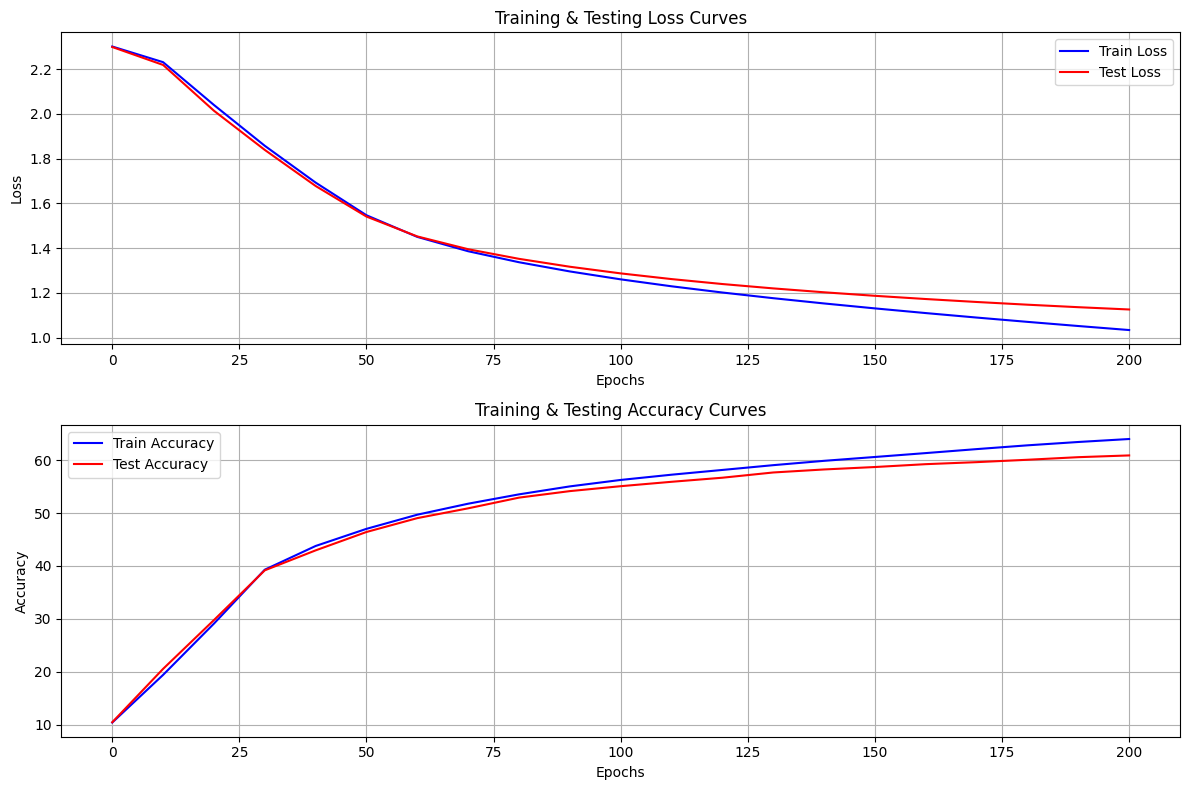

Model Saved Successfully


In [15]:
def plot_loss_acc_curves(epoch_count, loss_values, test_loss_values, acc_values, test_acc_values):
    plt.figure(figsize=(12, 8))

    ax1 = plt.subplot(211)
    ax2 = plt.subplot(212)
    ax1.plot(epoch_count, loss_values, label='Train Loss', color='blue')
    ax1.plot(epoch_count, test_loss_values, label='Test Loss', color='red')
    ax1.set_title("Training & Testing Loss Curves")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend()
    ax1.grid(True)


    ax2.plot(epoch_count, acc_values, label='Train Accuracy', color='blue')
    ax2.plot(epoch_count, test_acc_values, label='Test Accuracy', color='red')
    ax2.set_title("Training & Testing Accuracy Curves")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()


plot_loss_acc_curves(epoch_count=epoch_count, loss_values=loss_values, test_loss_values=test_loss_values, acc_values=acc_values, test_acc_values=test_acc_values)
save_model(model_relu, "hog_relu_model.pth")

Στην συνέχεια δοκιμάζω να βάλω για συνάρτηση ενεργοποίησης την σιγμοειδή.

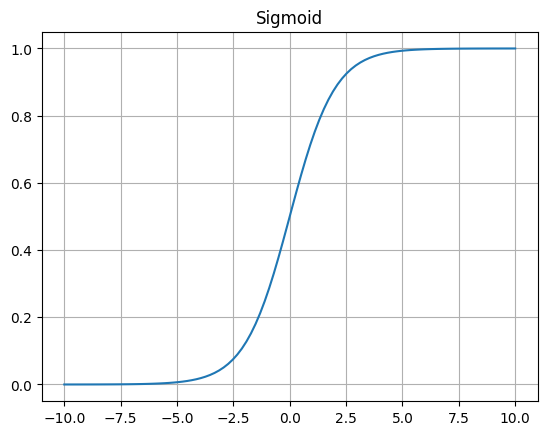

In [16]:
def plot_Sigmoid(x:np.array):
    y = 1 / (1 + np.exp(-x))
    plt.plot(x, y)
    plt.title('Sigmoid')
    plt.grid(True)
    plt.show()

x = np.linspace(-10, 10, 100)
plot_Sigmoid(x)

In [11]:
# Building a Neural Network
class CIFARClassifierSigmoid(nn.Module):

    def __init__(self, in_features, out_features, hidden_units=800):
        super().__init__()
        self.layer = nn.Sequential(
            nn.Linear(in_features=in_features, out_features=hidden_units), # here I create u = w^T*x + b
            nn.Sigmoid(), # y = φ(u)
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.Sigmoid(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.Sigmoid(),
            nn.Linear(in_features=hidden_units, out_features=out_features)
        )

    def forward(self, x):
        return self.layer(x)

Επίσης αντί να ορίζω κάθε φορά την συνάρτηση σφάλματος και τον optimizer, τα βάζω σε μια συνάρτηση. Επιπλέον σε αυτή την συνάρτηση βάζω και scheduler ο οποίος θα είναι υπεύθυνος για να μου δημιουργήσει μεταβλητό learning rate που θα αλλάζει ανά συγκεκριμένο αριθμό εποχών. Ωστόσο, στην παρούσα φάση δεν θα το χρησιμοποιήσω, οπότε θα το αρχικοποιήσω με `None` .

In [12]:
def loss_optimizer(model, lr=0.001, momentum=0.7, scheduler_on=False, Adam=False):
    loss_fn = nn.CrossEntropyLoss()

    if Adam:
        optimizer = torch.optim.Adam(params=model.parameters(), lr=lr, eps=1e-8, weight_decay=1e-4)
    else:
        optimizer = torch.optim.SGD(params=model.parameters(), lr=lr, momentum=momentum)

    if not scheduler_on:
        scheduler = None
    else:
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
        gamma=0.5, # the amount of reduction of our learning rate
        step_size=15, # how often the learning rate will change(every 7 epochs)
        )

    return loss_fn, optimizer, scheduler

In [ ]:
model_sigmoid = CIFARClassifierSigmoid(in_features=combined_train_tensor.shape[1], out_features=10, hidden_units=1000).to(device)

loss_fn, optimizer, scheduler = loss_optimizer(model_sigmoid, lr=0.01, momentum=0.9, scheduler_on=False, Adam=False)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 201
epoch_count = []
loss_values = []
test_loss_values = []
acc_values = []
test_acc_values = []

start = time.time()
for epoch in range(epochs):
    model_sigmoid.train()

    # Forward Pass
    y_logits = model_sigmoid(combined_train_tensor)
    y_pred_probs = torch.softmax(y_logits, dim=1)
    y_predictions = torch.argmax(y_pred_probs, dim=1)

    # Calculate the loss and accuracy
    loss = loss_fn(y_logits, y_train_tensor)
    accuracy = accuracy_score(y_true=y_train_tensor, y_pred=y_predictions)

    # Zero the gradients
    optimizer.zero_grad()

    # Back propagate the loss
    loss.backward()

    # Step the optimizer
    optimizer.step()

    ### Testing
    model_sigmoid.eval()
    with torch.inference_mode():
        test_logits = model_sigmoid(combined_test_tensor)
        test_pred_probs = torch.softmax(test_logits, dim=1)
        test_predictions = torch.argmax(test_pred_probs, dim=1)

        test_loss = loss_fn(test_logits, y_test_tensor)
        test_accuracy = accuracy_score(y_true=y_test_tensor, y_pred=test_predictions)

    if epoch % 10 == 0:
        epoch_count.append(epoch)
        loss_values.append(loss.item())
        test_loss_values.append(test_loss.item())
        acc_values.append(accuracy)
        test_acc_values.append(test_accuracy)
        print(f"Epoch {epoch} | Loss : {loss:.5f} | Accuracy : {accuracy:.2f}% | Test Loss : {test_loss:.5f} | Test Accuracy : {test_accuracy:.2f}%")

end = time.time()

print(f'Total Execution time : {end-start:.3f} seconds')

Epoch 0 | Loss : 2.33179 | Accuracy : 10.00% | Test Loss : 2.31983 | Test Accuracy : 10.00%
Epoch 10 | Loss : 2.30683 | Accuracy : 10.00% | Test Loss : 2.31078 | Test Accuracy : 10.00%
Epoch 20 | Loss : 2.30306 | Accuracy : 10.00% | Test Loss : 2.30263 | Test Accuracy : 9.91%
Epoch 30 | Loss : 2.30360 | Accuracy : 10.00% | Test Loss : 2.30304 | Test Accuracy : 10.00%
Epoch 40 | Loss : 2.30232 | Accuracy : 10.00% | Test Loss : 2.30247 | Test Accuracy : 10.00%
Epoch 50 | Loss : 2.30194 | Accuracy : 13.59% | Test Loss : 2.30191 | Test Accuracy : 11.11%
Epoch 60 | Loss : 2.30175 | Accuracy : 11.78% | Test Loss : 2.30171 | Test Accuracy : 13.80%
Epoch 70 | Loss : 2.30148 | Accuracy : 16.89% | Test Loss : 2.30147 | Test Accuracy : 15.96%
Epoch 80 | Loss : 2.30125 | Accuracy : 19.29% | Test Loss : 2.30122 | Test Accuracy : 21.33%
Epoch 90 | Loss : 2.30102 | Accuracy : 18.06% | Test Loss : 2.30099 | Test Accuracy : 19.55%
Epoch 100 | Loss : 2.30078 | Accuracy : 22.42% | Test Loss : 2.30076 | T

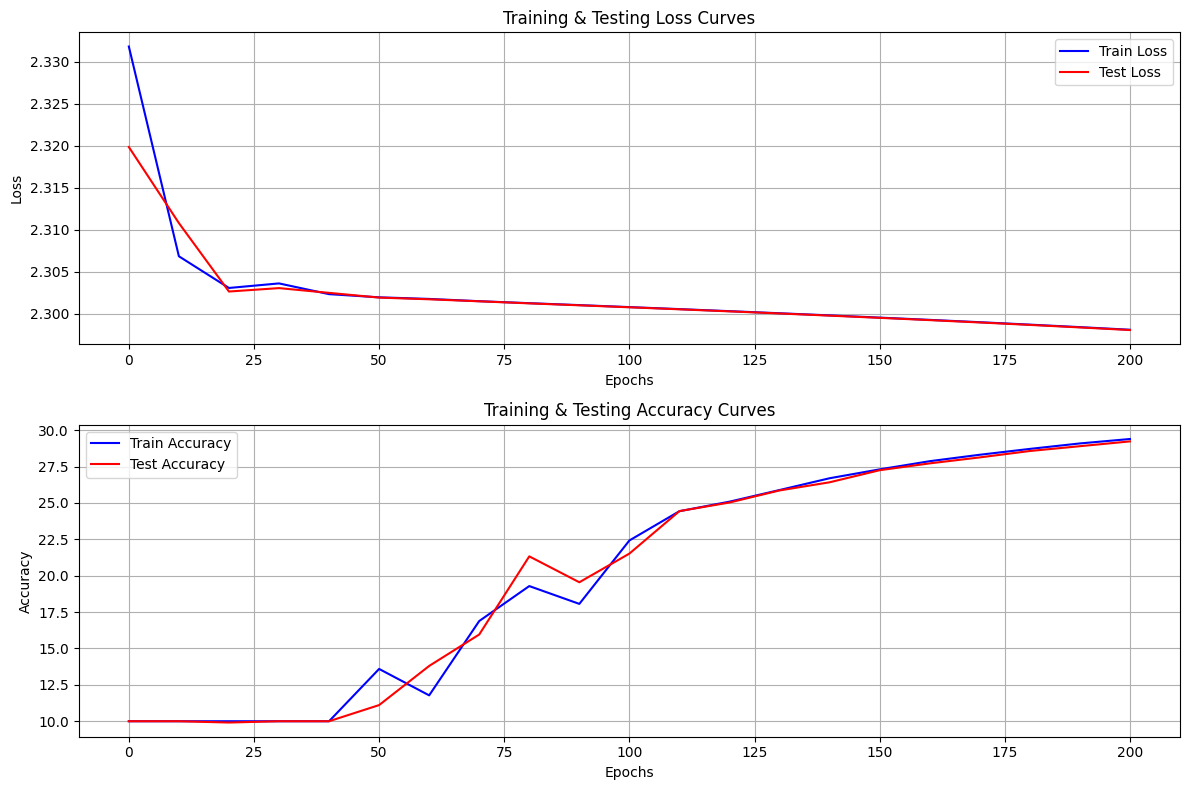

In [20]:
plot_loss_acc_curves(epoch_count, loss_values, test_loss_values, acc_values, test_acc_values)

Παρατηρώ πως τα αποτελέσματα με την χρήση της σιγμοειδούς δεν είναι ικανοποιητικά και δεν πλησιάζουν σε ακρίβεια ούτε τα αποτελέσματα που βγάλαμε με τους αλγορίθμους πλησιέστερου γείτονα και πλησιέστερου κέντρου. Για αυτό τον λόγο θα κάνω μια τροποποίηση στην κλάση με το νευρωνικό μου. Μετά από κάθε layer θα εισάγω ένα batch normalisation το οποίο θα βοηθήσει σημαντικά στο training και θα το κάνει πιο γρήγορο καθώς εξασφαλίζει ότι το νευρωνικό δεν θα κολλήσει σε κάποιο κρίσιμο σημείο. Ουσιαστικά, αυτό που κάνει είναι να μετατρέψει το αποτέλεσμα της εξόδου της συνάρτησης ενεργοποίησης σε δείγματα με μέση τιμή το 0 και τυπική απόκλιση ίση με 1 κανονικοποιώντας με αυτό τον τρόπο τα αποτελέσματα που βγάζει η έξοδος της συνάρτησης ενεργοποίησης βοηθώντας με αυτό τον τρόπο το νευρωνικό δίκτυο στο να μάθει.

In [13]:
# Building a Neural Network
class CIFARClassifierSigmoidV2(nn.Module):

    def __init__(self, in_features, out_features, hidden_units=800):
        super().__init__()
        self.layer = nn.Sequential(
            nn.Linear(in_features=in_features, out_features=hidden_units), # here I create u = w^T*x + b
            nn.Sigmoid(), # y = φ(u)
            nn.BatchNorm1d(num_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.Sigmoid(),
            nn.BatchNorm1d(num_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.Sigmoid(),
            nn.BatchNorm1d(num_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=out_features)
        )

    def forward(self, x):
        return self.layer(x)

In [ ]:
model_sigmoid_v2 = CIFARClassifierSigmoidV2(in_features=combined_train_tensor.shape[1], out_features=10, hidden_units=1000).to(device)

loss_fn, optimizer, scheduler = loss_optimizer(model_sigmoid_v2, lr=0.01, momentum=0.9, scheduler_on=False, Adam=False)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 201
epoch_count = []
loss_values = []
test_loss_values = []
acc_values = []
test_acc_values = []

start = time.time()
for epoch in range(epochs):
    model_sigmoid_v2.train()

    # Forward Pass
    y_logits = model_sigmoid_v2(combined_train_tensor)
    y_pred_probs = torch.softmax(y_logits, dim=1)
    y_predictions = torch.argmax(y_pred_probs, dim=1)

    # Calculate the loss and accuracy
    loss = loss_fn(y_logits, y_train_tensor)
    accuracy = accuracy_score(y_true=y_train_tensor, y_pred=y_predictions)

    # Zero the gradients
    optimizer.zero_grad()

    # Back propagate the loss
    loss.backward()

    # Step the optimizer
    optimizer.step()

    ### Testing
    model_sigmoid_v2.eval()
    with torch.inference_mode():
        test_logits = model_sigmoid_v2(combined_test_tensor)
        test_pred_probs = torch.softmax(test_logits, dim=1)
        test_predictions = torch.argmax(test_pred_probs, dim=1)

        test_loss = loss_fn(test_logits, y_test_tensor)
        test_accuracy = accuracy_score(y_true=y_test_tensor, y_pred=test_predictions)

    if epoch % 10 == 0:
        epoch_count.append(epoch)
        loss_values.append(loss.item())
        test_loss_values.append(test_loss.item())
        acc_values.append(accuracy)
        test_acc_values.append(test_accuracy)
        print(f"Epoch {epoch} | Loss : {loss:.5f} | Accuracy : {accuracy:.2f}% | Test Loss : {test_loss:.5f} | Test Accuracy : {test_accuracy:.2f}%")

end = time.time()

print(f'Total Execution time : {end-start:.3f} seconds')

Epoch 0 | Loss : 2.51110 | Accuracy : 7.77% | Test Loss : 2.32837 | Test Accuracy : 10.00%
Epoch 10 | Loss : 1.53272 | Accuracy : 48.29% | Test Loss : 2.26033 | Test Accuracy : 16.99%
Epoch 20 | Loss : 1.42554 | Accuracy : 51.39% | Test Loss : 2.12029 | Test Accuracy : 40.29%
Epoch 30 | Loss : 1.37694 | Accuracy : 52.91% | Test Loss : 1.81824 | Test Accuracy : 51.00%
Epoch 40 | Loss : 1.35486 | Accuracy : 53.83% | Test Loss : 1.52274 | Test Accuracy : 52.45%
Epoch 50 | Loss : 1.34064 | Accuracy : 54.36% | Test Loss : 1.39396 | Test Accuracy : 53.20%
Epoch 60 | Loss : 1.33001 | Accuracy : 54.73% | Test Loss : 1.36478 | Test Accuracy : 53.32%
Epoch 70 | Loss : 1.32112 | Accuracy : 54.99% | Test Loss : 1.35422 | Test Accuracy : 53.59%
Epoch 80 | Loss : 1.31324 | Accuracy : 55.31% | Test Loss : 1.34710 | Test Accuracy : 53.52%
Epoch 90 | Loss : 1.30601 | Accuracy : 55.50% | Test Loss : 1.34143 | Test Accuracy : 53.75%
Epoch 100 | Loss : 1.29922 | Accuracy : 55.76% | Test Loss : 1.33626 | T

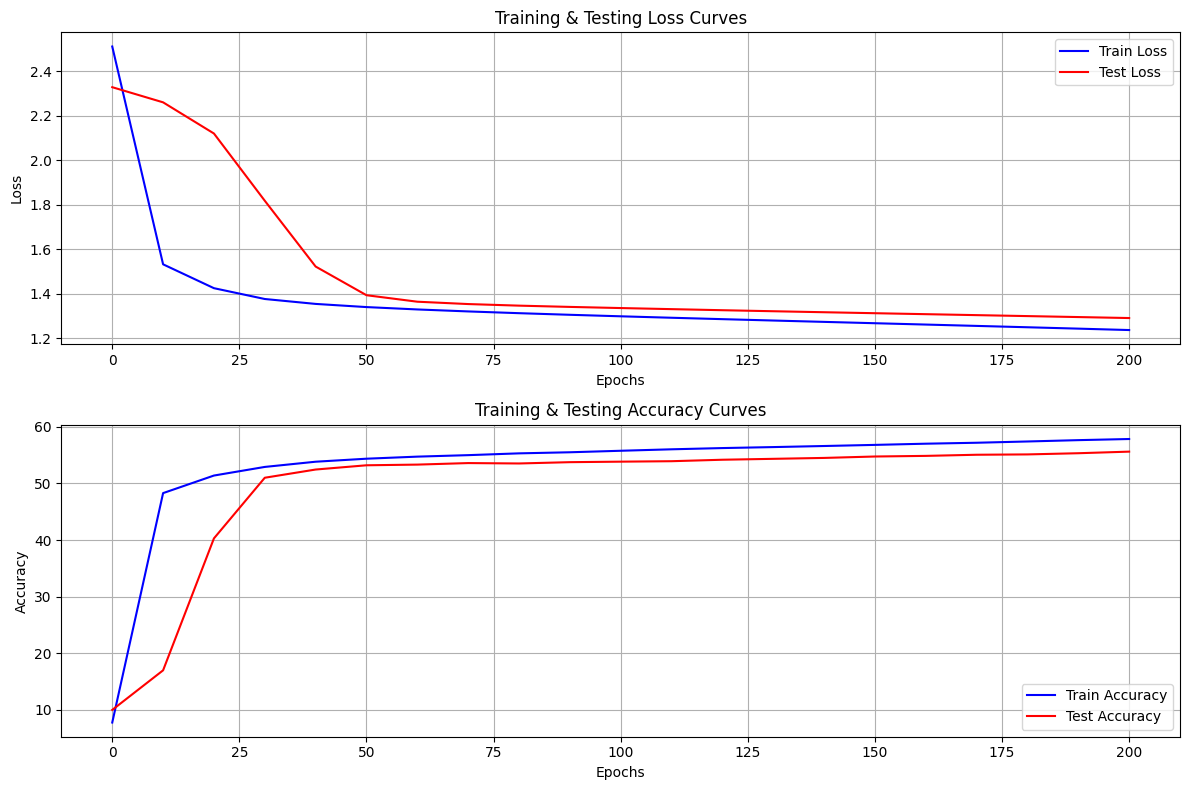

Model Saved Successfully


In [23]:
plot_loss_acc_curves(epoch_count, loss_values, test_loss_values, acc_values, test_acc_values)
save_model(model_sigmoid_v2, "hog_sigmoid_model.pth")

Όπως βλέπουμε τώρα τα αποτελέσματα είναι πολύ καλύτερα από προηγουμένως, γεγονός που σημαίνει ότι όντως βοήθησε η κανονικοποίηση που κάναμε μετά από κάθε hidden layer και μας έδωσε πολύ καλά αποτελέσματα, καλύτερα από ότι πήραμε από τον αλγόριθμο πλησιέστερου γείτονα και από τον αλγόριθμο πλησιέστερου κέντρου. Ωστόσο, αυτή η υλοποίηση δεν έδωσε τόσα καλά αποτελέσματα όπως η προηγούμενη στην οποία χρησιμοποιήσαμε για μη γραμμικότητα την συνάρτηση ενεργοποίησης ReLU. Αυτό οφείλεται στο γεγονός ότι η ReLU δεν οδηγεί σε κορεσμό τις θετικές τιμές, σε αντίθεση με την σιγμοειδή που τις περιορίζει στο διάστημα (0,1), εξασφαλίζοντας με αυτό τον τρόπο πως η επίδραση των gradients θα παραμείνει σημαντική και το νευρωνικό θα μπορέσει να μάθει αποτελεσματικά ενώ επίσης λόγω του γεγονότος ότι μηδενίζεται στα αρνητικά βοηθάει στο να μειώσει τις εξαρτήσεις μεταξύ των νευρώνων και άρα στο να μάθει πιο εύκολα και πιο γρήγορα το νευρωνικό. Επίσης, παρατηρώντας και την μορφή που έχει η παράγωγος της σιγμοειδούς, μπορούμε να συμπεράνουμε πως στο back propagation η συνεισφορά θα είναι ελάχιστη και άρα πρακτικά το νευρωνικό μας δεν θα μαθαίνει(**vanishing gradients**).

Από τα παραπάνω παρατηρούμε πως τα HOG features απέδωσαν και εδώ πολύ καλά με αυτή την πολύ απλή υλοποίηση του νευρωνικού δικτύου. Ας δοκιμάσουμε τώρα να εκπαιδεύσουμε το νευρωνικό με τα δεδομένα ακριβώς όπως τα παίρνουμε από την CIFAR-10 για να δούμε την απόδοση του και να την συγκρίνουμε με αυτή των αλγορίθμων της ενδιάμεσης εργασίας.

In [14]:
X_train_tensor = torch.from_numpy(X_train).to(device).type(torch.float32)
X_test_tensor  = torch.from_numpy(X_test).to(device).type(torch.float32)
X_train_tensor.size(), X_test_tensor.size()

(torch.Size([50000, 3072]), torch.Size([10000, 3072]))

Είδαμε προηγουμένως ότι το μοντέλο με την **ReLU** απέδωσε καλύτερα. Συνεπώς, θα χρησιμοποιήσουμε και εδώ το **ReLU** για την ταξινόμηση των εικόνων στις κατάλληλες κλάσεις.

In [ ]:
model_MLP = CIFARClassifierRELU(in_features=X_train_tensor.shape[1], out_features=10, hidden_units=1500).to(device)

loss_fn, optimizer, scheduler = loss_optimizer(model=model_MLP, lr=0.001, momentum=0.7, scheduler_on=False, Adam=False)
epochs = 201
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epoch_count = []
loss_values = []
test_loss_values = []
acc_values = []
test_acc_values = []
start = time.time()
for epoch in range(epochs):
    ### Training
    model_MLP.train()

    # Forward Pass
    y_logits = model_MLP(X_train_tensor)
    y_preds  = torch.softmax(y_logits, dim=1).argmax(dim=1)

    # Calculate the Loss and Accuracy
    loss = loss_fn(y_logits, y_train_tensor)
    accuracy = accuracy_score(y_true=y_train_tensor, y_pred=y_preds)

    # Zero the gradients
    optimizer.zero_grad()

    # Loss Backward
    loss.backward()

    # Optimizer Step
    optimizer.step()

    ### Testing
    model_MLP.eval()
    with torch.inference_mode():
        test_logits = model_MLP(X_test_tensor)
        test_preds  = torch.softmax(test_logits, dim=1).argmax(dim=1)

        test_loss = loss_fn(test_logits, y_test_tensor)
        test_accuracy = accuracy_score(y_true=y_test_tensor, y_pred=test_preds)

    if epoch % 10 == 0:
        epoch_count.append(epoch)
        loss_values.append(loss.item())
        test_loss_values.append(test_loss.item())
        acc_values.append(accuracy)
        test_acc_values.append(test_accuracy)
        print(f"Epoch {epoch} | Loss : {loss:.5f} | Accuracy : {accuracy:.2f}% | Test Loss : {test_loss:.5f} | Test Accuracy : {test_accuracy:.2f}%")

end = time.time()

print(f'Total Execution time : {end-start:.3f} seconds')

Epoch 0 | Loss : 10.52689 | Accuracy : 10.17% | Test Loss : 37.02080 | Test Accuracy : 10.90%
Epoch 10 | Loss : 3.60423 | Accuracy : 13.43% | Test Loss : 3.09756 | Test Accuracy : 10.30%
Epoch 20 | Loss : 2.12534 | Accuracy : 21.53% | Test Loss : 2.10484 | Test Accuracy : 23.14%
Epoch 30 | Loss : 1.98721 | Accuracy : 27.92% | Test Loss : 1.97909 | Test Accuracy : 28.98%
Epoch 40 | Loss : 1.97685 | Accuracy : 28.51% | Test Loss : 1.95538 | Test Accuracy : 30.32%
Epoch 50 | Loss : 1.88822 | Accuracy : 32.30% | Test Loss : 1.88437 | Test Accuracy : 32.85%
Epoch 60 | Loss : 1.84809 | Accuracy : 34.31% | Test Loss : 1.84573 | Test Accuracy : 34.31%
Epoch 70 | Loss : 1.81965 | Accuracy : 35.20% | Test Loss : 1.82169 | Test Accuracy : 35.74%
Epoch 80 | Loss : 1.80646 | Accuracy : 36.34% | Test Loss : 1.79788 | Test Accuracy : 36.64%
Epoch 90 | Loss : 1.76960 | Accuracy : 37.50% | Test Loss : 1.77123 | Test Accuracy : 37.07%
Epoch 100 | Loss : 1.81668 | Accuracy : 36.17% | Test Loss : 1.77709 

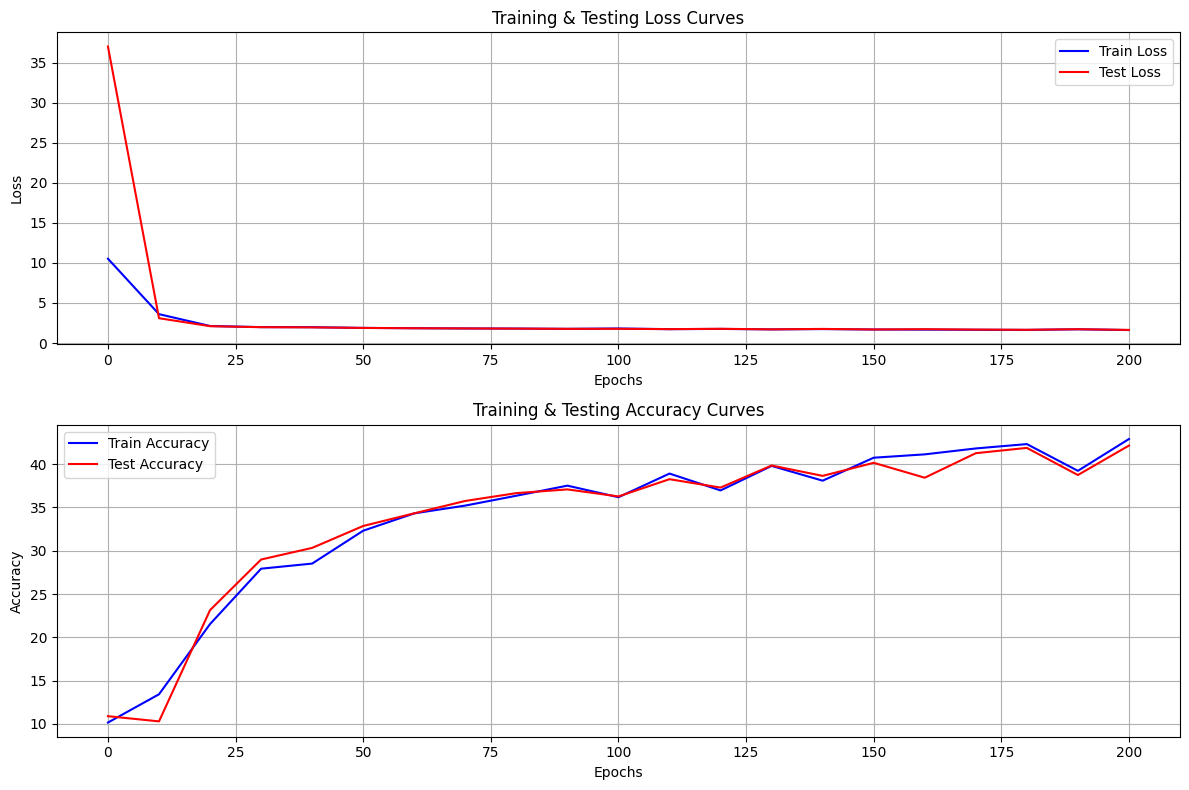

Model Saved Successfully


In [26]:
plot_loss_acc_curves(epoch_count, loss_values, test_loss_values, acc_values, test_acc_values)
save_model(model=model_MLP, save_name='model_MLP.pth')

Από τα παραπάνω αποτελέσματα παρατηρούμε πως η απόδοση του νευρωνικού μας δεν ήταν αρκετά καλή αλλά ωστόσο παραμένει καλύτερη από τους αλγορίθμους της ενδιάμεσης εργασίας για όλο το πλήθος δεδομένων χωρίς κάποια προεπεξεργασία. Ένας τρόπος για να βελτιώσουμε την απόδοση του θα ήταν να προσθέσουμε περισσότερους νευρώνες στα κρυφά επίπεδα, πράγμα που ωστόσο θα απαιτούσε πολύ μεγαλύτερο χρόνο εκτέλεσης. Για να μπορέσουμε να δοκιμάσουμε και αυτή την προσέγγιση και να δούμε τα αποτελέσματα της θα χωρίσουμε τα δεδομένα μας σε μικρότερα batches των 32 εικόνων. Με αυτό τον τρόπο θα ενημερώνουμε πολύ πιο συχνά τα βάρη αντί για κάθε epoch όπως προηγουμένως. Αυτό δίνει μια στοχαστικότητα στο νευρωνικό μας δίκτυο και επιταχύνει σημαντικά την ταχύτητα εκπαίδευσης του.

In [15]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset  = TensorDataset(X_test_tensor, y_test_tensor)

BATCH_SIZE = 32

train_dataloader = DataLoader(train_dataset, # the dataset to turn into iterable
batch_size=BATCH_SIZE, # the size of the batch
shuffle=True # shuffle data every epoch
)

test_dataloader = DataLoader(test_dataset, # the dataset to turn into iterable
batch_size=BATCH_SIZE, # the size of the batch
shuffle=False # no need to shuffle test data every epoch
)

# Confussion Matrix
Επίσης, ένας ακόμη τρόπος να αναπαραστήσουμε το πλήθος των σωστών και λανθασμένων εκτιμήσεων του μοντέλου μας θα ήταν με την χρήση ενός **Confussion Matrix**, το οποίο θα μας δίνει πιο γραφικά την επιτυχία που είχε το μοντέλο μας στα test samples, γεγονός που μας βοηθάει περισσότερο στο να οπτικοποιήσουμε καλύτερα και να κατανοήσουμε περισσότερο πόσο καλό είναι το μοντέλο μας.

In [16]:
def predict(model, test_dataloader):
  y_preds = []
  model.eval()
  with torch.inference_mode():
    for X, y in test_dataloader:
      y_logit = model(X)
      y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1) 
      y_preds.append(y_pred.cpu())
  y_pred_tensor = torch.cat(y_preds)
  return y_pred_tensor

def confusion_matrix(label_names, y_predictions, y_test_tensor):
    confmat = ConfusionMatrix(num_classes=len(label_names), task='multiclass')
    confmat_tensor = confmat(preds=y_predictions,
                            target=y_test_tensor.cpu())
    fig, ax = plot_confusion_matrix(
        conf_mat=confmat_tensor.numpy(), 
        class_names=label_names, 
        figsize=(10, 8),
        colorbar=True,
        show_absolute=False,
        show_normed=True,
        cmap='RdYlBu'
    )

    ax.set_xlabel("Predicted Labels")
    ax.set_ylabel("True Labels")
    ax.set_title("Normalized Confusion Matrix")
    plt.show()

In [ ]:
model_MLP_batch = CIFARClassifierRELU(in_features=X_train_tensor.shape[1], out_features=10, hidden_units=2500).to(device)

loss_fn, optimizer, scheduler = loss_optimizer(model=model_MLP_batch, lr=0.001, momentum=0.7, scheduler_on=False, Adam=False)
epochs = 51
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epoch_count = []
loss_values = []
test_loss_values = []
acc_values = []
test_acc_values = []
start = time.time()
for epoch in range(epochs):
    train_loss = 0
    train_acc  = 0
    test_loss  = 0
    test_acc   = 0
    for batch, (X, y) in enumerate(train_dataloader):
        ### Training
        model_MLP_batch.train()

        # Forward Pass
        y_logits = model_MLP_batch(X)
        y_preds  = torch.softmax(y_logits, dim=1).argmax(dim=1)

        # Calculate the Loss and Accuracy
        loss = loss_fn(y_logits, y)
        train_loss += loss
        accuracy = accuracy_score(y_true=y, y_pred=y_preds)
        train_acc  += accuracy

        # Zero the gradients
        optimizer.zero_grad()

        # Loss Backward
        loss.backward()

        # Optimizer Step
        optimizer.step()

    train_loss /= len(train_dataloader)
    train_acc  /= len(train_dataloader)

    ### Testing
    model_MLP_batch.eval()
    with torch.inference_mode():
        for batch, (X, y) in enumerate(test_dataloader):
            test_logits = model_MLP_batch(X)
            test_preds  = torch.softmax(test_logits, dim=1).argmax(dim=1)

            test_loss += loss_fn(test_logits, y)
            test_acc  += accuracy_score(y_true=y, y_pred=test_preds)

        test_loss /= len(test_dataloader)
        test_acc  /= len(test_dataloader)

    if epoch % 10 == 0:
        epoch_count.append(epoch)
        loss_values.append(train_loss.item())
        test_loss_values.append(test_loss.item())
        acc_values.append(train_acc)
        test_acc_values.append(test_acc)
        print(f"Epoch {epoch} | Loss : {train_loss:.5f} | Accuracy : {train_acc:.2f}% | Test Loss : {test_loss:.5f} | Test Accuracy : {test_acc:.2f}%")

end = time.time()

print(f'Total Execution time : {end-start:.3f} seconds')

Epoch 0 | Loss : 2.19945 | Accuracy : 32.23% | Test Loss : 1.72598 | Test Accuracy : 38.65%
Epoch 10 | Loss : 1.16225 | Accuracy : 58.40% | Test Loss : 1.47455 | Test Accuracy : 50.18%
Epoch 20 | Loss : 0.56902 | Accuracy : 79.64% | Test Loss : 1.94504 | Test Accuracy : 49.43%
Epoch 30 | Loss : 0.25494 | Accuracy : 91.22% | Test Loss : 2.67985 | Test Accuracy : 51.21%
Epoch 40 | Loss : 0.11648 | Accuracy : 96.13% | Test Loss : 3.36959 | Test Accuracy : 50.52%
Epoch 50 | Loss : 0.05384 | Accuracy : 98.23% | Test Loss : 4.02678 | Test Accuracy : 52.51%
Total Execution time : 289.463 seconds


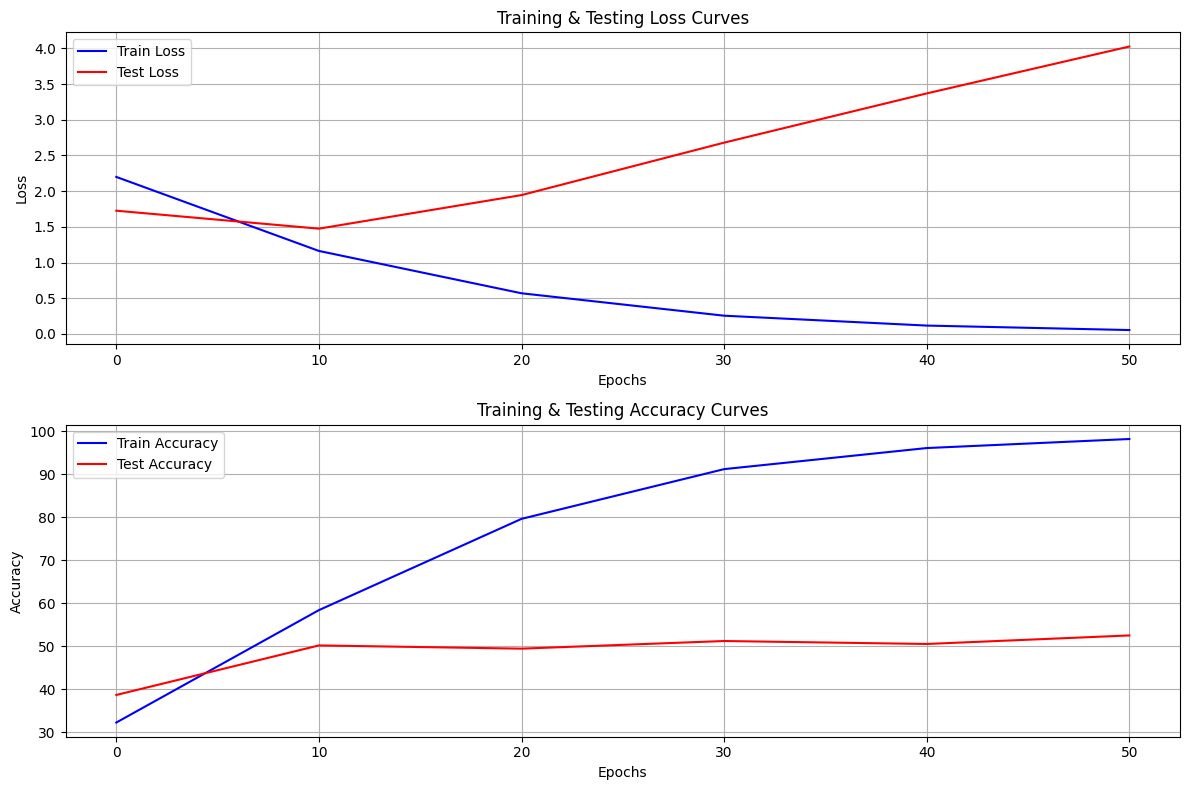

In [30]:
plot_loss_acc_curves(epoch_count, loss_values, test_loss_values, acc_values, test_acc_values)

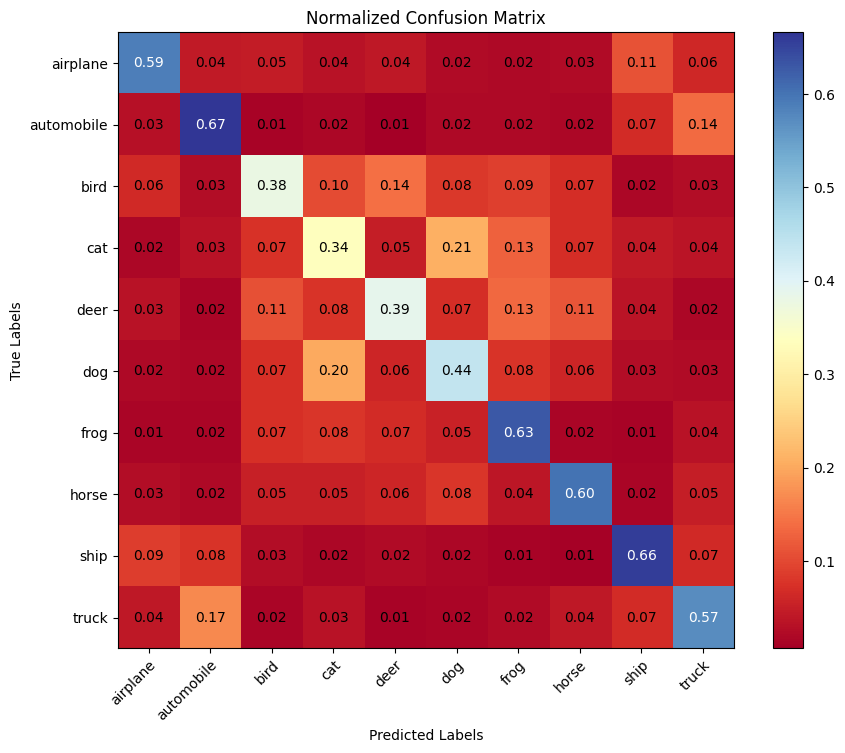

In [31]:
y_predictions = predict(model_MLP_batch, test_dataloader)
confusion_matrix(label_names, y_predictions, y_test_tensor)

Παρατηρούμε ότι με την προσθήκη περισσότερων νευρώνων στα κρυφά επίπεδα είχαμε όντως καλύτερη επίδοση στα testing samples. Ωστόσο, όπως φαίνεται και από τα γραφήματά μας φαίνεται το νευρωνικό δίκτυο να μαθαίνει υπερβολικά καλά τα training samples και να έχουμε σοβαρό πρόβλημα υπερπροσαρμογής. Επομένως, ναι μεν είχαμε κάποια βελτίωση και στην ταχύτητα εκπαίδευσης αλλά και στην ακρίβεια του test αλλά με ένα σοβαρό κόστος, αυτό του overfitting. Οπότε, αυτή η υλοποίηση μας είναι υπερβολικά "δυνατή" και δεν μαθαίνει πραγματικά αλλά απομνημονεύει τα ιδιαίτερα χαρακτηριστικά των εικόνων.

Ας δοκιμάσουμε τώρα να βάλουμε μικρότερο πλήθος νευρώνων στα hidden layers και παράλληλα να χρησιμοποιήσουμε πάλι batches για να δούμε άμα θα έχουμε και σε αυτή την περίπτωση το πρόβλημα της υπερ-προσαρμογής του μοντέλου μας στα training samples. 

In [ ]:
model_MLP_batch_2 = CIFARClassifierRELU(in_features=X_train_tensor.shape[1], out_features=10, hidden_units=500).to(device)

loss_fn, optimizer, scheduler = loss_optimizer(model=model_MLP_batch_2, lr=0.001, momentum=0.7, scheduler_on=False, Adam=False)
epochs = 51
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epoch_count = []
loss_values = []
test_loss_values = []
acc_values = []
test_acc_values = []
start = time.time()
for epoch in range(epochs):
    train_loss = 0
    train_acc  = 0
    test_loss  = 0
    test_acc   = 0
    for batch, (X, y) in enumerate(train_dataloader):
        ### Training
        model_MLP_batch_2.train()

        # Forward Pass
        y_logits = model_MLP_batch_2(X)
        y_preds  = torch.softmax(y_logits, dim=1).argmax(dim=1)

        # Calculate the Loss and Accuracy
        loss = loss_fn(y_logits, y)
        train_loss += loss
        accuracy = accuracy_score(y_true=y, y_pred=y_preds)
        train_acc  += accuracy

        # Zero the gradients
        optimizer.zero_grad()

        # Loss Backward
        loss.backward()

        # Optimizer Step
        optimizer.step()

    train_loss /= len(train_dataloader)
    train_acc  /= len(train_dataloader)

    ### Testing
    model_MLP_batch_2.eval()
    with torch.inference_mode():
        for batch, (X, y) in enumerate(test_dataloader):
            test_logits = model_MLP_batch_2(X)
            test_preds  = torch.softmax(test_logits, dim=1).argmax(dim=1)

            test_loss += loss_fn(test_logits, y)
            test_acc  += accuracy_score(y_true=y, y_pred=test_preds)

        test_loss /= len(test_dataloader)
        test_acc  /= len(test_dataloader)

    if epoch % 10 == 0:
        epoch_count.append(epoch)
        loss_values.append(train_loss.item())
        test_loss_values.append(test_loss.item())
        acc_values.append(train_acc)
        test_acc_values.append(test_acc)
        print(f"Epoch {epoch} | Loss : {train_loss:.5f} | Accuracy : {train_acc:.2f}% | Test Loss : {test_loss:.5f} | Test Accuracy : {test_acc:.2f}%")

end = time.time()

print(f'Total Execution time : {end-start:.3f} seconds')

Epoch 0 | Loss : 2.49670 | Accuracy : 14.59% | Test Loss : 2.19744 | Test Accuracy : 15.39%
Epoch 10 | Loss : 1.58816 | Accuracy : 42.90% | Test Loss : 1.62549 | Test Accuracy : 41.87%
Epoch 20 | Loss : 1.42675 | Accuracy : 48.54% | Test Loss : 1.53061 | Test Accuracy : 45.83%
Epoch 30 | Loss : 1.27648 | Accuracy : 53.95% | Test Loss : 1.55803 | Test Accuracy : 46.77%
Epoch 40 | Loss : 1.12061 | Accuracy : 59.02% | Test Loss : 1.64029 | Test Accuracy : 46.74%
Epoch 50 | Loss : 0.96963 | Accuracy : 64.42% | Test Loss : 1.81752 | Test Accuracy : 46.47%
Total Execution time : 216.818 seconds


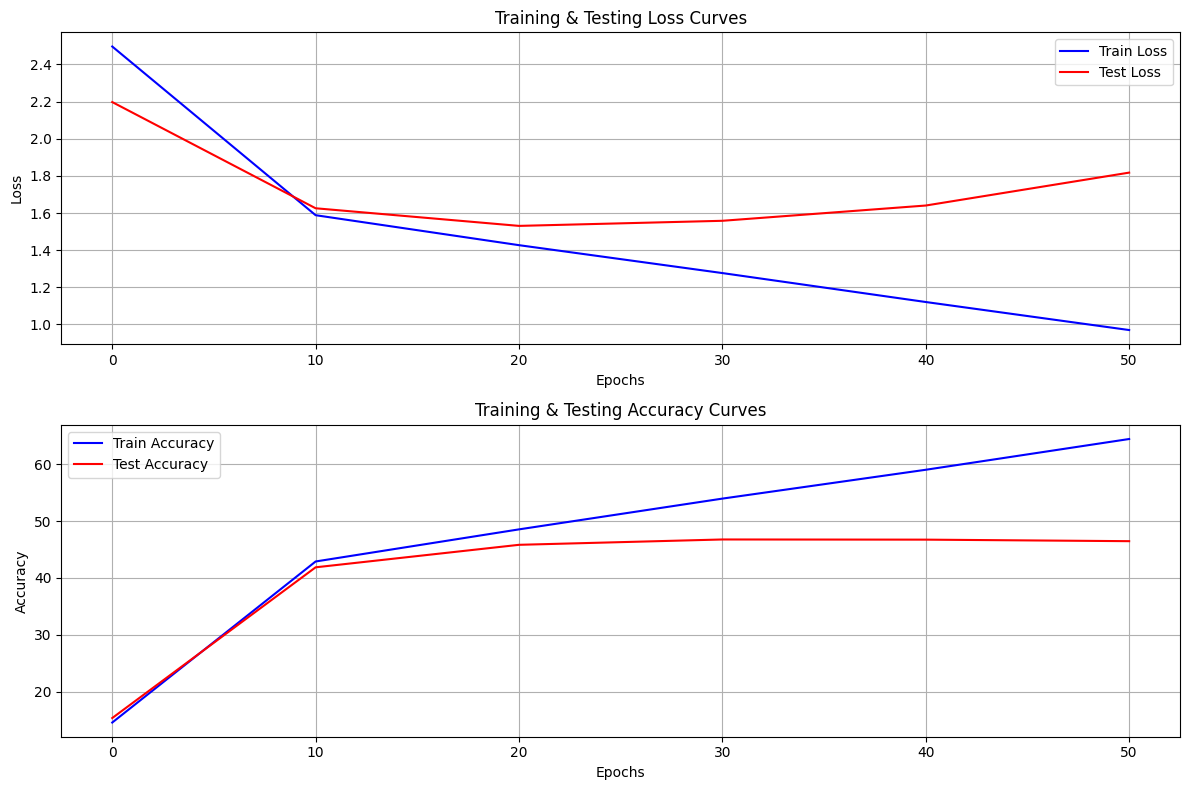

In [33]:
plot_loss_acc_curves(epoch_count, loss_values, test_loss_values, acc_values, test_acc_values)

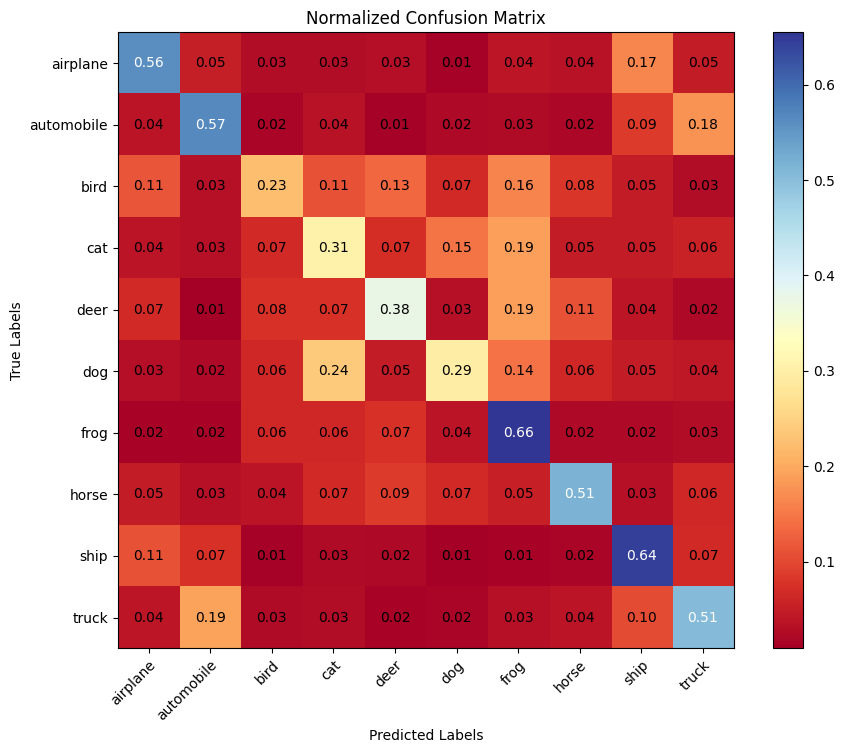

In [34]:
y_predictions = predict(model_MLP_batch_2, test_dataloader)
confusion_matrix(label_names, y_predictions, y_test_tensor)

Παρατηρούμε πως και σε αυτή την περίπτωση φαίνεται να έχουμε υπερ-προσαρμογή του μοντέλου μας στα training δεδομένα, παρόλο που μειώσαμε το πλήθος των νευρώνων των κρυφών επιπέδων από 2500 νευρώνες σε 500 νευρώνες. Αυτό, το γεγονός μας οδηγεί στο ότι ο λόγος που ίσως να έχουμε υπερ-προσαρμογή οφείλεται στο ότι σπάμε τα training samples σε μικρότερα batches των 32. Ωστόσο, ας κάνουμε μια ακόμα δοκιμή με λιγότερους νευρώνες στα κρυφά επίπεδα.

In [ ]:
model_MLP_batch_3 = CIFARClassifierRELU(in_features=X_train_tensor.shape[1], out_features=10, hidden_units=250).to(device)

loss_fn, optimizer, scheduler = loss_optimizer(model=model_MLP_batch_3, lr=0.001, momentum=0.7, scheduler_on=False, Adam=False)
epochs = 71
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epoch_count = []
loss_values = []
test_loss_values = []
acc_values = []
test_acc_values = []
start = time.time()
for epoch in range(epochs):
    train_loss = 0
    train_acc  = 0
    test_loss  = 0
    test_acc   = 0
    for batch, (X, y) in enumerate(train_dataloader):
        ### Training
        model_MLP_batch_3.train()

        # Forward Pass
        y_logits = model_MLP_batch_3(X)
        y_preds  = torch.softmax(y_logits, dim=1).argmax(dim=1)

        # Calculate the Loss and Accuracy
        loss = loss_fn(y_logits, y)
        train_loss += loss
        accuracy = accuracy_score(y_true=y, y_pred=y_preds)
        train_acc  += accuracy

        # Zero the gradients
        optimizer.zero_grad()

        # Loss Backward
        loss.backward()

        # Optimizer Step
        optimizer.step()

    train_loss /= len(train_dataloader)
    train_acc  /= len(train_dataloader)

    ### Testing
    model_MLP_batch_3.eval()
    with torch.inference_mode():
        for batch, (X, y) in enumerate(test_dataloader):
            test_logits = model_MLP_batch_3(X)
            test_preds  = torch.softmax(test_logits, dim=1).argmax(dim=1)

            test_loss += loss_fn(test_logits, y)
            test_acc  += accuracy_score(y_true=y, y_pred=test_preds)

        test_loss /= len(test_dataloader)
        test_acc  /= len(test_dataloader)

    if epoch % 10 == 0:
        epoch_count.append(epoch)
        loss_values.append(train_loss.item())
        test_loss_values.append(test_loss.item())
        acc_values.append(train_acc)
        test_acc_values.append(test_acc)
        print(f"Epoch {epoch} | Loss : {train_loss:.5f} | Accuracy : {train_acc:.2f}% | Test Loss : {test_loss:.5f} | Test Accuracy : {test_acc:.2f}%")

end = time.time()

print(f'Total Execution time : {end-start:.3f} seconds')

Epoch 0 | Loss : 2.57813 | Accuracy : 9.96% | Test Loss : 2.30334 | Test Accuracy : 9.97%
Epoch 10 | Loss : 1.88424 | Accuracy : 29.47% | Test Loss : 1.83738 | Test Accuracy : 31.04%
Epoch 20 | Loss : 1.60730 | Accuracy : 42.00% | Test Loss : 1.65024 | Test Accuracy : 39.78%
Epoch 30 | Loss : 1.48927 | Accuracy : 46.26% | Test Loss : 1.53790 | Test Accuracy : 44.97%
Epoch 40 | Loss : 1.41812 | Accuracy : 48.99% | Test Loss : 1.56336 | Test Accuracy : 45.14%
Epoch 50 | Loss : 1.35618 | Accuracy : 51.02% | Test Loss : 1.55909 | Test Accuracy : 45.83%
Epoch 60 | Loss : 1.29967 | Accuracy : 53.12% | Test Loss : 1.59706 | Test Accuracy : 46.57%
Epoch 70 | Loss : 1.25761 | Accuracy : 54.59% | Test Loss : 1.59159 | Test Accuracy : 46.18%
Total Execution time : 273.679 seconds


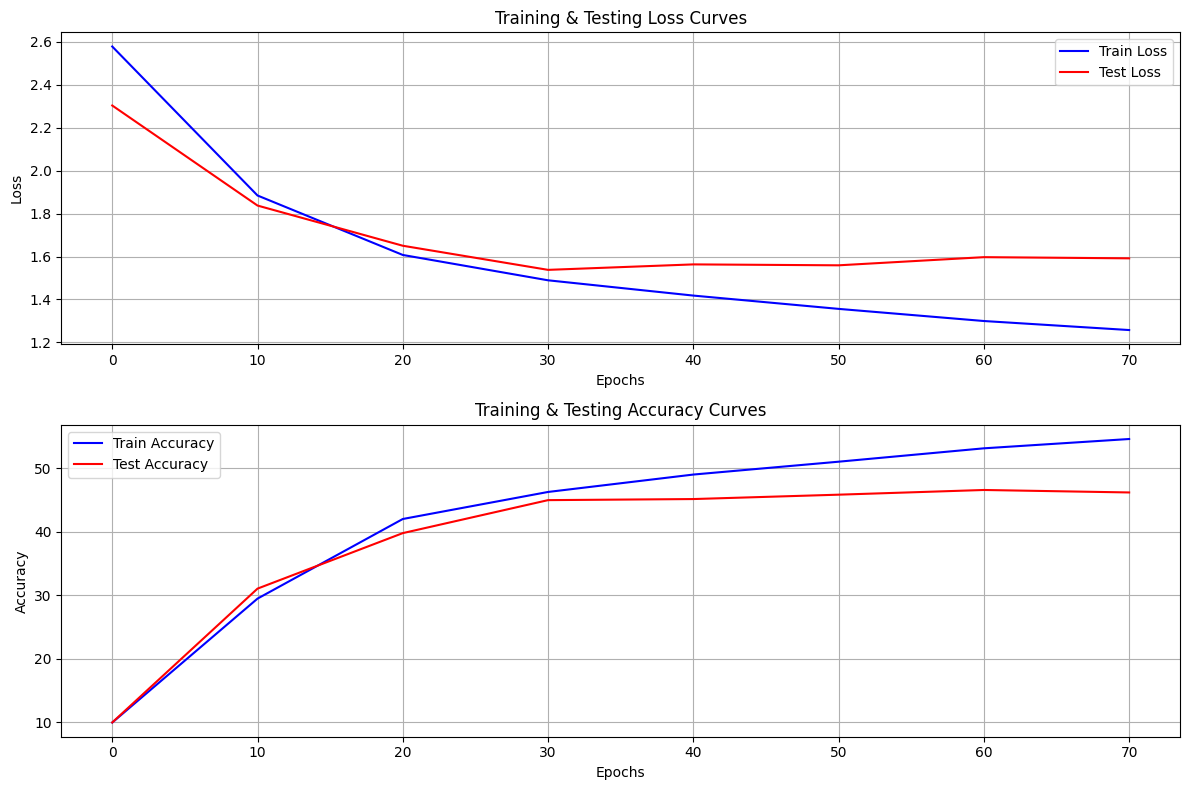

In [36]:
plot_loss_acc_curves(epoch_count, loss_values, test_loss_values, acc_values, test_acc_values)

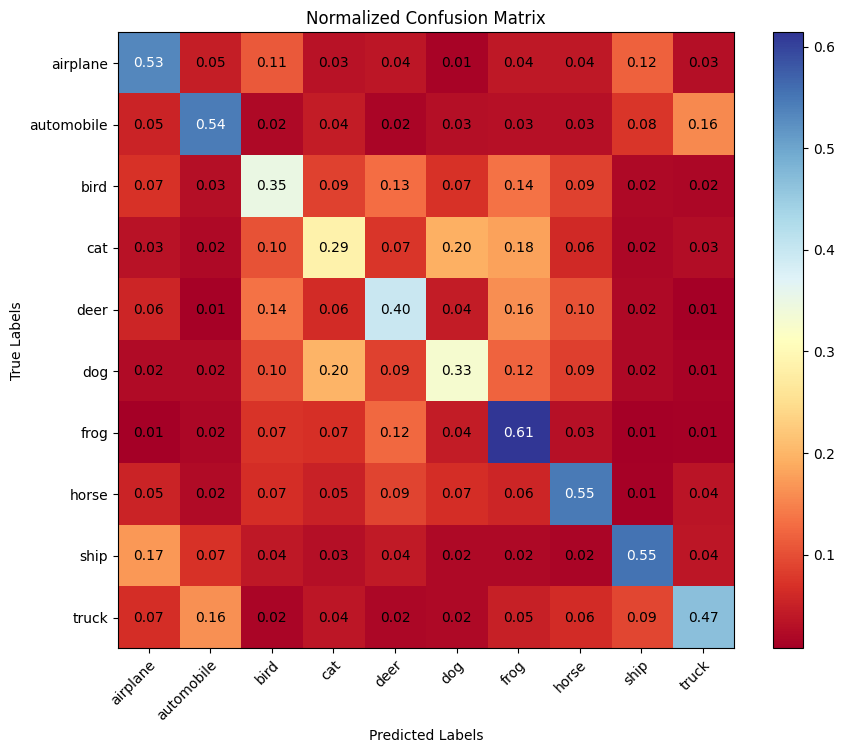

In [37]:
y_predictions = predict(model_MLP_batch_3, test_dataloader)
confusion_matrix(label_names, y_predictions, y_test_tensor)

Παρατηρούμε πως και σε αυτή την περίπτωση το μοντέλο μας τείνει να υπερ-προσαρμόζεται στα δεδομένα εκπαίδευσης. Αυτό μας οδηγεί στο συμπέρασμα πως ο τρόπος με τον οποίο τον εκπαιδεύουμε, δηλαδή χωρίζοντας τα δεδομένα μας σε batches, δεν το βοηθάει να μάθει. Μια λύση σε αυτό το πρόβλημα θα ήταν να εκπαιδεύουμε όπως και προηγουμένως, δηλαδή δίνοντας στο forward pass όλο το πλήθος των δεδομένων αντί για μέρος αυτού. Ωστόσο, όπως είδαμε και προηγουμένως αυτό μπορεί να είναι πιο χρονοβόρο και να απαιτεί περισσότερους πόρους του συστήματος μας για την εκπαίδευση του. Μια εναλλακτική λύση θα ήταν να μηδενίζουμε την συνεισφορά κάποιων νευρώνων κατά την διάρκεια του training, με κάποια πιθανότητα. Αυτή η τεχνική θα βοηθήσει στο να μην έχουμε τόσο έντονο το φαινόμενο της υπερ-προσαρμογής καθώς θα είναι μεγάλη η πιθανότητα κατά την οποία τα βάρη ορισμένων νευρώνων δεν θα ενημερώνονται και άρα δεν θα απομνημονεύουν δεδομένα αλλά θα μαθαίνουν όντως.

Παρακάτω φαίνεται η τροποποιημένη κλάση με την παραλλαγή που αναφέραμε προηγουμένως και με συνάρτηση ενεργοποίησης την **ReLU** καθότι όπως διαπιστώσαμε αποδίδει πολύ καλύτερα από την σιγμοειδή.

In [17]:
class CIFARClassifierRELUV2(nn.Module):

    def __init__(self, in_features, out_features, hidden_units=800):
        super().__init__()
        self.layer = nn.Sequential(
            nn.Linear(in_features=in_features, out_features=hidden_units), # here I create u = w^T*x + b
            nn.ReLU(), # y = φ(u)
            nn.Dropout(0.3),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=out_features)
        )

    def forward(self, x):
        return self.layer(x)

Με την συνάρτηση `nn.Dropout()` πραγματοποιούμε αυτό που ανέφερα προηγουμένως δηλαδή την "απενεργοποίηση" κάποιων νευρώνων του συγκεκριμένου layer κατά την διάρκεια του training με πιθανότητα η οποία δίνεται ως όρισμα στην συνάρτηση.

In [ ]:
model_relu_2 = CIFARClassifierRELUV2(in_features=X_train_tensor.shape[1], out_features=10, hidden_units=250).to(device)

loss_fn, optimizer, scheduler = loss_optimizer(model=model_relu_2, lr=0.001, momentum=0.7, scheduler_on=False, Adam=False)
epochs = 71
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epoch_count = []
loss_values = []
test_loss_values = []
acc_values = []
test_acc_values = []
start = time.time()
for epoch in range(epochs):
    train_loss = 0
    train_acc  = 0
    test_loss  = 0
    test_acc   = 0
    for batch, (X, y) in enumerate(train_dataloader):
        ### Training
        model_relu_2.train()

        # Forward Pass
        y_logits = model_relu_2(X)
        y_preds  = torch.softmax(y_logits, dim=1).argmax(dim=1)

        # Calculate the Loss and Accuracy
        loss = loss_fn(y_logits, y)
        train_loss += loss
        accuracy = accuracy_score(y_true=y, y_pred=y_preds)
        train_acc  += accuracy

        # Zero the gradients
        optimizer.zero_grad()

        # Loss Backward
        loss.backward()

        # Optimizer Step
        optimizer.step()

    train_loss /= len(train_dataloader)
    train_acc  /= len(train_dataloader)

    ### Testing
    model_relu_2.eval()
    with torch.inference_mode():
        for batch, (X, y) in enumerate(test_dataloader):
            test_logits = model_relu_2(X)
            test_preds  = torch.softmax(test_logits, dim=1).argmax(dim=1)

            test_loss += loss_fn(test_logits, y)
            test_acc  += accuracy_score(y_true=y, y_pred=test_preds)

        test_loss /= len(test_dataloader)
        test_acc  /= len(test_dataloader)

    if epoch % 10 == 0:
        epoch_count.append(epoch)
        loss_values.append(train_loss.item())
        test_loss_values.append(test_loss.item())
        acc_values.append(train_acc)
        test_acc_values.append(test_acc)
        print(f"Epoch {epoch} | Loss : {train_loss:.5f} | Accuracy : {train_acc:.2f}% | Test Loss : {test_loss:.5f} | Test Accuracy : {test_acc:.2f}%")

end = time.time()

print(f'Total Execution time : {end-start:.3f} seconds')

Epoch 0 | Loss : 2.35462 | Accuracy : 10.52% | Test Loss : 2.30150 | Test Accuracy : 10.12%
Epoch 10 | Loss : 2.03212 | Accuracy : 23.68% | Test Loss : 2.05498 | Test Accuracy : 23.04%
Epoch 20 | Loss : 1.97527 | Accuracy : 26.09% | Test Loss : 2.04187 | Test Accuracy : 23.00%
Epoch 30 | Loss : 1.93868 | Accuracy : 28.50% | Test Loss : 1.98993 | Test Accuracy : 25.43%
Epoch 40 | Loss : 1.93309 | Accuracy : 28.77% | Test Loss : 1.97552 | Test Accuracy : 27.53%
Epoch 50 | Loss : 1.92612 | Accuracy : 28.77% | Test Loss : 1.90119 | Test Accuracy : 31.03%
Epoch 60 | Loss : 1.91850 | Accuracy : 29.06% | Test Loss : 1.91451 | Test Accuracy : 30.09%
Epoch 70 | Loss : 1.91788 | Accuracy : 29.04% | Test Loss : 1.94498 | Test Accuracy : 30.51%
Total Execution time : 306.869 seconds


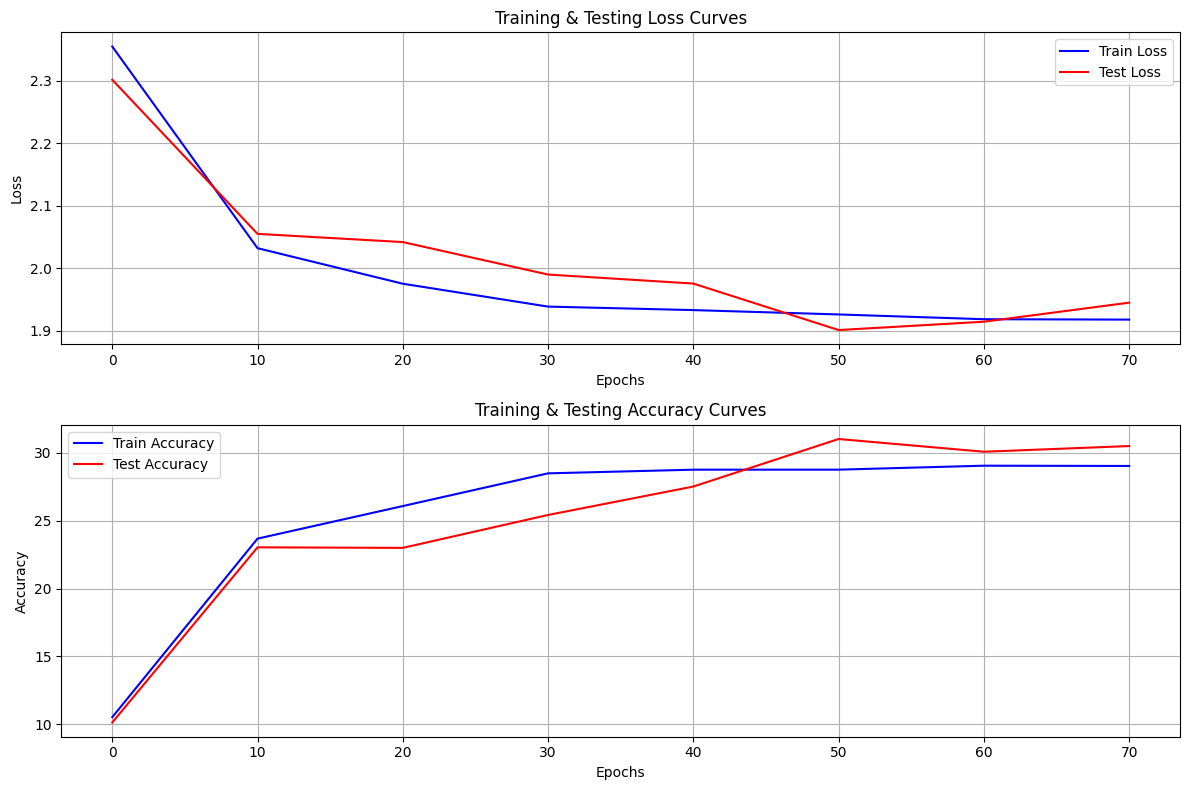

In [40]:
plot_loss_acc_curves(epoch_count, loss_values, test_loss_values, acc_values, test_acc_values)

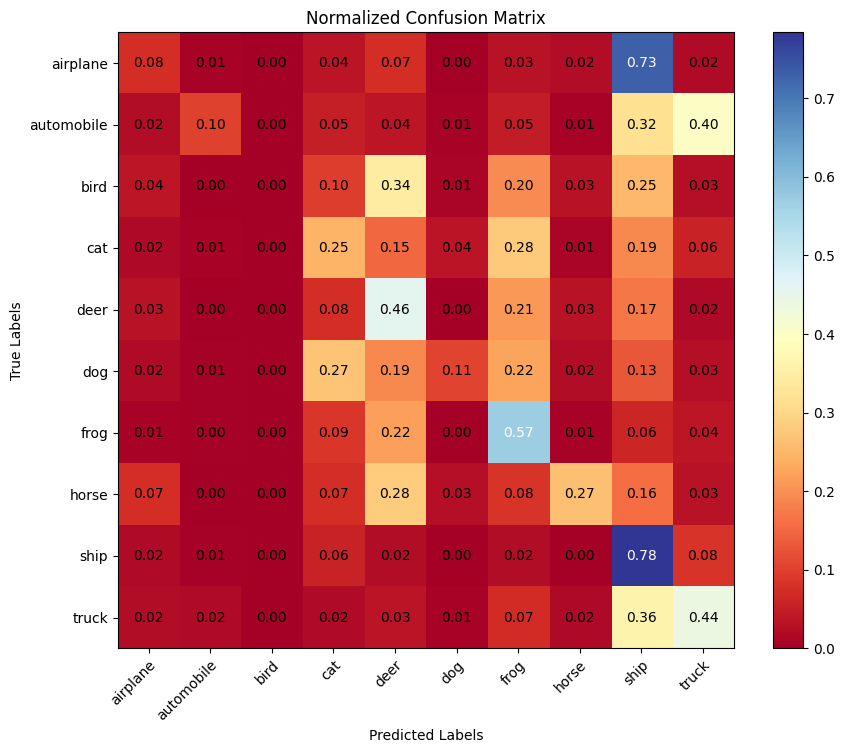

In [41]:
y_predictions = predict(model_relu_2, test_dataloader)
confusion_matrix(label_names, y_predictions, y_test_tensor)

Από τα αποτελέσματα της εκπαίδευσης βλέπουμε πως το νευρωνικό φαίνεται να μαθαίνει καλύτερα με αυτό τον τρόπο. Επομένως ας δοκιμάσουμε να αυξήσουμε το πλήθος των νευρώνων στα κρυφά επίπεδα για να δούμε άμα θα έχουμε κάποια βελτίωση στην ακρίβεια στο testing.

In [ ]:
model_relu_3 = CIFARClassifierRELUV2(in_features=X_train_tensor.shape[1], out_features=10, hidden_units=500).to(device)

loss_fn, optimizer, scheduler = loss_optimizer(model=model_relu_3, lr=0.001, momentum=0.7, scheduler_on=False, Adam=False)
epochs = 71
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epoch_count = []
loss_values = []
test_loss_values = []
acc_values = []
test_acc_values = []
start = time.time()
for epoch in range(epochs):
    train_loss = 0
    train_acc  = 0
    test_loss  = 0
    test_acc   = 0
    for batch, (X, y) in enumerate(train_dataloader):
        ### Training
        model_relu_3.train()

        # Forward Pass
        y_logits = model_relu_3(X)
        y_preds  = torch.softmax(y_logits, dim=1).argmax(dim=1)

        # Calculate the Loss and Accuracy
        loss = loss_fn(y_logits, y)
        train_loss += loss
        accuracy = accuracy_score(y_true=y, y_pred=y_preds)
        train_acc  += accuracy

        # Zero the gradients
        optimizer.zero_grad()

        # Loss Backward
        loss.backward()

        # Optimizer Step
        optimizer.step()

    train_loss /= len(train_dataloader)
    train_acc  /= len(train_dataloader)

    ### Testing
    model_relu_3.eval()
    with torch.inference_mode():
        for batch, (X, y) in enumerate(test_dataloader):
            test_logits = model_relu_3(X)
            test_preds  = torch.softmax(test_logits, dim=1).argmax(dim=1)

            test_loss += loss_fn(test_logits, y)
            test_acc  += accuracy_score(y_true=y, y_pred=test_preds)

        test_loss /= len(test_dataloader)
        test_acc  /= len(test_dataloader)

    if epoch % 10 == 0:
        epoch_count.append(epoch)
        loss_values.append(train_loss.item())
        test_loss_values.append(test_loss.item())
        acc_values.append(train_acc)
        test_acc_values.append(test_acc)
        print(f"Epoch {epoch} | Loss : {train_loss:.5f} | Accuracy : {train_acc:.2f}% | Test Loss : {test_loss:.5f} | Test Accuracy : {test_acc:.2f}%")

end = time.time()

print(f'Total Execution time : {end-start:.3f} seconds')

Epoch 0 | Loss : 2.40643 | Accuracy : 9.84% | Test Loss : 2.30269 | Test Accuracy : 10.10%
Epoch 10 | Loss : 1.98068 | Accuracy : 25.54% | Test Loss : 1.94178 | Test Accuracy : 29.46%
Epoch 20 | Loss : 1.84605 | Accuracy : 32.05% | Test Loss : 1.87796 | Test Accuracy : 36.61%
Epoch 30 | Loss : 1.77474 | Accuracy : 35.06% | Test Loss : 1.84724 | Test Accuracy : 38.35%
Epoch 40 | Loss : 1.73109 | Accuracy : 37.18% | Test Loss : 1.79707 | Test Accuracy : 39.09%
Epoch 50 | Loss : 1.70046 | Accuracy : 38.30% | Test Loss : 1.75497 | Test Accuracy : 39.97%
Epoch 60 | Loss : 1.67552 | Accuracy : 39.04% | Test Loss : 1.72446 | Test Accuracy : 40.63%
Epoch 70 | Loss : 1.64962 | Accuracy : 40.67% | Test Loss : 1.75958 | Test Accuracy : 38.02%
Total Execution time : 303.872 seconds


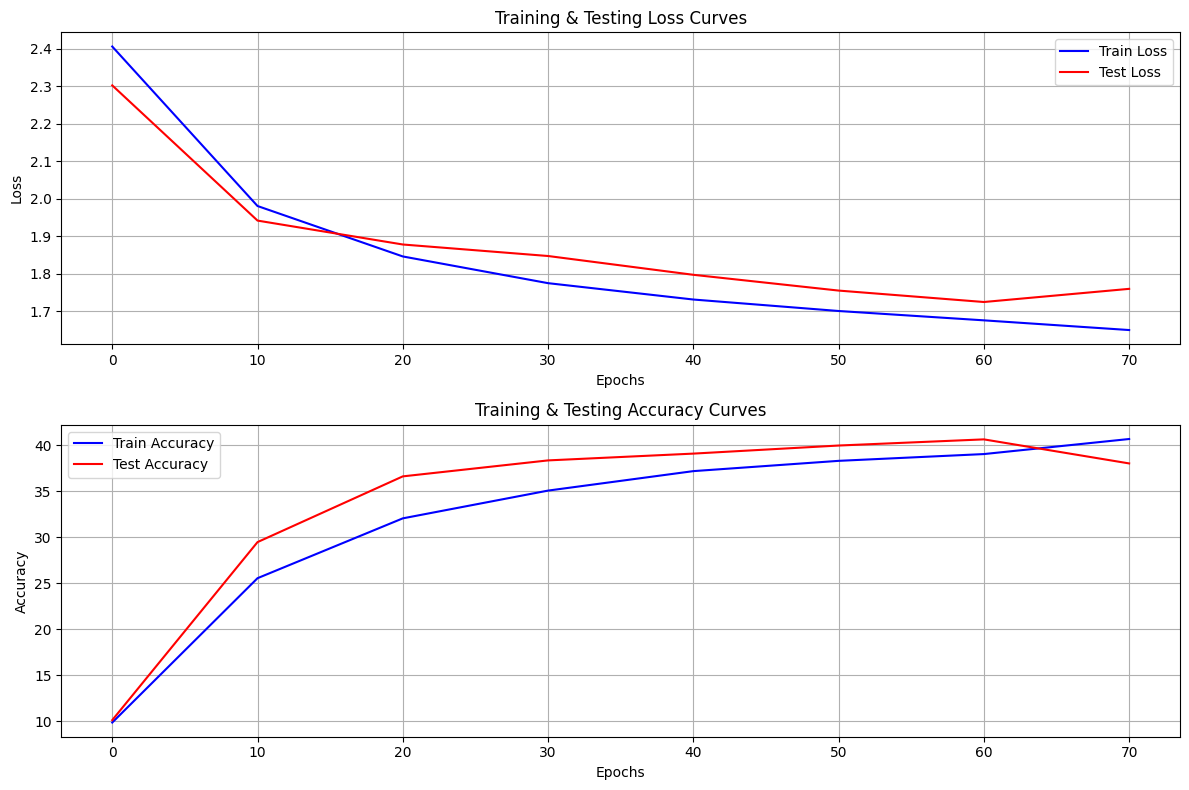

In [43]:
plot_loss_acc_curves(epoch_count, loss_values, test_loss_values, acc_values, test_acc_values)

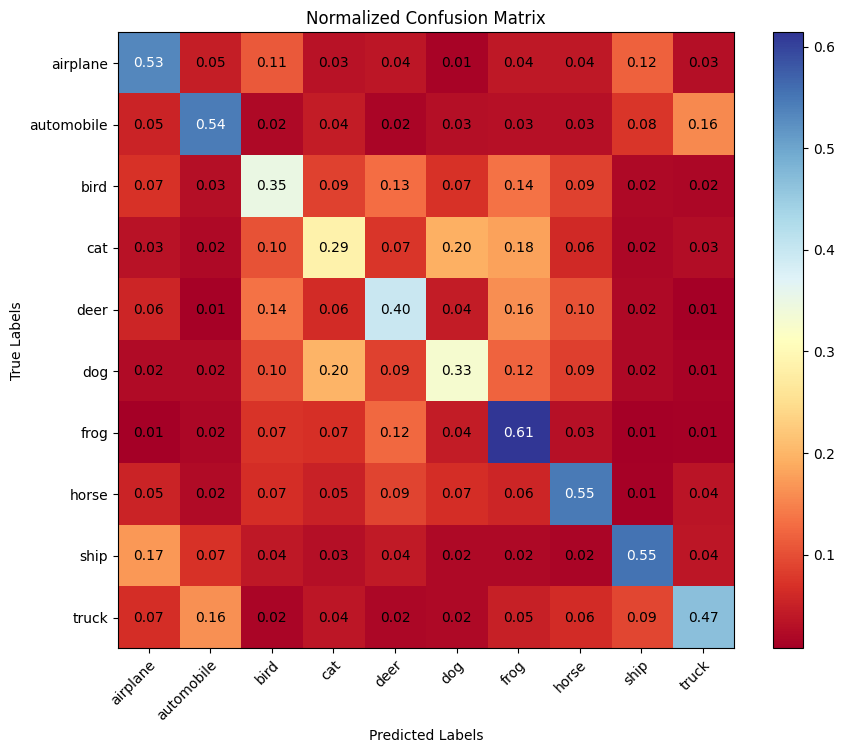

In [44]:
y_predictions = predict(model_MLP_batch_3, test_dataloader)
confusion_matrix(label_names, y_predictions, y_test_tensor)

Παρατηρούμε και πάλι πως το νευρωνικό μας μαθαίνει καλύτερα σε σχέση με προηγουμένως. Συνεπώς, η αλλαγή αυτή όντως βοήθησε στην περίπτωση του overfitting. Μια ακόμα υπερπαράμετρος που θα μπορούσαμε να αλλάξουμε θα ήταν το μέγεθος του batch. Ας δοκιμάσουμε και αυτή την αλλαγή για να δούμε τα αποτελέσματα.

Επειδή, ίσως χρειαστεί να αλλάξουμε αρκετές φορές τα training & testing samples καθώς επίσης και το batch size με το οποίο εκπαιδεύεται το νευρωνικό, αντί να γράφουμε πολλές φορές το ίδιο κομμάτι κώδικα θα το κάνουμε συνάρτηση για να είναι πιο κατανοητό και πιο δύσκολο στο να κάνουμε λάθη.

In [18]:
def batch_creation(X_train_tensor, X_test_tensor, y_train_tensor, y_test_tensor, BATCH_SIZE):
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset  = TensorDataset(X_test_tensor, y_test_tensor)

    BATCH_SIZE = BATCH_SIZE

    train_dataloader = DataLoader(train_dataset, # the dataset to turn into iterable
    batch_size=BATCH_SIZE, # the size of the batch
    shuffle=True # shuffle data every epoch
    )

    test_dataloader = DataLoader(test_dataset, # the dataset to turn into iterable
    batch_size=BATCH_SIZE, # the size of the batch
    shuffle=False # no need to shuffle test data every epoch
    )

    return train_dataloader, test_dataloader

In [ ]:
model_relu_4 = CIFARClassifierRELUV2(in_features=X_train_tensor.shape[1], out_features=10, hidden_units=500).to(device)
train_dataloader, test_dataloader = batch_creation(X_train_tensor, X_test_tensor, y_train_tensor, y_test_tensor, 128)
loss_fn, optimizer, scheduler = loss_optimizer(model=model_relu_4, lr=0.001, momentum=0.7, scheduler_on=False, Adam=False)
epochs = 101
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epoch_count = []
loss_values = []
test_loss_values = []
acc_values = []
test_acc_values = []
start = time.time()
for epoch in range(epochs):
    train_loss = 0
    train_acc  = 0
    test_loss  = 0
    test_acc   = 0
    for batch, (X, y) in enumerate(train_dataloader):
        ### Training
        model_relu_4.train()

        # Forward Pass
        y_logits = model_relu_4(X)
        y_preds  = torch.softmax(y_logits, dim=1).argmax(dim=1)

        # Calculate the Loss and Accuracy
        loss = loss_fn(y_logits, y)
        train_loss += loss
        accuracy = accuracy_score(y_true=y, y_pred=y_preds)
        train_acc  += accuracy

        # Zero the gradients
        optimizer.zero_grad()

        # Loss Backward
        loss.backward()

        # Optimizer Step
        optimizer.step()

    train_loss /= len(train_dataloader)
    train_acc  /= len(train_dataloader)

    ### Testing
    model_relu_4.eval()
    with torch.inference_mode():
        for batch, (X, y) in enumerate(test_dataloader):
            test_logits = model_relu_4(X)
            test_preds  = torch.softmax(test_logits, dim=1).argmax(dim=1)

            test_loss += loss_fn(test_logits, y)
            test_acc  += accuracy_score(y_true=y, y_pred=test_preds)

        test_loss /= len(test_dataloader)
        test_acc  /= len(test_dataloader)

    if epoch % 10 == 0:
        epoch_count.append(epoch)
        loss_values.append(train_loss.item())
        test_loss_values.append(test_loss.item())
        acc_values.append(train_acc)
        test_acc_values.append(test_acc)
        print(f"Epoch {epoch} | Loss : {train_loss:.5f} | Accuracy : {train_acc:.2f}% | Test Loss : {test_loss:.5f} | Test Accuracy : {test_acc:.2f}%")

end = time.time()

print(f'Total Execution time : {end-start:.3f} seconds')

Epoch 0 | Loss : 2.35772 | Accuracy : 15.76% | Test Loss : 2.05689 | Test Accuracy : 22.15%
Epoch 10 | Loss : 1.84808 | Accuracy : 32.83% | Test Loss : 1.74197 | Test Accuracy : 38.53%
Epoch 20 | Loss : 1.73301 | Accuracy : 37.82% | Test Loss : 1.68490 | Test Accuracy : 42.08%
Epoch 30 | Loss : 1.66994 | Accuracy : 40.10% | Test Loss : 1.63607 | Test Accuracy : 44.24%
Epoch 40 | Loss : 1.61929 | Accuracy : 41.83% | Test Loss : 1.58347 | Test Accuracy : 45.70%
Epoch 50 | Loss : 1.57281 | Accuracy : 43.25% | Test Loss : 1.54825 | Test Accuracy : 46.28%
Epoch 60 | Loss : 1.54129 | Accuracy : 44.72% | Test Loss : 1.55918 | Test Accuracy : 46.52%
Epoch 70 | Loss : 1.50101 | Accuracy : 46.14% | Test Loss : 1.51268 | Test Accuracy : 48.82%
Epoch 80 | Loss : 1.47203 | Accuracy : 46.97% | Test Loss : 1.50044 | Test Accuracy : 49.08%
Epoch 90 | Loss : 1.44958 | Accuracy : 47.72% | Test Loss : 1.47820 | Test Accuracy : 48.85%
Epoch 100 | Loss : 1.41735 | Accuracy : 49.09% | Test Loss : 1.46985 | 

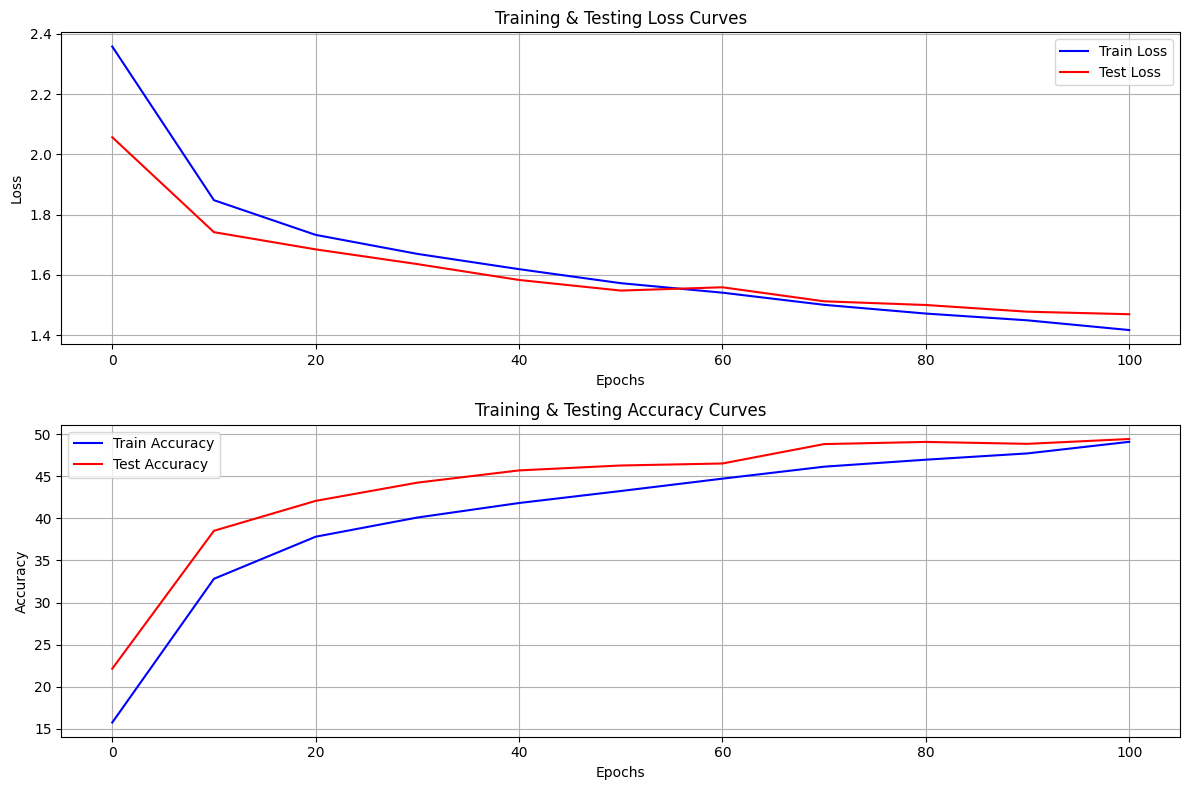

Model Saved Successfully


In [47]:
plot_loss_acc_curves(epoch_count, loss_values, test_loss_values, acc_values, test_acc_values)
save_model(model=model_relu_4, save_name='model_MLP_batch.pth')

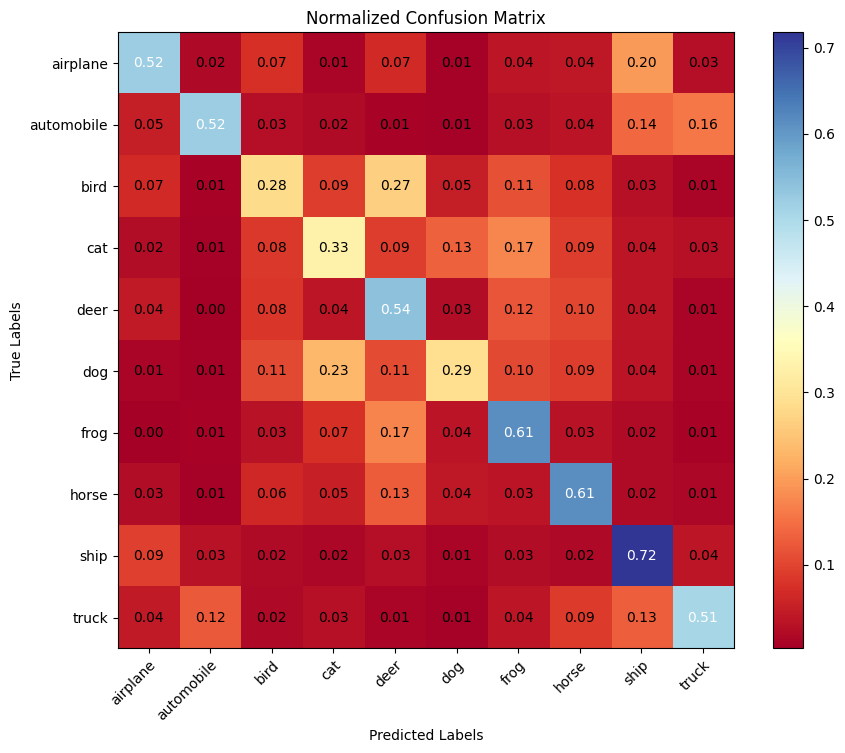

In [48]:
y_predictions = predict(model_relu_4, test_dataloader)
confusion_matrix(label_names, y_predictions, y_test_tensor)

Παρατηρούμε πως εδώ τα αποτελέσματα μας είναι πολύ καλά και ως προς τον παράγοντα της ακρίβειας στο test sample και ως προς τον παράγοντα της ταχύτητας καθότι μπορούμε να δούμε πως μειώθηκε σημαντικά η ταχύτητα με την οποία μαθαίνει το νευρωνικό σε σχέση με προηγουμένως, ενώ επίσης έχουμε κατορθώσει να αποφύγουμε την υπερ-προσαρμογή που είχαν τα προηγούμενά μας μοντέλα. Συνεπώς, υπάρχει μια εμφανής βελτίωση με αυτό το μέγεθος του batch και με αυτό το πλήθος των νευρώνων στα κρυφά επίπεδα.

## **Scheduler**
Ας δοκιμάσουμε τώρα να βάλουμε μεταβλητό βήμα για να δούμε την απόδοση που θα έχουμε και άμα θα υπάρξει κάποια βελτίωση. Ο scheduler που χρησιμοποιώ για όλες τις δοκιμές μου θα είναι ο `StepLR()` ο οποίος μειώνει το learning rate κατά ένα συγκεκριμένο ποσοστό, το οποίο το έχω ορίσει εγώ, μετά από έναν ορισμένο αριθμό epochs.  

In [63]:
model_scheduler = CIFARClassifierRELU(in_features=X_train_tensor.shape[1], out_features=10, hidden_units=500).to(device)
train_dataloader, test_dataloader = batch_creation(X_train_tensor, X_test_tensor, y_train_tensor, y_test_tensor, 32)
loss_fn, optimizer, scheduler = loss_optimizer(model=model_scheduler, lr=0.001, momentum=0.7, scheduler_on=True, Adam=False)
epochs = 101
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epoch_count = []
loss_values = []
test_loss_values = []
acc_values = []
test_acc_values = []
start = time.time()
for epoch in range(epochs):
    train_loss = 0
    train_acc  = 0
    test_loss  = 0
    test_acc   = 0
    for batch, (X, y) in enumerate(train_dataloader):
        ### Training
        model_scheduler.train()

        # Forward Pass
        y_logits = model_scheduler(X)
        y_preds  = torch.softmax(y_logits, dim=1).argmax(dim=1)

        # Calculate the Loss and Accuracy
        loss = loss_fn(y_logits, y)
        train_loss += loss
        accuracy = accuracy_score(y_true=y, y_pred=y_preds)
        train_acc  += accuracy

        # Zero the gradients
        optimizer.zero_grad()

        # Loss Backward
        loss.backward()

        # Optimizer Step
        optimizer.step()

    train_loss /= len(train_dataloader)
    train_acc  /= len(train_dataloader)

    ### Testing
    model_scheduler.eval()
    with torch.inference_mode():
        for batch, (X, y) in enumerate(test_dataloader):
            test_logits = model_scheduler(X)
            test_preds  = torch.softmax(test_logits, dim=1).argmax(dim=1)

            test_loss += loss_fn(test_logits, y)
            test_acc  += accuracy_score(y_true=y, y_pred=test_preds)

        test_loss /= len(test_dataloader)
        test_acc  /= len(test_dataloader)

    # Advance the scheduler
    scheduler.step()
    #print(f'LR : {scheduler.get_last_lr()}')
    if epoch % 10 == 0:
        epoch_count.append(epoch)
        loss_values.append(train_loss.item())
        test_loss_values.append(test_loss.item())
        acc_values.append(train_acc)
        test_acc_values.append(test_acc)
        print(f"Epoch {epoch} | Loss : {train_loss:.5f} | Accuracy : {train_acc:.2f}% | Test Loss : {test_loss:.5f} | Test Accuracy : {test_acc:.2f}%")

end = time.time()

print(f'Total Execution time : {end-start:.3f} seconds')

Epoch 0 | Loss : 2.47530 | Accuracy : 13.89% | Test Loss : 2.18230 | Test Accuracy : 16.95%
Epoch 10 | Loss : 1.54838 | Accuracy : 44.10% | Test Loss : 1.56825 | Test Accuracy : 43.86%
Epoch 20 | Loss : 1.33705 | Accuracy : 51.87% | Test Loss : 1.53322 | Test Accuracy : 46.23%
Epoch 30 | Loss : 1.15525 | Accuracy : 58.24% | Test Loss : 1.53436 | Test Accuracy : 47.96%
Epoch 40 | Loss : 1.04293 | Accuracy : 62.34% | Test Loss : 1.59915 | Test Accuracy : 47.87%
Epoch 50 | Loss : 0.88736 | Accuracy : 68.46% | Test Loss : 1.66072 | Test Accuracy : 47.45%
Epoch 60 | Loss : 0.77301 | Accuracy : 73.27% | Test Loss : 1.75031 | Test Accuracy : 47.20%
Epoch 70 | Loss : 0.72157 | Accuracy : 75.32% | Test Loss : 1.82074 | Test Accuracy : 46.60%
Epoch 80 | Loss : 0.66432 | Accuracy : 77.79% | Test Loss : 1.87590 | Test Accuracy : 45.92%
Epoch 90 | Loss : 0.62894 | Accuracy : 79.32% | Test Loss : 1.91268 | Test Accuracy : 45.96%
Epoch 100 | Loss : 0.61537 | Accuracy : 79.86% | Test Loss : 1.93429 | 

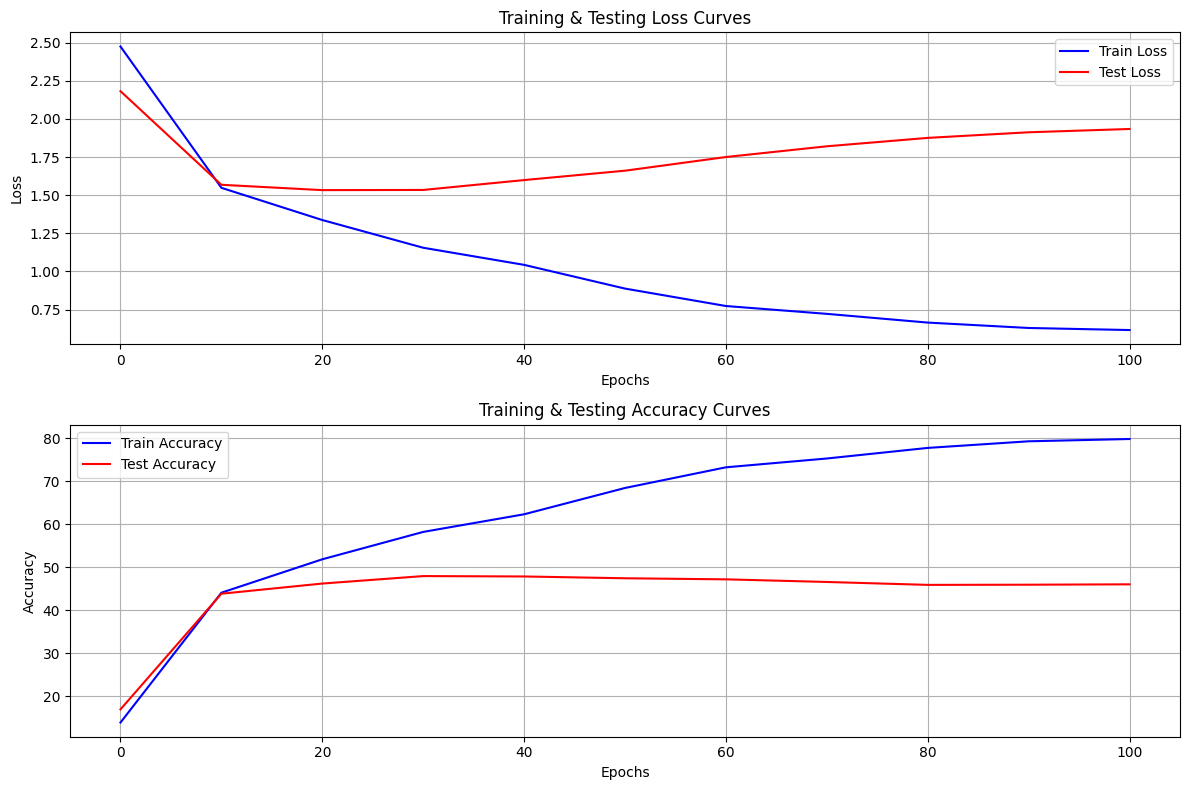

In [66]:
plot_loss_acc_curves(epoch_count, loss_values, test_loss_values, acc_values, test_acc_values)

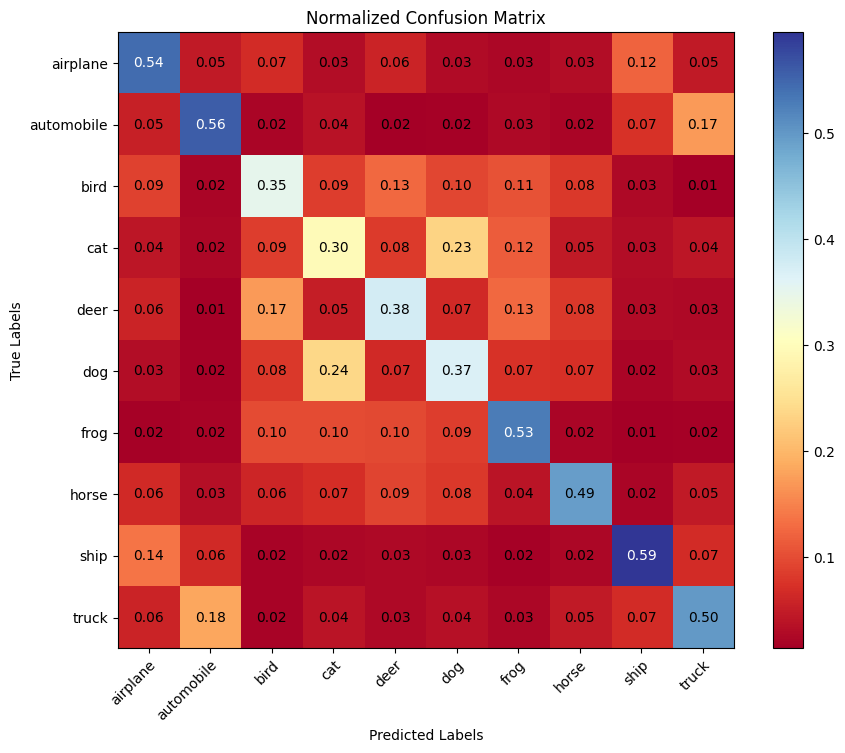

In [67]:
y_predictions = predict(model_scheduler, test_dataloader)
confusion_matrix(label_names, y_predictions, y_test_tensor)

Παρατηρούμε πως ακόμα και με την εισαγωγή του scheduler εξακολουθούμε να έχουμε το πρόβλημα της υπερ-προσαρμογής, ωστόσο βλέπουμε πως έχουμε πιο άργη σύγκλιση προς αυτή την κατεύθυνση και αυτό λόγω της επίδρασης του scheduler. Συνεπώς, η χρήση αυτής της μεθόδου θα μπορούσε να μας βοηθήσει να αντιμετωπίσουμε αυτό το πρόβλημα, οπότε θα κάνουμε κάποιες ακόμα δοκιμές για να δούμε την επίδραση του.

In [71]:
model_scheduler_2 = CIFARClassifierRELU(in_features=X_train_tensor.shape[1], out_features=10, hidden_units=1500).to(device)
train_dataloader, test_dataloader = batch_creation(X_train_tensor, X_test_tensor, y_train_tensor, y_test_tensor, 32)
loss_fn, optimizer, scheduler = loss_optimizer(model=model_scheduler_2, lr=0.0012, momentum=0.7, scheduler_on=True, Adam=False)
epochs = 51
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epoch_count = []
loss_values = []
test_loss_values = []
acc_values = []
test_acc_values = []
start = time.time()
for epoch in range(epochs):
    train_loss = 0
    train_acc  = 0
    test_loss  = 0
    test_acc   = 0
    for batch, (X, y) in enumerate(train_dataloader):
        ### Training
        model_scheduler_2.train()

        # Forward Pass
        y_logits = model_scheduler_2(X)
        y_preds  = torch.softmax(y_logits, dim=1).argmax(dim=1)

        # Calculate the Loss and Accuracy
        loss = loss_fn(y_logits, y)
        train_loss += loss
        accuracy = accuracy_score(y_true=y, y_pred=y_preds)
        train_acc  += accuracy

        # Zero the gradients
        optimizer.zero_grad()

        # Loss Backward
        loss.backward()

        # Optimizer Step
        optimizer.step()

    train_loss /= len(train_dataloader)
    train_acc  /= len(train_dataloader)

    ### Testing
    model_scheduler_2.eval()
    with torch.inference_mode():
        for batch, (X, y) in enumerate(test_dataloader):
            test_logits = model_scheduler_2(X)
            test_preds  = torch.softmax(test_logits, dim=1).argmax(dim=1)

            test_loss += loss_fn(test_logits, y)
            test_acc  += accuracy_score(y_true=y, y_pred=test_preds)

        test_loss /= len(test_dataloader)
        test_acc  /= len(test_dataloader)

    # Advance the scheduler
    scheduler.step()
    #print(f'LR : {scheduler.get_last_lr()}')
    if epoch % 10 == 0:
        epoch_count.append(epoch)
        loss_values.append(train_loss.item())
        test_loss_values.append(test_loss.item())
        acc_values.append(train_acc)
        test_acc_values.append(test_acc)
        print(f"Epoch {epoch} | Loss : {train_loss:.5f} | Accuracy : {train_acc:.2f}% | Test Loss : {test_loss:.5f} | Test Accuracy : {test_acc:.2f}%")

end = time.time()

print(f'Total Execution time : {end-start:.3f} seconds')

Epoch 0 | Loss : 2.40886 | Accuracy : 29.85% | Test Loss : 1.82159 | Test Accuracy : 35.06%
Epoch 10 | Loss : 1.32585 | Accuracy : 52.35% | Test Loss : 1.46065 | Test Accuracy : 48.77%
Epoch 20 | Loss : 0.72863 | Accuracy : 74.05% | Test Loss : 1.68095 | Test Accuracy : 50.06%
Epoch 30 | Loss : 0.15351 | Accuracy : 95.94% | Test Loss : 2.32576 | Test Accuracy : 51.32%
Epoch 40 | Loss : 0.02516 | Accuracy : 99.85% | Test Loss : 2.92501 | Test Accuracy : 50.91%
Epoch 50 | Loss : 0.01066 | Accuracy : 100.00% | Test Loss : 3.15891 | Test Accuracy : 50.84%
Total Execution time : 214.618 seconds


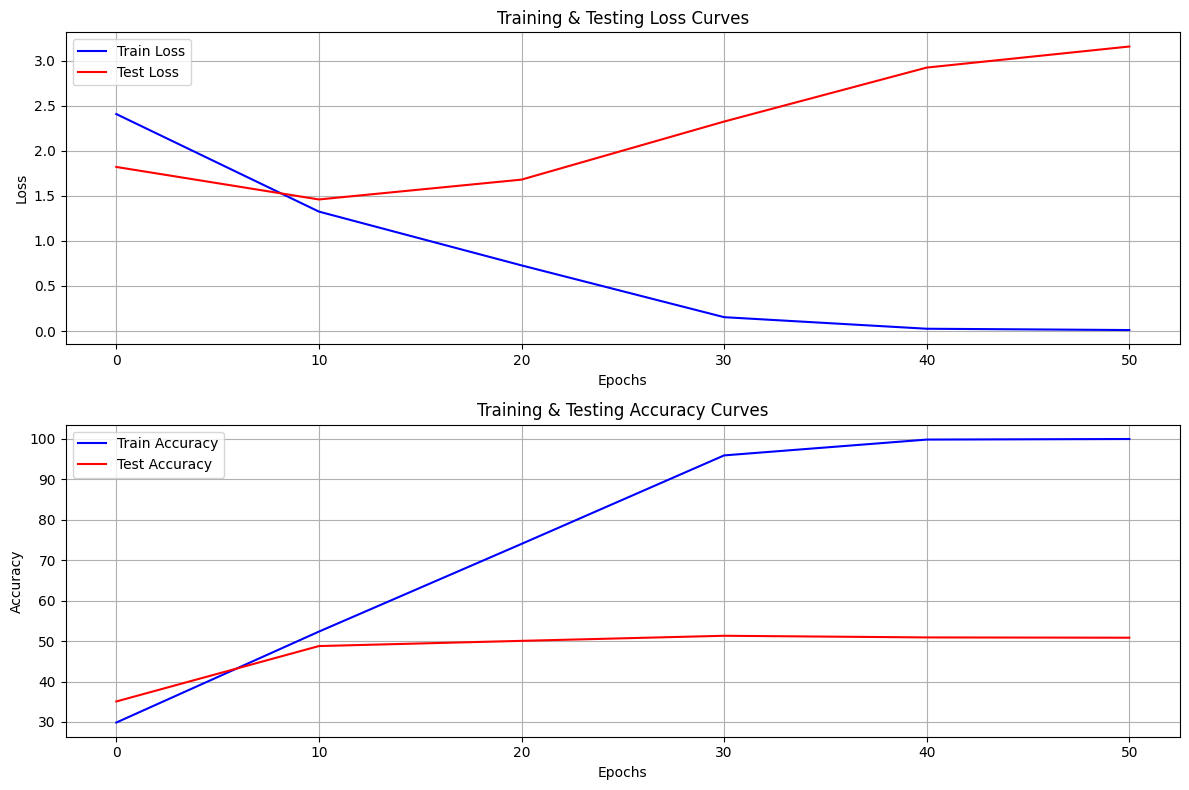

In [72]:
plot_loss_acc_curves(epoch_count, loss_values, test_loss_values, acc_values, test_acc_values)

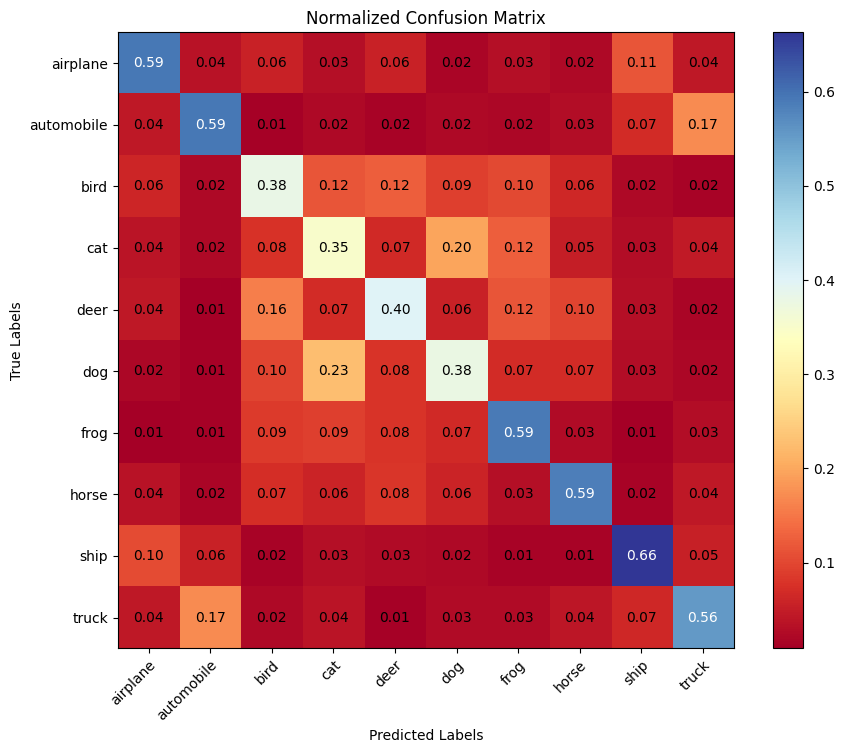

In [81]:
y_predictions = predict(model_scheduler_2, test_dataloader)
confusion_matrix(label_names, y_predictions, y_test_tensor)

Παρατηρούμε πως με την αύξηση του πλήθους των νευρώνων, έχουμε πιο γρήγορα το πρόβλημα της υπερ-προσαρμογής(όπως και προηγουμένως δηλαδή) άρα συμπεραίνουμε και εδώ πως αυτός ο τρόπος δεν είναι αποτελεσματικός για να εξαλείψουμε το φαινόμενο της υπερ-προσαρμογής. Συνεπώς, η λύση θα ήταν να χρησιμοποιήσουμε το μοντέλο `CIFARClassifierRELUV2` το οποίο εισάγει και την λογική του `nn.Dropout` ενώ επίσης θα μπορούσαμε να βάλουμε και μεγαλύτερο μέγεθος για **batch**.

In [75]:
model_scheduler_3 = CIFARClassifierRELUV2(in_features=X_train_tensor.shape[1], out_features=10, hidden_units=500).to(device)
train_dataloader, test_dataloader = batch_creation(X_train_tensor, X_test_tensor, y_train_tensor, y_test_tensor, 32)
loss_fn, optimizer, scheduler = loss_optimizer(model=model_scheduler_3, lr=0.0012, momentum=0.7, scheduler_on=True, Adam=False)
epochs = 101
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epoch_count = []
loss_values = []
test_loss_values = []
acc_values = []
test_acc_values = []
start = time.time()
for epoch in range(epochs):
    train_loss = 0
    train_acc  = 0
    test_loss  = 0
    test_acc   = 0
    for batch, (X, y) in enumerate(train_dataloader):
        ### Training
        model_scheduler_3.train()

        # Forward Pass
        y_logits = model_scheduler_3(X)
        y_preds  = torch.softmax(y_logits, dim=1).argmax(dim=1)

        # Calculate the Loss and Accuracy
        loss = loss_fn(y_logits, y)
        train_loss += loss
        accuracy = accuracy_score(y_true=y, y_pred=y_preds)
        train_acc  += accuracy

        # Zero the gradients
        optimizer.zero_grad()

        # Loss Backward
        loss.backward()

        # Optimizer Step
        optimizer.step()

    train_loss /= len(train_dataloader)
    train_acc  /= len(train_dataloader)

    ### Testing
    model_scheduler_3.eval()
    with torch.inference_mode():
        for batch, (X, y) in enumerate(test_dataloader):
            test_logits = model_scheduler_3(X)
            test_preds  = torch.softmax(test_logits, dim=1).argmax(dim=1)

            test_loss += loss_fn(test_logits, y)
            test_acc  += accuracy_score(y_true=y, y_pred=test_preds)

        test_loss /= len(test_dataloader)
        test_acc  /= len(test_dataloader)

    # Advance the scheduler
    scheduler.step()
    #print(f'LR : {scheduler.get_last_lr()}')
    if epoch % 10 == 0:
        epoch_count.append(epoch)
        loss_values.append(train_loss.item())
        test_loss_values.append(test_loss.item())
        acc_values.append(train_acc)
        test_acc_values.append(test_acc)
        print(f"Epoch {epoch} | Loss : {train_loss:.5f} | Accuracy : {train_acc:.2f}% | Test Loss : {test_loss:.5f} | Test Accuracy : {test_acc:.2f}%")

end = time.time()

print(f'Total Execution time : {end-start:.3f} seconds')

Epoch 0 | Loss : 2.43754 | Accuracy : 9.98% | Test Loss : 2.30254 | Test Accuracy : 9.96%
Epoch 10 | Loss : 2.02444 | Accuracy : 22.96% | Test Loss : 2.00542 | Test Accuracy : 29.32%
Epoch 20 | Loss : 1.85955 | Accuracy : 31.43% | Test Loss : 1.92518 | Test Accuracy : 34.00%
Epoch 30 | Loss : 1.77619 | Accuracy : 35.43% | Test Loss : 1.85958 | Test Accuracy : 36.63%
Epoch 40 | Loss : 1.74483 | Accuracy : 36.08% | Test Loss : 1.81155 | Test Accuracy : 37.28%
Epoch 50 | Loss : 1.71670 | Accuracy : 37.51% | Test Loss : 1.78255 | Test Accuracy : 40.44%
Epoch 60 | Loss : 1.69617 | Accuracy : 38.80% | Test Loss : 1.77312 | Test Accuracy : 38.99%
Epoch 70 | Loss : 1.67892 | Accuracy : 39.03% | Test Loss : 1.75358 | Test Accuracy : 40.29%
Epoch 80 | Loss : 1.67049 | Accuracy : 39.63% | Test Loss : 1.73782 | Test Accuracy : 41.97%
Epoch 90 | Loss : 1.66229 | Accuracy : 40.04% | Test Loss : 1.73653 | Test Accuracy : 41.83%
Epoch 100 | Loss : 1.65920 | Accuracy : 40.34% | Test Loss : 1.73322 | Te

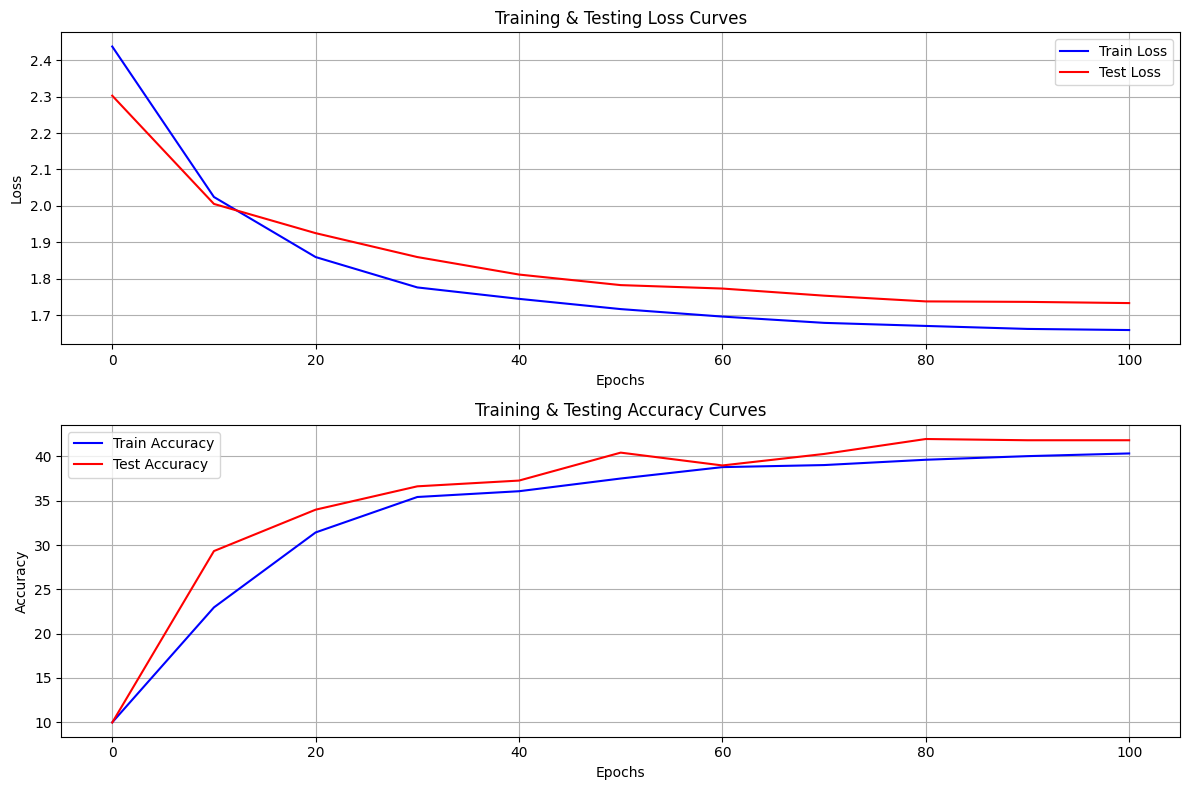

In [76]:
plot_loss_acc_curves(epoch_count, loss_values, test_loss_values, acc_values, test_acc_values)

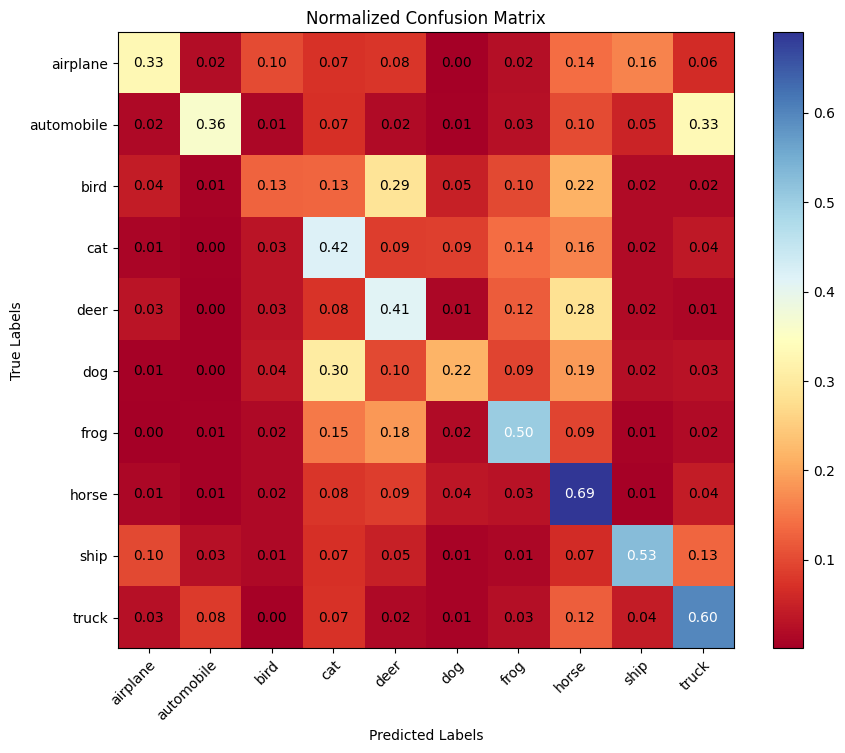

In [82]:
y_predictions = predict(model_scheduler_3, test_dataloader)
confusion_matrix(label_names, y_predictions, y_test_tensor)

Παρατηρούμε πως με αυτό τον τρόπο κατορθώσαμε να αποφύγουμε το πρόβλημα της υπερ-προσαρμογής. Ωστόσο, δεν κατορθώνουμε να επιτύχουμε πολύ υψηλά ποσοστά ακρίβειας καθώς φτάνουμε μόλις μέχρι το **40%**. Παρόλα αυτά, ένας τρόπος με τον οποίο θα μπορούσαμε να αυξήσουμε την ακρίβεια ενώ παράλληλα να αποφύγουμε και την περίπτωση του overfitting, θα ήταν να βάλουμε όπως και προηγουμένως περισσότερους νευρώνες στα hidden layers αλλά ταυτόχρονα να αυξήσουμε και το μέγεθος του batch.

In [78]:
model_scheduler_4 = CIFARClassifierRELUV2(in_features=X_train_tensor.shape[1], out_features=10, hidden_units=1500).to(device)
train_dataloader, test_dataloader = batch_creation(X_train_tensor, X_test_tensor, y_train_tensor, y_test_tensor, 128)
loss_fn, optimizer, scheduler = loss_optimizer(model=model_scheduler_4, lr=0.0012, momentum=0.7, scheduler_on=True, Adam=False)
epochs = 101
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epoch_count = []
loss_values = []
test_loss_values = []
acc_values = []
test_acc_values = []
start = time.time()
for epoch in range(epochs):
    train_loss = 0
    train_acc  = 0
    test_loss  = 0
    test_acc   = 0
    for batch, (X, y) in enumerate(train_dataloader):
        ### Training
        model_scheduler_4.train()

        # Forward Pass
        y_logits = model_scheduler_4(X)
        y_preds  = torch.softmax(y_logits, dim=1).argmax(dim=1)

        # Calculate the Loss and Accuracy
        loss = loss_fn(y_logits, y)
        train_loss += loss
        accuracy = accuracy_score(y_true=y, y_pred=y_preds)
        train_acc  += accuracy

        # Zero the gradients
        optimizer.zero_grad()

        # Loss Backward
        loss.backward()

        # Optimizer Step
        optimizer.step()

    train_loss /= len(train_dataloader)
    train_acc  /= len(train_dataloader)

    ### Testing
    model_scheduler_4.eval()
    with torch.inference_mode():
        for batch, (X, y) in enumerate(test_dataloader):
            test_logits = model_scheduler_4(X)
            test_preds  = torch.softmax(test_logits, dim=1).argmax(dim=1)

            test_loss += loss_fn(test_logits, y)
            test_acc  += accuracy_score(y_true=y, y_pred=test_preds)

        test_loss /= len(test_dataloader)
        test_acc  /= len(test_dataloader)

    # Advance the scheduler
    scheduler.step()
    #print(f'LR : {scheduler.get_last_lr()}')
    if epoch % 10 == 0:
        epoch_count.append(epoch)
        loss_values.append(train_loss.item())
        test_loss_values.append(test_loss.item())
        acc_values.append(train_acc)
        test_acc_values.append(test_acc)
        print(f"Epoch {epoch} | Loss : {train_loss:.5f} | Accuracy : {train_acc:.2f}% | Test Loss : {test_loss:.5f} | Test Accuracy : {test_acc:.2f}%")

end = time.time()

print(f'Total Execution time : {end-start:.3f} seconds')

Epoch 0 | Loss : 2.86287 | Accuracy : 10.15% | Test Loss : 2.30242 | Test Accuracy : 9.96%
Epoch 10 | Loss : 2.10880 | Accuracy : 19.56% | Test Loss : 2.07554 | Test Accuracy : 19.94%
Epoch 20 | Loss : 1.78640 | Accuracy : 35.18% | Test Loss : 1.73436 | Test Accuracy : 39.27%
Epoch 30 | Loss : 1.65283 | Accuracy : 40.70% | Test Loss : 1.62403 | Test Accuracy : 43.17%
Epoch 40 | Loss : 1.60498 | Accuracy : 42.67% | Test Loss : 1.58659 | Test Accuracy : 44.21%
Epoch 50 | Loss : 1.56132 | Accuracy : 44.27% | Test Loss : 1.56209 | Test Accuracy : 45.75%
Epoch 60 | Loss : 1.53925 | Accuracy : 44.99% | Test Loss : 1.52830 | Test Accuracy : 46.82%
Epoch 70 | Loss : 1.52161 | Accuracy : 45.51% | Test Loss : 1.51941 | Test Accuracy : 46.79%
Epoch 80 | Loss : 1.51252 | Accuracy : 46.15% | Test Loss : 1.50801 | Test Accuracy : 47.40%
Epoch 90 | Loss : 1.50276 | Accuracy : 46.04% | Test Loss : 1.50044 | Test Accuracy : 47.71%
Epoch 100 | Loss : 1.50130 | Accuracy : 46.19% | Test Loss : 1.49902 | T

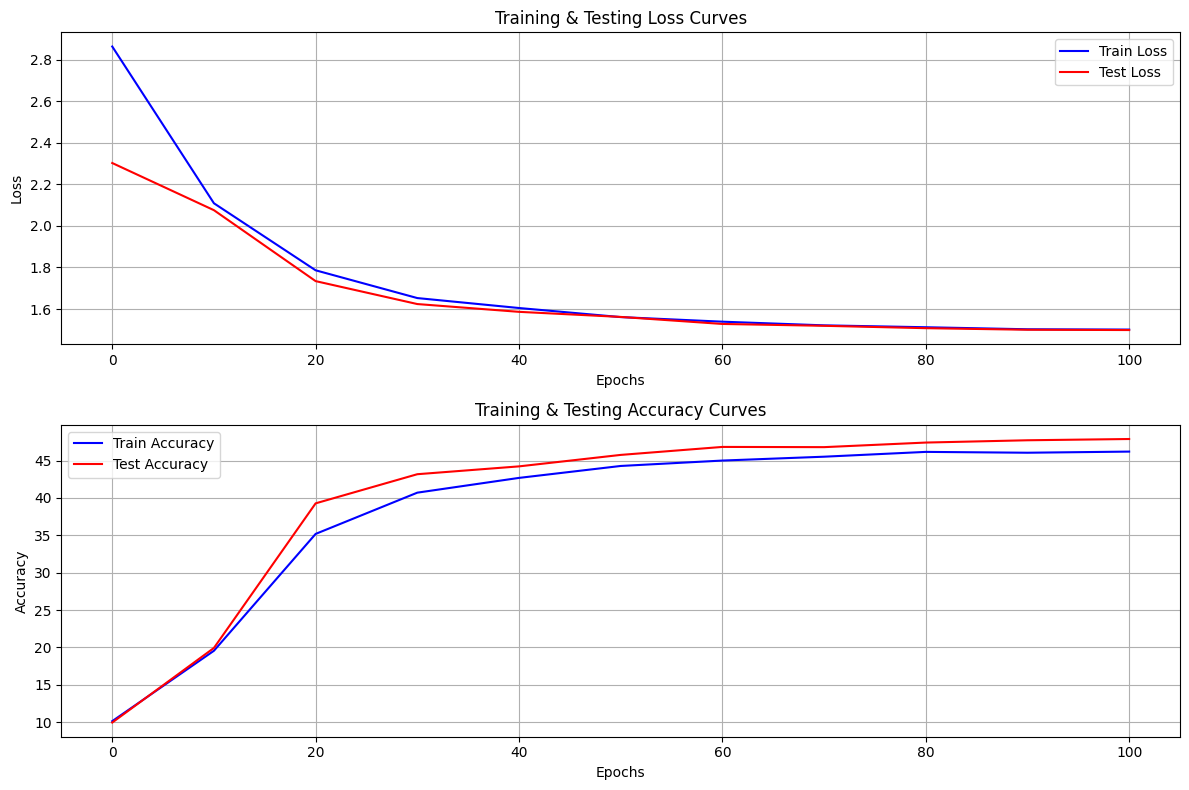

In [79]:
plot_loss_acc_curves(epoch_count, loss_values, test_loss_values, acc_values, test_acc_values)

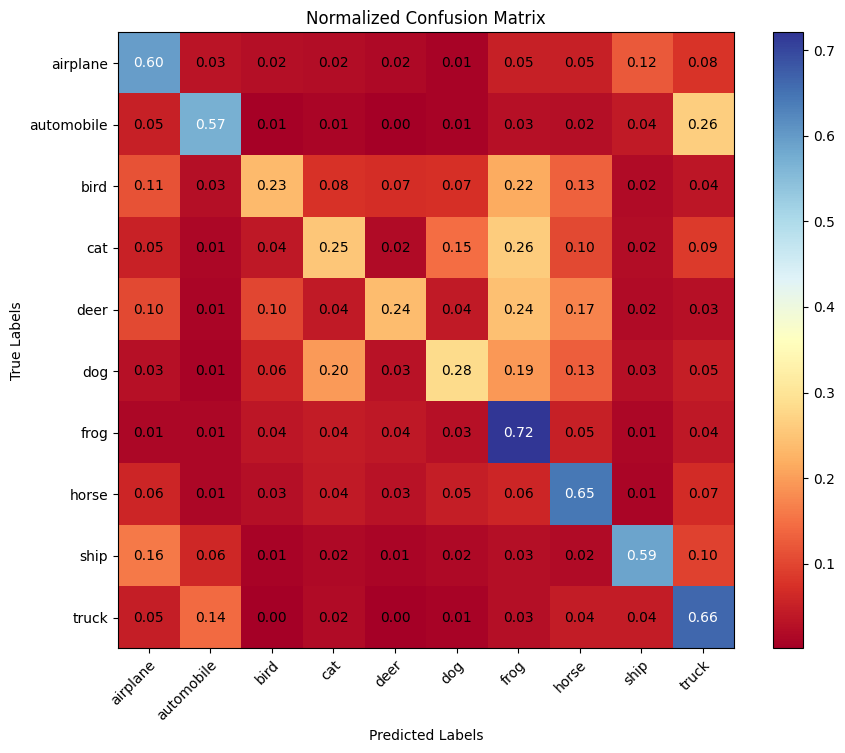

In [83]:
y_predictions = predict(model_scheduler_4, test_dataloader)
confusion_matrix(label_names, y_predictions, y_test_tensor)

Βλέπουμε πως αυτή η τροποποίηση που κάναμε, απέδωσε όντως και είχαμε πολύ καλύτερα αποτελέσματα στην ακρίβεια του μοντέλου μας. Άρα θεωρητικά με την αύξηση του πλήθους των νευρώνων θα κατορθώσουμε να επιτύχουμε καλύτερα αποτελέσματα στην ακρίβεια. Επίσης, μπορούμε να δούμε πως η χρήση του scheduler βοηθάει σημαντικά στην σύγκλιση καθότι μειώνει το learning rate γεγονός που συμβάλλει στην αποφυγή της υπερ-προσαρμογής. 

Τέλος, ας δοκιμάσουμε να βάλουμε 2500 νευρώνες στα hidden layers κρατόντας πάλι το ίδιο batch size για να συγκρίνουμε τα αποτελέσματα.

In [84]:
model_scheduler_5 = CIFARClassifierRELUV2(in_features=X_train_tensor.shape[1], out_features=10, hidden_units=2500).to(device)
train_dataloader, test_dataloader = batch_creation(X_train_tensor, X_test_tensor, y_train_tensor, y_test_tensor, 128)
loss_fn, optimizer, scheduler = loss_optimizer(model=model_scheduler_5, lr=0.0012, momentum=0.7, scheduler_on=True, Adam=False)
epochs = 101
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epoch_count = []
loss_values = []
test_loss_values = []
acc_values = []
test_acc_values = []
start = time.time()
for epoch in range(epochs):
    train_loss = 0
    train_acc  = 0
    test_loss  = 0
    test_acc   = 0
    for batch, (X, y) in enumerate(train_dataloader):
        ### Training
        model_scheduler_5.train()

        # Forward Pass
        y_logits = model_scheduler_5(X)
        y_preds  = torch.softmax(y_logits, dim=1).argmax(dim=1)

        # Calculate the Loss and Accuracy
        loss = loss_fn(y_logits, y)
        train_loss += loss
        accuracy = accuracy_score(y_true=y, y_pred=y_preds)
        train_acc  += accuracy

        # Zero the gradients
        optimizer.zero_grad()

        # Loss Backward
        loss.backward()

        # Optimizer Step
        optimizer.step()

    train_loss /= len(train_dataloader)
    train_acc  /= len(train_dataloader)

    ### Testing
    model_scheduler_5.eval()
    with torch.inference_mode():
        for batch, (X, y) in enumerate(test_dataloader):
            test_logits = model_scheduler_5(X)
            test_preds  = torch.softmax(test_logits, dim=1).argmax(dim=1)

            test_loss += loss_fn(test_logits, y)
            test_acc  += accuracy_score(y_true=y, y_pred=test_preds)

        test_loss /= len(test_dataloader)
        test_acc  /= len(test_dataloader)

    # Advance the scheduler
    scheduler.step()
    #print(f'LR : {scheduler.get_last_lr()}')
    if epoch % 10 == 0:
        epoch_count.append(epoch)
        loss_values.append(train_loss.item())
        test_loss_values.append(test_loss.item())
        acc_values.append(train_acc)
        test_acc_values.append(test_acc)
        print(f"Epoch {epoch} | Loss : {train_loss:.5f} | Accuracy : {train_acc:.2f}% | Test Loss : {test_loss:.5f} | Test Accuracy : {test_acc:.2f}%")

end = time.time()

print(f'Total Execution time : {end-start:.3f} seconds')

Epoch 0 | Loss : 2.98650 | Accuracy : 9.48% | Test Loss : 2.30411 | Test Accuracy : 9.64%
Epoch 10 | Loss : 1.98241 | Accuracy : 27.57% | Test Loss : 1.95652 | Test Accuracy : 25.76%
Epoch 20 | Loss : 1.70917 | Accuracy : 38.02% | Test Loss : 1.72031 | Test Accuracy : 39.34%
Epoch 30 | Loss : 1.59548 | Accuracy : 42.46% | Test Loss : 1.61065 | Test Accuracy : 44.78%
Epoch 40 | Loss : 1.53836 | Accuracy : 44.74% | Test Loss : 1.55975 | Test Accuracy : 46.41%
Epoch 50 | Loss : 1.49328 | Accuracy : 46.56% | Test Loss : 1.53194 | Test Accuracy : 46.21%
Epoch 60 | Loss : 1.46077 | Accuracy : 47.57% | Test Loss : 1.50203 | Test Accuracy : 47.83%
Epoch 70 | Loss : 1.44491 | Accuracy : 48.36% | Test Loss : 1.47908 | Test Accuracy : 48.14%
Epoch 80 | Loss : 1.43049 | Accuracy : 48.77% | Test Loss : 1.47408 | Test Accuracy : 48.53%
Epoch 90 | Loss : 1.42286 | Accuracy : 49.09% | Test Loss : 1.46958 | Test Accuracy : 48.40%
Epoch 100 | Loss : 1.41832 | Accuracy : 49.13% | Test Loss : 1.46840 | Te

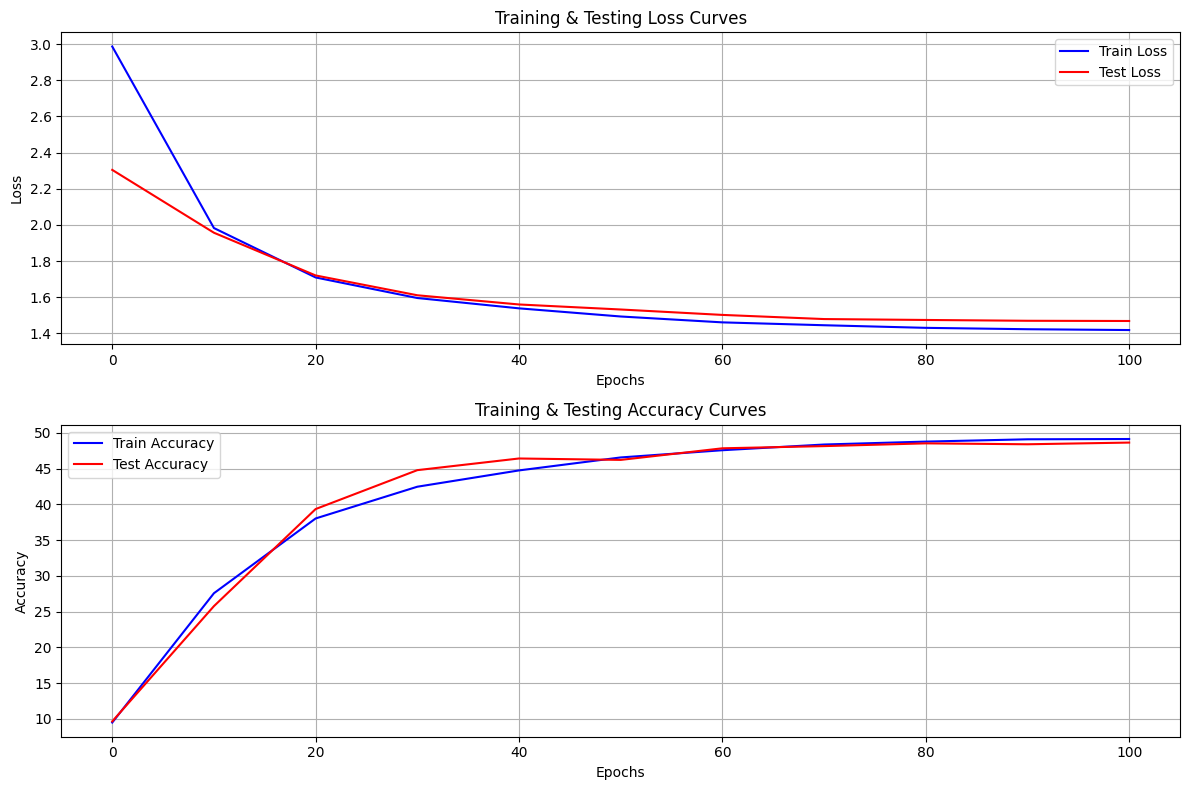

In [85]:
plot_loss_acc_curves(epoch_count, loss_values, test_loss_values, acc_values, test_acc_values)

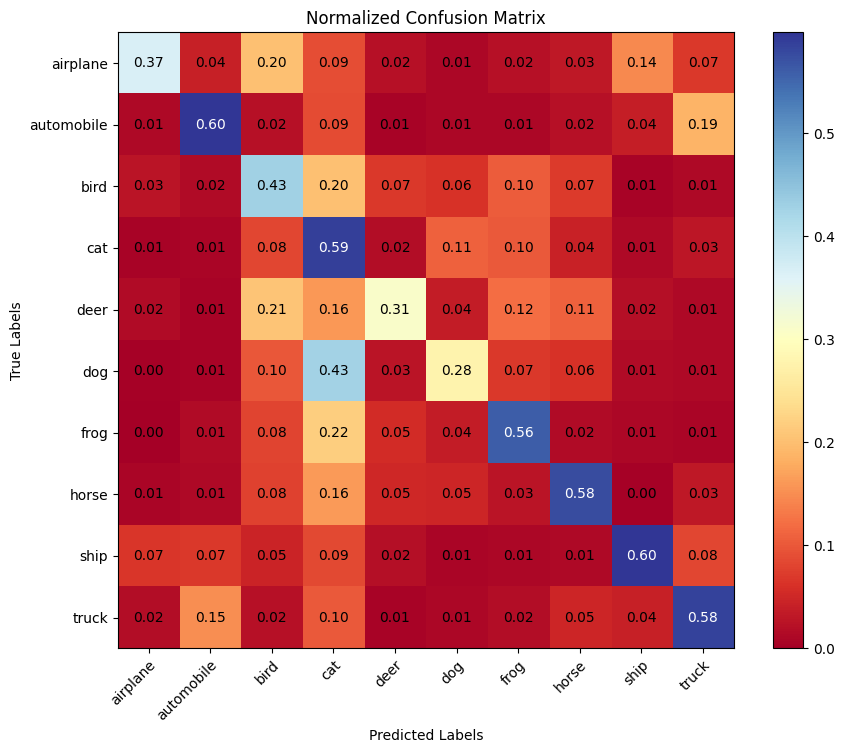

In [88]:
y_predictions = predict(model_scheduler_5, test_dataloader)
confusion_matrix(label_names, y_predictions, y_test_tensor)

Όπως και προηγουμένως, καταλήγουμε στο ίδιο συμπέρασμα. Επομένως η λογική μας έχει νόημα και ίσως άμα το τρέχαμε για περισσότερο να παίρναμε ακόμα καλύτερα αποτελέσματα. Ας δοκιμάσουμε τώρα να κρατήσουμε το ίδιο πλήθος νευρώνων στα hidden layers και ταυτόχρονα να αυξήσουμε το μέγεθος του batch για να δούμε άμα θα έχουμε κάποια περαιτέρω βελτίωση ή άμα το μοντέλο μας θα παραμείνει στα ίδια.

In [87]:
model_scheduler_6 = CIFARClassifierRELUV2(in_features=X_train_tensor.shape[1], out_features=10, hidden_units=2500).to(device)
train_dataloader, test_dataloader = batch_creation(X_train_tensor, X_test_tensor, y_train_tensor, y_test_tensor, 256)
loss_fn, optimizer, scheduler = loss_optimizer(model=model_scheduler_6, lr=0.0012, momentum=0.7, scheduler_on=True, Adam=False)
epochs = 101
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epoch_count = []
loss_values = []
test_loss_values = []
acc_values = []
test_acc_values = []
start = time.time()
for epoch in range(epochs):
    train_loss = 0
    train_acc  = 0
    test_loss  = 0
    test_acc   = 0
    for batch, (X, y) in enumerate(train_dataloader):
        ### Training
        model_scheduler_6.train()

        # Forward Pass
        y_logits = model_scheduler_6(X)
        y_preds  = torch.softmax(y_logits, dim=1).argmax(dim=1)

        # Calculate the Loss and Accuracy
        loss = loss_fn(y_logits, y)
        train_loss += loss
        accuracy = accuracy_score(y_true=y, y_pred=y_preds)
        train_acc  += accuracy

        # Zero the gradients
        optimizer.zero_grad()

        # Loss Backward
        loss.backward()

        # Optimizer Step
        optimizer.step()

    train_loss /= len(train_dataloader)
    train_acc  /= len(train_dataloader)

    ### Testing
    model_scheduler_6.eval()
    with torch.inference_mode():
        for batch, (X, y) in enumerate(test_dataloader):
            test_logits = model_scheduler_6(X)
            test_preds  = torch.softmax(test_logits, dim=1).argmax(dim=1)

            test_loss += loss_fn(test_logits, y)
            test_acc  += accuracy_score(y_true=y, y_pred=test_preds)

        test_loss /= len(test_dataloader)
        test_acc  /= len(test_dataloader)

    # Advance the scheduler
    scheduler.step()
    #print(f'LR : {scheduler.get_last_lr()}')
    if epoch % 10 == 0:
        epoch_count.append(epoch)
        loss_values.append(train_loss.item())
        test_loss_values.append(test_loss.item())
        acc_values.append(train_acc)
        test_acc_values.append(test_acc)
        print(f"Epoch {epoch} | Loss : {train_loss:.5f} | Accuracy : {train_acc:.2f}% | Test Loss : {test_loss:.5f} | Test Accuracy : {test_acc:.2f}%")

end = time.time()

print(f'Total Execution time : {end-start:.3f} seconds')

Epoch 0 | Loss : 3.48934 | Accuracy : 10.36% | Test Loss : 2.29238 | Test Accuracy : 12.12%
Epoch 10 | Loss : 1.93387 | Accuracy : 29.11% | Test Loss : 1.89809 | Test Accuracy : 29.98%
Epoch 20 | Loss : 1.69009 | Accuracy : 39.22% | Test Loss : 1.67747 | Test Accuracy : 38.96%
Epoch 30 | Loss : 1.58641 | Accuracy : 43.27% | Test Loss : 1.57843 | Test Accuracy : 43.75%
Epoch 40 | Loss : 1.53901 | Accuracy : 44.91% | Test Loss : 1.55753 | Test Accuracy : 44.87%
Epoch 50 | Loss : 1.50911 | Accuracy : 46.12% | Test Loss : 1.51650 | Test Accuracy : 46.64%
Epoch 60 | Loss : 1.48561 | Accuracy : 46.89% | Test Loss : 1.50304 | Test Accuracy : 47.29%
Epoch 70 | Loss : 1.47690 | Accuracy : 47.23% | Test Loss : 1.49738 | Test Accuracy : 46.61%
Epoch 80 | Loss : 1.46282 | Accuracy : 47.70% | Test Loss : 1.48516 | Test Accuracy : 47.41%
Epoch 90 | Loss : 1.45505 | Accuracy : 48.07% | Test Loss : 1.47779 | Test Accuracy : 47.58%
Epoch 100 | Loss : 1.45442 | Accuracy : 48.43% | Test Loss : 1.47364 | 

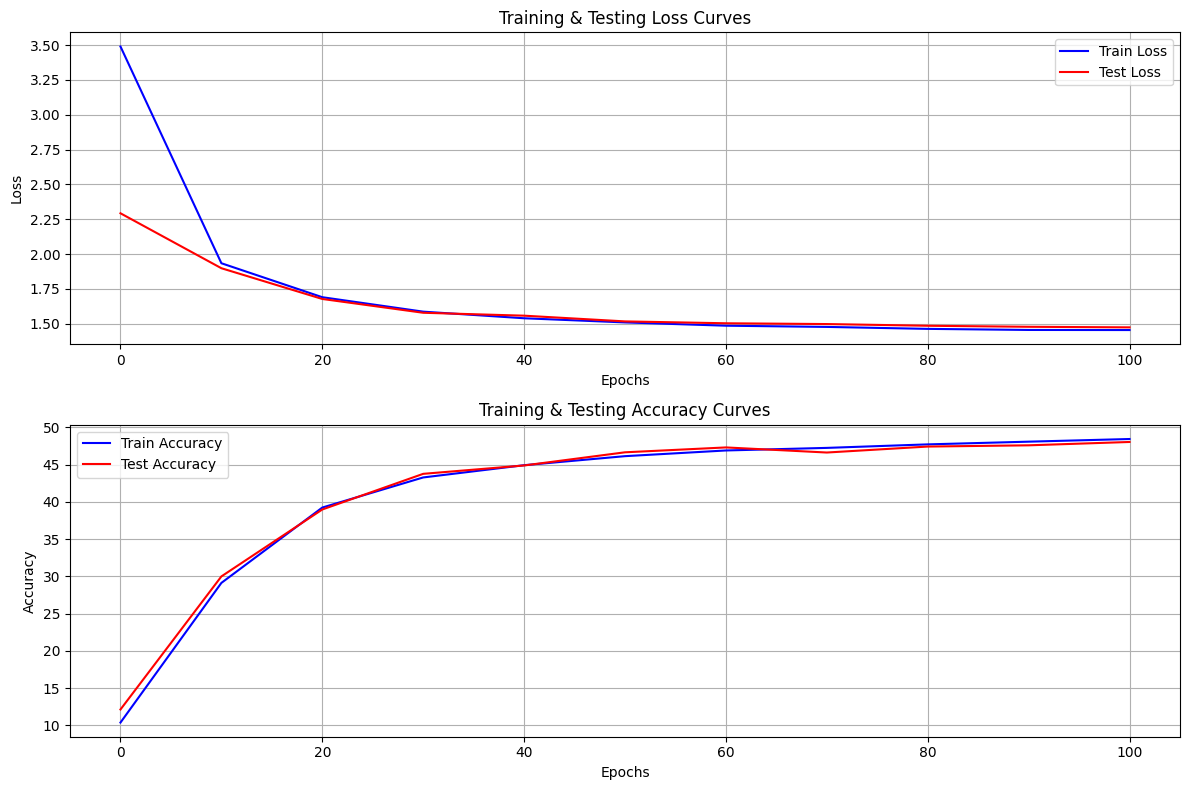

In [89]:
plot_loss_acc_curves(epoch_count, loss_values, test_loss_values, acc_values, test_acc_values)

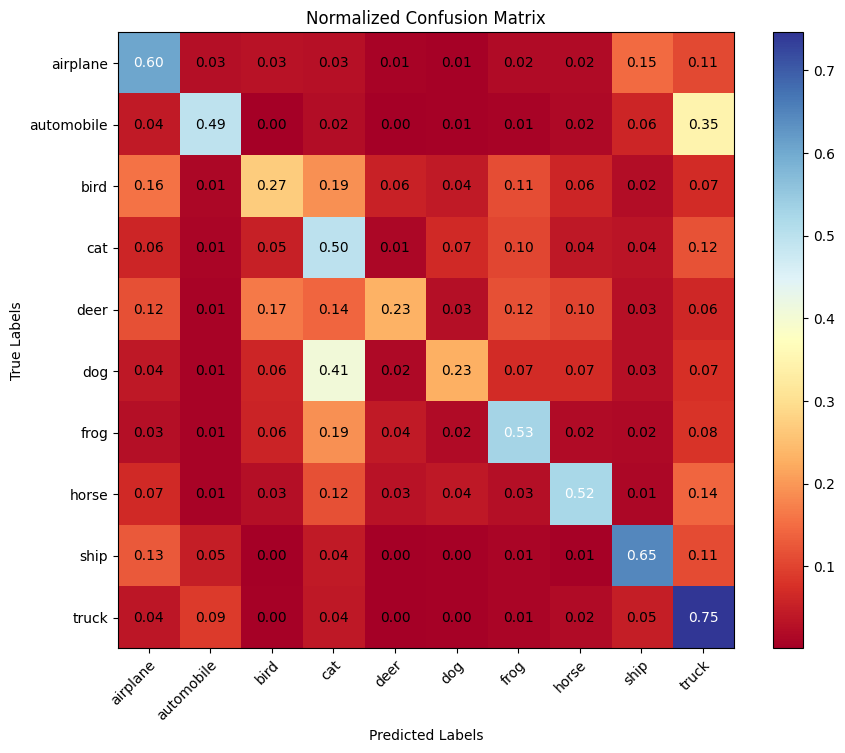

In [90]:
y_predictions = predict(model_scheduler_6, test_dataloader)
confusion_matrix(label_names, y_predictions, y_test_tensor)

Από τα παραπάνω βλέπουμε πως η βελτίωση που επέφερε αυτή η αλλαγή της υπερ-παραμέτρου δεν ήταν σημαντική, συνεπώς δεν έχει νόημα να συνεχίσουμε να αυξάνουμε το μέγεθος του batch. Ωστόσο, όπως και πριν παρατηρούμε πως ο scheduler βοηθάει σημαντικά στην σύγκλιση και στην αποφυγή του overfitting, άρα είναι κάτι που σίγουρα μπορούμε να το χρησιμοποιήοσυμε για να βελτιώσουμε τα μοντέλα μας.

## **Convolutional Neural Networks(CNNs)**

Από όλες τις παραπάνω δοκιμές παρατηρούμε πως το **Multilayer Perceptron(MLP)** δεν αποδίδει τόσο καλά όσο θα θέλαμε για να μπορέσουμε να ταξινομήσουμε όλες τις εικόνες στις κατάλληλες κλάσεις. Αυτό μας οδηγεί στο να αναζητήσουμε πιο *δυνατές* και πιο *κατάλληλες* τεχνικές που προτείνονται για την κατηγοροιοποίηση εικόνων. Μια από τις πιο συνηθισμένες, που προτείνεται στην βιβλιογραφία και συνίσταται για την αντιμετώπιση αυτού του προβλήματος, είναι η χρήση **συνελικτικού νευρωνικού δικτύο(CNN)**. 

Ειδικότερα, ο λόγος για τον οποίο προτείνεται είναι γιατί μπορεί να "συγκεντρώσει" καλύτερα την πληροφορία μιας εικόνας σε αντίθεση με ένα κλασσικό **MLP**. Συγκεκριμένα, αυτό οφείλεται στο τρόπο με τον οποίο λειτουργεί το συνελικτικό δίκτυο, ο οποίος, όπως τον έχω καταλάβει εγώ, είναι ο εξής : Το συνελικτικό δίκτυο εφαρμόζει μια συνελεκτική μάσκα, όπου τα στοιχεία αυτής της μάσκας είναι τα αντίστοιχα βάρη του δικτύου που ενημερώνονται σε κάθε epoch για να τονίσουν τα σημαντικότερα features της εικόνας, σε όλα τα pixels του κάθε colour channel της εικόνας. Με αυτό τον τρόπο δημιουργιούνται καινούργιες "εικόνες" στις οποίες τονίζονται τα feauters που μας ενδιαφέρουν κυρίως για το classification.

Αυτός ο τρόπος αποδίδει σαφώς καλύτερα σε αντίθεση με τα **MLP** διότι δεν θεωρεί την τιμή του κάθε pixel ανεξάρτητη από τα γειτονικά, αφού με την συνελικτική μάσκα λαμβάνεται υπόψη και η συνεισφορά των γειτονικών pixels.

Παρακάτω φαίνεται μια πρώτη υλοποίηση ενός συνελικτικού νευρωνικού δικτύου, όπου για συνάρτηση ενεργοποίσης έχει επιλεχθεί η `ReLU` καθότι είναι αύτη που προτείνεται κυρίως στην βιβλιογραφία και δίνει πολύ καλά αποτελέσματα για τους ίδιους λόγους τους οποίους ανέφερα προηγουμένως.

Τέλος, χρησιμοποιώντας τις εξής σχέσεις : 
$$
H_\text{out} = \left\lfloor \frac{H_\text{in} + 2 \times \text{padding}[0] - \text{dilation}[0] \times (\text{kernel\_size}[0] - 1) - 1}{\text{stride}[0]} + 1 \right\rfloor
$$

$$
W_\text{out} = \left\lfloor \frac{W_\text{in} + 2 \times \text{padding}[1] - \text{dilation}[1] \times (\text{kernel\_size}[1] - 1) - 1}{\text{stride}[1]} + 1 \right\rfloor
$$
οι οποίες βρίσκονται στο documentation της PyTorch(https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) μπορούμε να υπολογίσουμε πόσους νευρώνες θα έχουμε στο γραμμικό layer πριν την έξοδο.

In [19]:
class ConvolutionCIFAR(nn.Module):

    def __init__(self):
        super().__init__()

        self.conv_layer_1 = nn.Sequential(
            nn.Conv2d(3, 10,kernel_size=(3, 3), padding=0, stride=1),
            nn.ReLU(), # 10x30x30
            nn.Conv2d(10, 10, kernel_size=(3, 3), padding=0, stride=1),
            nn.ReLU(), # 10x28x28
            nn.MaxPool2d(kernel_size=(2, 2)) # 10x14x14
        )

        self.conv_layer_2 = nn.Sequential(
            nn.Conv2d(10, 10, kernel_size=(3, 3), padding=0, stride=1),
            nn.ReLU(), # 10x12x12
            nn.Conv2d(10, 10, kernel_size=(3, 3), padding=0, stride=1),
            nn.ReLU(),# 10x10x10
            nn.MaxPool2d(kernel_size=(2, 2)) # 10x5x5
        )

        self.linear_layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=250, out_features=10)
        )

    def forward(self, x):
        return self.linear_layer(self.conv_layer_2(self.conv_layer_1(x)))

Όπως βλέπουμε σε κάθε `Convolution Layer` υπάρχει στο τέλος μια συνάρτηση για pooling. Ειδικότερα, ο λόγος για τον οποίο βάζουμε μια τέτοια συνάρτηση μετά από κάθε layer είναι γιατί μειώνουν τις διαστάσεις των feature maps, που δημιουργoύνται μετά από κάθε layer(στην δικιά μου υλοποίηση μειώνουν τις διαστάσεις στο μισό λόγω του 2x2 kernel) κάνοντας με αυτό τον τρόπο πιο εύρωστο το νευρωνικό δίκτυο και δίνοντας του την δυνατότητα να μπορεί να μαθαίνει πιο "αφηρημένα" features από την εκάστοτε εικόνα.

Τέλος, στο τελευταίο επίπεδο, το οποίο είναι ένα γραμμικό, "συμπιέζουμε" τις εικόνες με αποτέλεσμα να οδηγηθούμε στον απλό perceptron και να πάρουμε μια απόφαση με βάση αυτόν.

Αρχικά προετοιμάζω τα δεδομένα ώστε να είναι σε μορφή εικόνων για να μπορέσω να τα δώσω στο νευρωνικό στο `forward pass`.

In [20]:
train_images_tensor = torch.from_numpy(train_images).to(device).type(torch.float32)
test_images_tensor  = torch.from_numpy(test_images).to(device).type(torch.float32)

train_images_permuted = train_images_tensor.permute((0, 3, 1, 2)) / 255.0
test_images_permuted = test_images_tensor.permute((0, 3, 1, 2)) / 255.0

train_images_permuted.shape, test_images_permuted.shape

(torch.Size([50000, 3, 32, 32]), torch.Size([10000, 3, 32, 32]))

In [ ]:
model_conv_1 = ConvolutionCIFAR().to(device)
train_dataloader, test_dataloader = batch_creation(train_images_permuted, test_images_permuted, y_train_tensor, y_test_tensor, 32)
loss_fn, optimizer, scheduler = loss_optimizer(model=model_conv_1, lr=0.001, momentum=0.7, scheduler_on=False, Adam=False)
epochs = 101
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epoch_count = []
loss_values = []
test_loss_values = []
acc_values = []
test_acc_values = []
start = time.time()
for epoch in range(epochs):
    train_loss = 0
    train_acc  = 0
    test_loss  = 0
    test_acc   = 0
    for batch, (X, y) in enumerate(train_dataloader):
        ### Training
        model_conv_1.train()

        # Forward Pass
        y_logits = model_conv_1(X)
        y_preds  = torch.softmax(y_logits, dim=1).argmax(dim=1)

        # Calculate the Loss and Accuracy
        loss = loss_fn(y_logits, y)
        train_loss += loss
        accuracy = accuracy_score(y_true=y, y_pred=y_preds)
        train_acc  += accuracy

        # Zero the gradients
        optimizer.zero_grad()

        # Loss Backward
        loss.backward()

        # Optimizer Step
        optimizer.step()

    train_loss /= len(train_dataloader)
    train_acc  /= len(train_dataloader)

    ### Testing
    model_conv_1.eval()
    with torch.inference_mode():
        for batch, (X, y) in enumerate(test_dataloader):
            test_logits = model_conv_1(X)
            test_preds  = torch.softmax(test_logits, dim=1).argmax(dim=1)

            test_loss += loss_fn(test_logits, y)
            test_acc  += accuracy_score(y_true=y, y_pred=test_preds)

        test_loss /= len(test_dataloader)
        test_acc  /= len(test_dataloader)

    if epoch % 10 == 0:
        epoch_count.append(epoch)
        loss_values.append(train_loss.item())
        test_loss_values.append(test_loss.item())
        acc_values.append(train_acc)
        test_acc_values.append(test_acc)
        print(f"Epoch {epoch} | Loss : {train_loss:.5f} | Accuracy : {train_acc:.2f}% | Test Loss : {test_loss:.5f} | Test Accuracy : {test_acc:.2f}%")

end = time.time()

print(f'Total Execution time : {end-start:.3f} seconds')

Epoch 0 | Loss : 2.30265 | Accuracy : 10.00% | Test Loss : 2.30231 | Test Accuracy : 10.01%
Epoch 10 | Loss : 1.74628 | Accuracy : 37.56% | Test Loss : 1.66508 | Test Accuracy : 41.09%
Epoch 20 | Loss : 1.39372 | Accuracy : 50.19% | Test Loss : 1.39270 | Test Accuracy : 50.11%
Epoch 30 | Loss : 1.25441 | Accuracy : 55.72% | Test Loss : 1.27060 | Test Accuracy : 54.83%
Epoch 40 | Loss : 1.16519 | Accuracy : 59.25% | Test Loss : 1.18998 | Test Accuracy : 58.11%
Epoch 50 | Loss : 1.08945 | Accuracy : 61.96% | Test Loss : 1.12766 | Test Accuracy : 60.46%
Epoch 60 | Loss : 1.03408 | Accuracy : 64.01% | Test Loss : 1.08803 | Test Accuracy : 61.87%
Epoch 70 | Loss : 0.99497 | Accuracy : 65.47% | Test Loss : 1.05247 | Test Accuracy : 63.53%
Epoch 80 | Loss : 0.96298 | Accuracy : 66.48% | Test Loss : 1.01124 | Test Accuracy : 65.43%
Epoch 90 | Loss : 0.93653 | Accuracy : 67.38% | Test Loss : 0.99626 | Test Accuracy : 65.80%
Epoch 100 | Loss : 0.91812 | Accuracy : 68.09% | Test Loss : 0.98744 | 

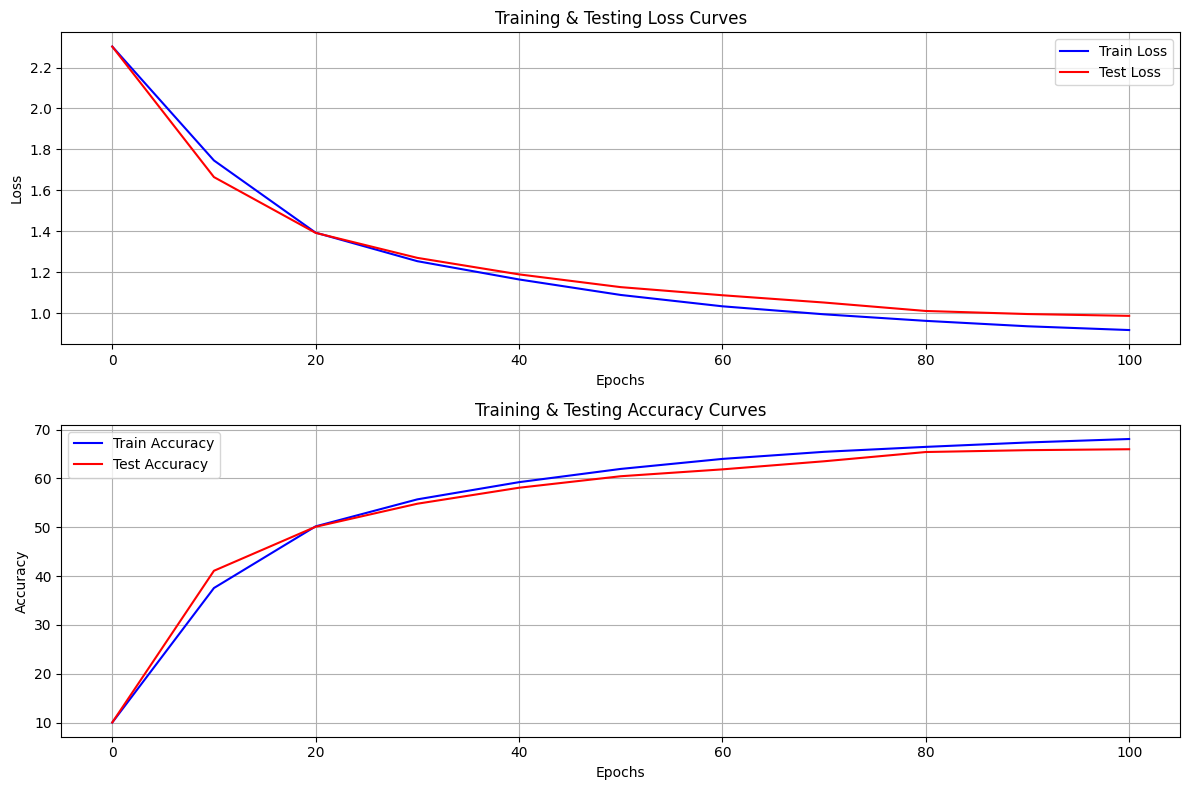

Model Saved Successfully


In [52]:
plot_loss_acc_curves(epoch_count, loss_values, test_loss_values, acc_values, test_acc_values)
save_model(model=model_conv_1, save_name='model_conv_1.pth')

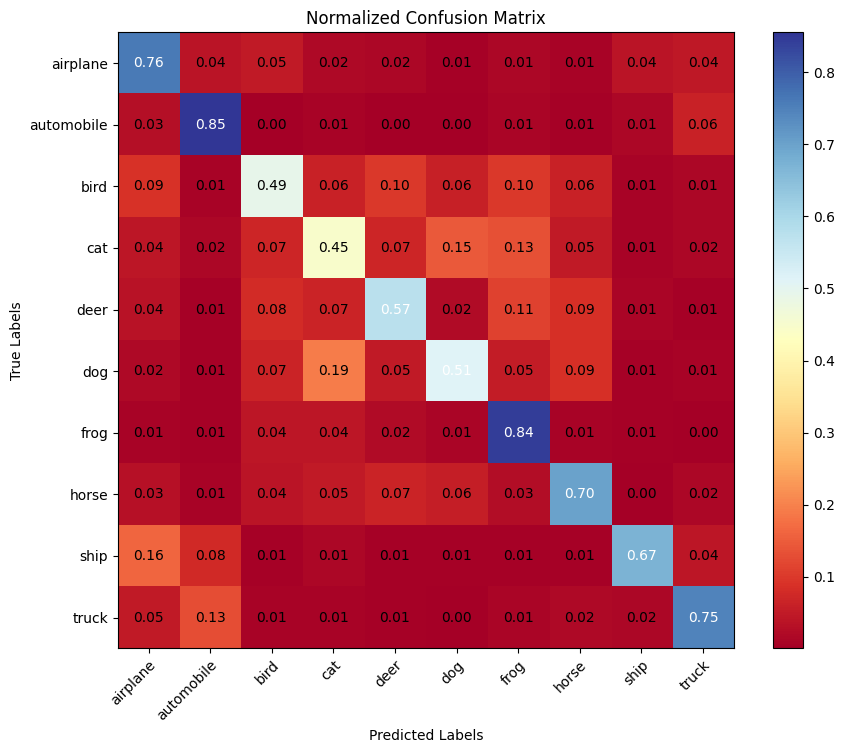

In [53]:
y_predictions = predict(model_conv_1, test_dataloader)
confusion_matrix(label_names, y_predictions, y_test_tensor)

Ήδη βλέπουμε πως το συνελικτικό νευρωνίκο δίκτυο έχει πολύ καλύτερη απόδοση από ότι το **MLP** που είχαμε υλοποιήσει προηγουμένως, κάτι το οποίο αναμέναμε λόγω των χαρακτηριστικών που έχει το συγκεκριμένο νευρωνικό να λαμβάνει καλύτερα την πληροφορία από τα pixels σε αντίθεση με το **MLP** που δεν λαμβάνει υπόψη του την συσχέτιση των γειτονικών pixels και τα θεωρεί όλα ανεξάρτητα.

Επομένως έχουμε φτάσει την ακρίβεια σε ένα πολύ καλό σημείο, ωστόσο ας προσπαθήσουμε να την αυξήσουμε λίγο ακόμα εισάγοντας στην υλοποίηση του νευρωνικού μας το batch normalization το οποίο είδαμε προηγουμένως πως βελτίωσε σημαντικά την ακρίβεια στο test sample.

In [21]:
class ConvolutionCIFARV2(nn.Module):

    def __init__(self):
        super().__init__()

        self.conv_layer_1 = nn.Sequential(
            nn.Conv2d(3, 10,kernel_size=(3, 3), padding=0, stride=1),
            nn.BatchNorm2d(10),
            nn.ReLU(), # 10x30x30
            nn.Conv2d(10, 10, kernel_size=(3, 3), padding=0, stride=1),
            nn.BatchNorm2d(10),
            nn.ReLU(), # 10x28x28
            nn.MaxPool2d(kernel_size=(2, 2)) # 10x14x14
        )

        self.conv_layer_2 = nn.Sequential(
            nn.Conv2d(10, 10, kernel_size=(3, 3), padding=0, stride=1),
            nn.BatchNorm2d(10),
            nn.ReLU(), # 10x12x12
            nn.Conv2d(10, 10, kernel_size=(3, 3), padding=0, stride=1),
            nn.BatchNorm2d(10),
            nn.ReLU(),# 10x10x10
            nn.MaxPool2d(kernel_size=(2, 2)) # 10x5x5
        )

        self.linear_layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=250, out_features=10)
        )

    def forward(self, x):
        return self.linear_layer(self.conv_layer_2(self.conv_layer_1(x)))

Σε αντίθεση όμως με προηγουμένως που τοποθετήσαμε τα batch normalizations μετά την συνάρτηση ενεργοποίσης(το οποίο έγινε για να "διορθώσουμε" τον κορεσμό που εισάγει η σιγμοειδής), εδώ πέρα τοποθετούμε τα batch normalizations πριν την συνάρτηση ενεργοποίησης γιατί βοηθάει στο να σταθεροποιήσουμε και να επιταχύνουμε την διαδικασία εκπαίδευσης καθότι όλα τα δεδομένα εκπαίδευσης έχουν κεντραριστεί στην "ενεργή" περιοχή της μη γραμμικής συνάρτησης ενεργοποίησης.

In [ ]:
model_conv_2 = ConvolutionCIFARV2().to(device)
train_dataloader, test_dataloader = batch_creation(train_images_permuted, test_images_permuted, y_train_tensor, y_test_tensor, 32)
loss_fn, optimizer, scheduler = loss_optimizer(model=model_conv_2, lr=0.001, momentum=0.7, scheduler_on=False, Adam=False)
epochs = 101
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epoch_count = []
loss_values = []
test_loss_values = []
acc_values = []
test_acc_values = []
start = time.time()
for epoch in range(epochs):
    train_loss = 0
    train_acc  = 0
    test_loss  = 0
    test_acc   = 0
    for batch, (X, y) in enumerate(train_dataloader):
        ### Training
        model_conv_2.train()

        # Forward Pass
        y_logits = model_conv_2(X)
        y_preds  = torch.softmax(y_logits, dim=1).argmax(dim=1)

        # Calculate the Loss and Accuracy
        loss = loss_fn(y_logits, y)
        train_loss += loss
        accuracy = accuracy_score(y_true=y, y_pred=y_preds)
        train_acc  += accuracy

        # Zero the gradients
        optimizer.zero_grad()

        # Loss Backward
        loss.backward()

        # Optimizer Step
        optimizer.step()

    train_loss /= len(train_dataloader)
    train_acc  /= len(train_dataloader)

    ### Testing
    model_conv_2.eval()
    with torch.inference_mode():
        for batch, (X, y) in enumerate(test_dataloader):
            test_logits = model_conv_2(X)
            test_preds  = torch.softmax(test_logits, dim=1).argmax(dim=1)

            test_loss += loss_fn(test_logits, y)
            test_acc  += accuracy_score(y_true=y, y_pred=test_preds)

        test_loss /= len(test_dataloader)
        test_acc  /= len(test_dataloader)

    if epoch % 10 == 0:
        epoch_count.append(epoch)
        loss_values.append(train_loss.item())
        test_loss_values.append(test_loss.item())
        acc_values.append(train_acc)
        test_acc_values.append(test_acc)
        print(f"Epoch {epoch} | Loss : {train_loss:.5f} | Accuracy : {train_acc:.2f}% | Test Loss : {test_loss:.5f} | Test Accuracy : {test_acc:.2f}%")

end = time.time()

print(f'Total Execution time : {end-start:.3f} seconds')

Epoch 0 | Loss : 1.72870 | Accuracy : 36.62% | Test Loss : 1.51746 | Test Accuracy : 44.04%
Epoch 10 | Loss : 1.01234 | Accuracy : 64.22% | Test Loss : 1.04853 | Test Accuracy : 63.11%
Epoch 20 | Loss : 0.91668 | Accuracy : 67.97% | Test Loss : 0.99092 | Test Accuracy : 65.13%
Epoch 30 | Loss : 0.87471 | Accuracy : 69.46% | Test Loss : 0.95879 | Test Accuracy : 66.76%
Epoch 40 | Loss : 0.85210 | Accuracy : 70.27% | Test Loss : 0.94595 | Test Accuracy : 66.92%
Epoch 50 | Loss : 0.83761 | Accuracy : 70.68% | Test Loss : 0.94911 | Test Accuracy : 66.48%
Epoch 60 | Loss : 0.82471 | Accuracy : 71.06% | Test Loss : 0.99758 | Test Accuracy : 64.92%
Epoch 70 | Loss : 0.81203 | Accuracy : 71.49% | Test Loss : 0.96229 | Test Accuracy : 66.73%
Epoch 80 | Loss : 0.80909 | Accuracy : 71.77% | Test Loss : 0.94454 | Test Accuracy : 66.70%
Epoch 90 | Loss : 0.79941 | Accuracy : 71.83% | Test Loss : 0.93690 | Test Accuracy : 67.19%
Epoch 100 | Loss : 0.79509 | Accuracy : 72.18% | Test Loss : 0.93607 | 

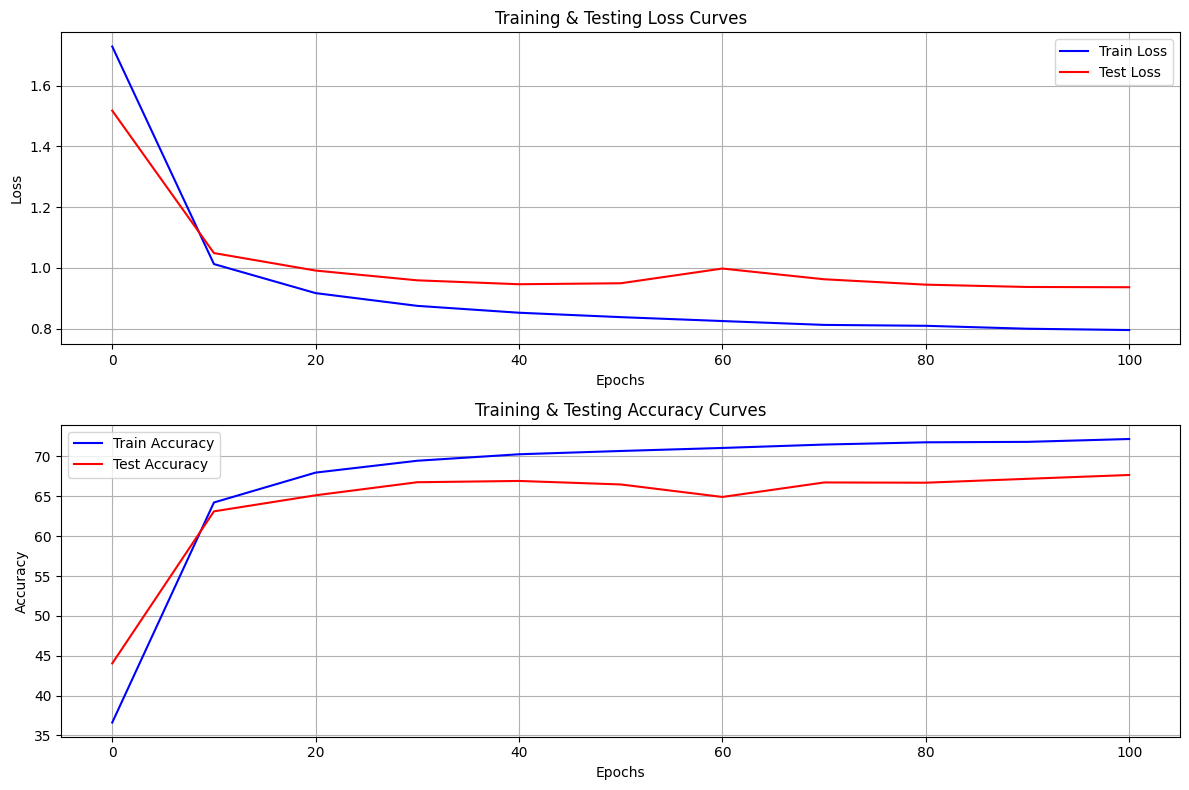

Model Saved Successfully


In [56]:
plot_loss_acc_curves(epoch_count, loss_values, test_loss_values, acc_values, test_acc_values)
save_model(model=model_conv_2, save_name='model_conv_2.pth')

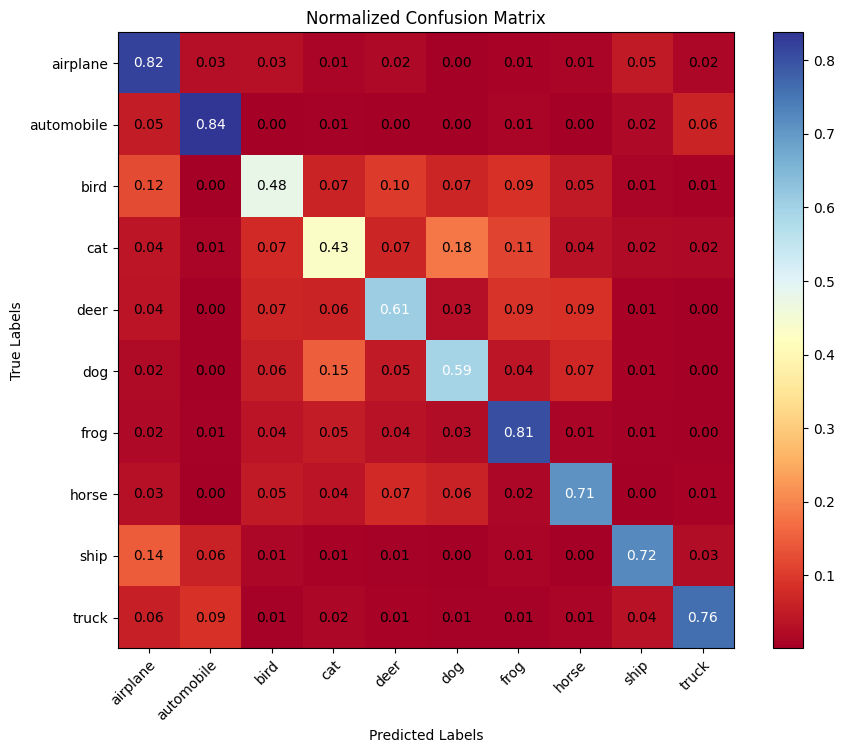

In [57]:
y_predictions = predict(model_conv_2, test_dataloader)
confusion_matrix(label_names, y_predictions, y_test_tensor)

Βλέπουμε πως με αυτή την τροποποίηση όντως κατορθώσαμε να επιτύχουμε καλύτερη ακρίβεια, ωστόσο βλέπουμε πως στα τελευταία epochs η ακρίβεια στα training samples αυξάνεται συνεχώς ενώ αντίθετα η ακρίβεια στα test samples φαίνεται να ταλαντώνεται. Αυτό ίσως να σημαίνει πως άμα το τρέξουμε για περισσότερα epochs να έχουμε το πρόβλημα της υπερ-προσαρμογής. Επομένως, για να το λύσουμε και αυτό όπως και προηγουμένως θα χρησιμοποιήσουμε και πάλι την μέθοδο `nn.Dropout` η οποία έχει ως αποτέλεσμα να μηδενίζει με μια πιθανότητα, που δέχεται ως όρισμα, ορισμένους νευρώνες του συγκεκριμένου layer.

In [22]:
class ConvolutionCIFARV3(nn.Module):

    def __init__(self):
        super().__init__()

        self.conv_layer_1 = nn.Sequential(
            nn.Conv2d(3, 10,kernel_size=(3, 3), padding=0, stride=1),
            nn.BatchNorm2d(10),
            nn.ReLU(), # 10x30x30
            nn.Conv2d(10, 10, kernel_size=(3, 3), padding=0, stride=1),
            nn.BatchNorm2d(10),
            nn.ReLU(), # 10x28x28
            nn.MaxPool2d(kernel_size=(2, 2)), # 10x14x14
            nn.Dropout(0.25)
        )

        self.conv_layer_2 = nn.Sequential(
            nn.Conv2d(10, 10, kernel_size=(3, 3), padding=0, stride=1),
            nn.BatchNorm2d(10),
            nn.ReLU(), # 10x12x12
            nn.Conv2d(10, 10, kernel_size=(3, 3), padding=0, stride=1),
            nn.BatchNorm2d(10),
            nn.ReLU(),# 10x10x10
            nn.MaxPool2d(kernel_size=(2, 2)), # 10x5x5
            nn.Dropout(0.25)
        )

        self.linear_layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=250, out_features=10)
        )

    def forward(self, x):
        return self.linear_layer(self.conv_layer_2(self.conv_layer_1(x)))

Επίσης, μιας και πλέον επαναλαμβάνουμε την ίδια ακριβώς διαδικασία για το training και για το validation, καλό θα ήταν να τα βάλουμε σε συναρτήσεις, για να μην έχουμε επαναλαμβανόμενο κώδικα. Η υλοποίηση τους φαίνεται παρακάτω.

In [23]:
def training(model, train_dataloader, loss_fn, optimizer):
    train_loss = 0
    train_acc  = 0
    for batch, (X, y) in enumerate(train_dataloader):
        model.train()

        y_logits = model(X)
        y_preds = torch.softmax(y_logits, dim=1).argmax(dim=1)

        loss = loss_fn(y_logits, y)
        acc  = accuracy_score(y_true=y, y_pred=y_preds)

        train_loss += loss
        train_acc  += acc

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

    train_loss /= len(train_dataloader)
    train_acc  /= len(train_dataloader)

    return train_loss, train_acc
def testing(model, test_dataloader, loss_fn):

    test_loss = 0
    test_acc  = 0
    model.eval()

    with torch.inference_mode():
        for batch, (X, y) in enumerate(test_dataloader):
            test_logits = model(X)
            test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)

            loss = loss_fn(test_logits, y)
            acc  = accuracy_score(y_true=y, y_pred=test_preds)

            test_loss += loss
            test_acc  += acc

        test_loss /= len(test_dataloader)
        test_acc  /= len(test_dataloader)

    return test_loss, test_acc

In [ ]:
model_conv_3 = ConvolutionCIFARV3().to(device)
train_dataloader, test_dataloader = batch_creation(train_images_permuted, test_images_permuted, y_train_tensor, y_test_tensor, 32)
loss_fn, optimizer, scheduler = loss_optimizer(model=model_conv_3, lr=0.001, momentum=0.7, scheduler_on=False, Adam=False)
epochs = 101
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epoch_count = []
loss_values = []
test_loss_values = []
acc_values = []
test_acc_values = []
start = time.time()
for epoch in range(epochs):
    train_loss, train_acc = training(model=model_conv_3, train_dataloader=train_dataloader, loss_fn=loss_fn, optimizer=optimizer)
    test_loss, test_acc   = testing(model=model_conv_3, test_dataloader=test_dataloader, loss_fn=loss_fn)

    if epoch % 10 == 0:
        epoch_count.append(epoch)
        loss_values.append(train_loss.item())
        test_loss_values.append(test_loss.item())
        acc_values.append(train_acc)
        test_acc_values.append(test_acc)
        print(f"Epoch {epoch} | Loss : {train_loss:.5f} | Accuracy : {train_acc:.2f}% | Test Loss : {test_loss:.5f} | Test Accuracy : {test_acc:.2f}%")

end = time.time()

print(f'Total Execution time : {end-start:.3f} seconds')

Epoch 0 | Loss : 1.83497 | Accuracy : 31.83% | Test Loss : 1.60200 | Test Accuracy : 42.18%
Epoch 10 | Loss : 1.22058 | Accuracy : 56.33% | Test Loss : 1.12738 | Test Accuracy : 60.27%
Epoch 20 | Loss : 1.15191 | Accuracy : 59.19% | Test Loss : 1.05270 | Test Accuracy : 62.60%
Epoch 30 | Loss : 1.10735 | Accuracy : 60.83% | Test Loss : 1.03439 | Test Accuracy : 63.29%
Epoch 40 | Loss : 1.08255 | Accuracy : 61.73% | Test Loss : 1.00715 | Test Accuracy : 65.14%
Epoch 50 | Loss : 1.06505 | Accuracy : 62.42% | Test Loss : 1.02119 | Test Accuracy : 63.19%
Epoch 60 | Loss : 1.05241 | Accuracy : 62.74% | Test Loss : 1.02739 | Test Accuracy : 63.31%
Epoch 70 | Loss : 1.04028 | Accuracy : 63.27% | Test Loss : 0.95254 | Test Accuracy : 66.12%
Epoch 80 | Loss : 1.03600 | Accuracy : 63.32% | Test Loss : 0.94076 | Test Accuracy : 66.71%
Epoch 90 | Loss : 1.02089 | Accuracy : 63.94% | Test Loss : 0.93064 | Test Accuracy : 67.34%
Epoch 100 | Loss : 1.01835 | Accuracy : 64.20% | Test Loss : 0.95030 | 

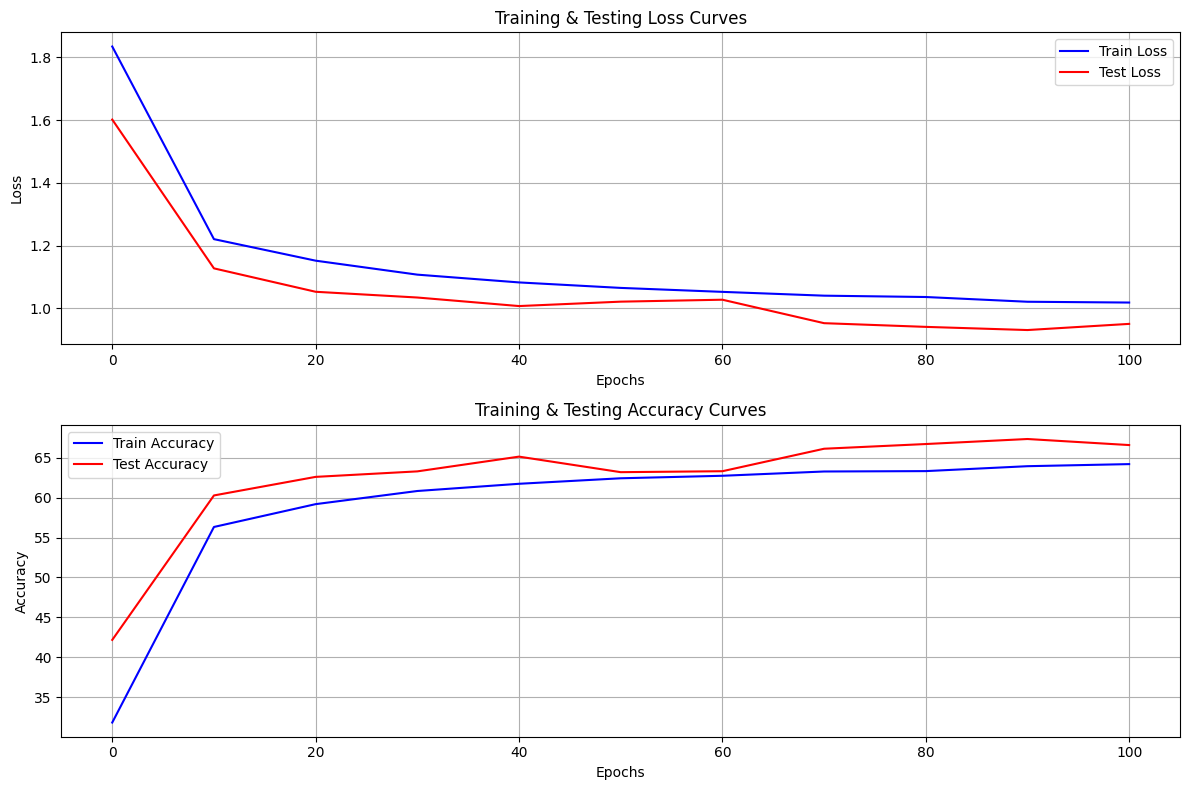

Model Saved Successfully


In [61]:
plot_loss_acc_curves(epoch_count, loss_values, test_loss_values, acc_values, test_acc_values)
save_model(model=model_conv_3, save_name='model_conv_3.pth')

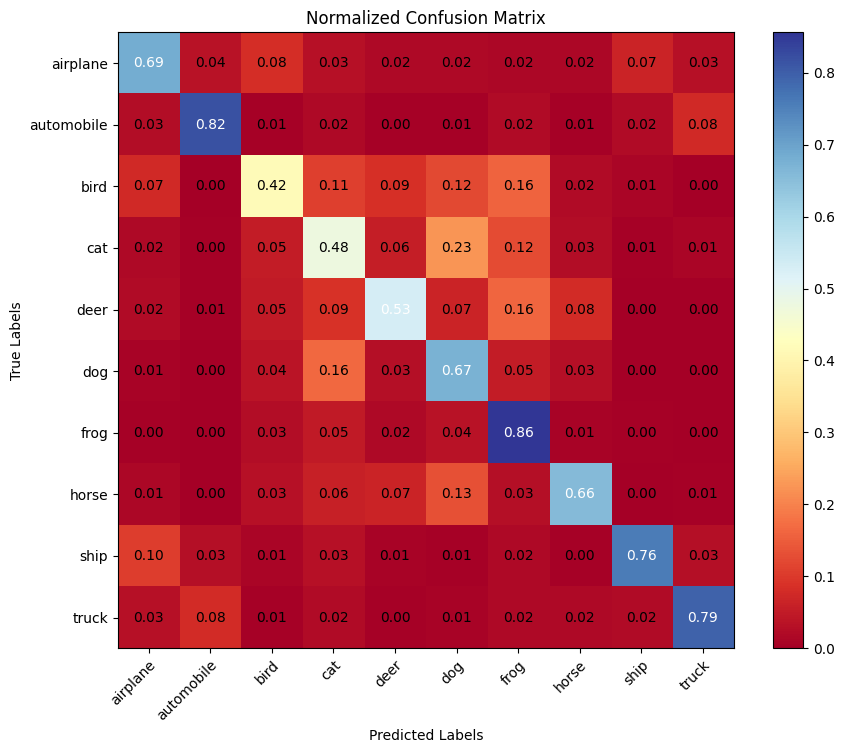

In [62]:
y_predictions = predict(model_conv_3, test_dataloader)
confusion_matrix(label_names, y_predictions, y_test_tensor)

Από τα παραπάνω βλέπουμε πως τώρα είχαμε μια μικρή αύξηση στην ακρίβεια των testing samples αλλά στο στάδιο της εκπαίδευσης δεν τα πήγαμε τόσο κάλα όπως προηγουμένως. Συνεπώς, ας δοκιμάσουμε να προσθέσουμε περισσότερους νευρώνες στα layers για να μπορέσουμε να πάρουμε καλύτερα αποτελέσματα και στο στάδιο του training αλλά και στο στάδιο του testing.

Επομένως, τροποποιούμε το νευρωνικό δίκτυο ως εξής : 

In [24]:
class ConvolutionCIFARV4(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv_layer_1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(32), # 32x32x32
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(32), # 32x32x32
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(32), # 32x32x32 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2)), # 32x16x16
            nn.Dropout(0.25)
        )

        self.conv_layer_2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(64), # 64x16x16
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(64), # 64x16x16
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2)), # 64x8x8
            nn.Dropout(0.25)
        )

        self.linear_layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=64 * 8 * 8, out_features=128), 
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features=128, out_features=10)  # Output layer for 10 classes
        )

    def forward(self, x):
        x = self.conv_layer_1(x)
        x = self.conv_layer_2(x)
        x = self.linear_layer(x)
        return x

Πέρα από την προσθήκη περισσότερων νευρώνων στα hidden layers, πρόσθεσα και περισσότερα Convolutional layers, ενώ ακόμα πρόσθεσα ένα επιπλέον γραμμικό επίπεδο πριν την έξοδο. Με αυτό τον τρόπο, κάνω αρκετά πιο σύνθετο το νευρωνικό μου δίκτυο και άρα θεωρώ πως θα μπορέσει να αποδόσει καλύτερα και να λάβω πολύ καλά αποτελέσματα και στο test sample.

In [ ]:
model_conv_4 = ConvolutionCIFARV4().to(device)
train_dataloader, test_dataloader = batch_creation(train_images_permuted, test_images_permuted, y_train_tensor, y_test_tensor, 32)
loss_fn, optimizer, scheduler = loss_optimizer(model=model_conv_4, lr=0.001, momentum=0.7, scheduler_on=False, Adam=False)
epochs = 101
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epoch_count = []
loss_values = []
test_loss_values = []
acc_values = []
test_acc_values = []
start = time.time()
for epoch in range(epochs):
    train_loss, train_acc = training(model=model_conv_4, train_dataloader=train_dataloader, loss_fn=loss_fn, optimizer=optimizer)
    test_loss, test_acc   = testing(model=model_conv_4, test_dataloader=test_dataloader, loss_fn=loss_fn)

    if epoch % 10 == 0:
        epoch_count.append(epoch)
        loss_values.append(train_loss.item())
        test_loss_values.append(test_loss.item())
        acc_values.append(train_acc)
        test_acc_values.append(test_acc)
        print(f"Epoch {epoch} | Loss : {train_loss:.5f} | Accuracy : {train_acc:.2f}% | Test Loss : {test_loss:.5f} | Test Accuracy : {test_acc:.2f}%")

end = time.time()

print(f'Total Execution time : {end-start:.3f} seconds')

Epoch 0 | Loss : 1.70603 | Accuracy : 36.68% | Test Loss : 1.33597 | Test Accuracy : 52.06%
Epoch 10 | Loss : 0.82689 | Accuracy : 70.93% | Test Loss : 0.75580 | Test Accuracy : 73.17%
Epoch 20 | Loss : 0.67000 | Accuracy : 76.59% | Test Loss : 0.66412 | Test Accuracy : 76.62%
Epoch 30 | Loss : 0.56625 | Accuracy : 80.28% | Test Loss : 0.58811 | Test Accuracy : 79.31%
Epoch 40 | Loss : 0.50515 | Accuracy : 82.39% | Test Loss : 0.57765 | Test Accuracy : 79.71%
Epoch 50 | Loss : 0.44425 | Accuracy : 84.11% | Test Loss : 0.55038 | Test Accuracy : 81.08%
Epoch 60 | Loss : 0.40485 | Accuracy : 85.71% | Test Loss : 0.50708 | Test Accuracy : 82.95%
Epoch 70 | Loss : 0.37276 | Accuracy : 86.60% | Test Loss : 0.51374 | Test Accuracy : 82.87%
Epoch 80 | Loss : 0.34333 | Accuracy : 87.79% | Test Loss : 0.51622 | Test Accuracy : 82.86%
Epoch 90 | Loss : 0.31312 | Accuracy : 88.77% | Test Loss : 0.49517 | Test Accuracy : 83.72%
Epoch 100 | Loss : 0.29210 | Accuracy : 89.53% | Test Loss : 0.52284 | 

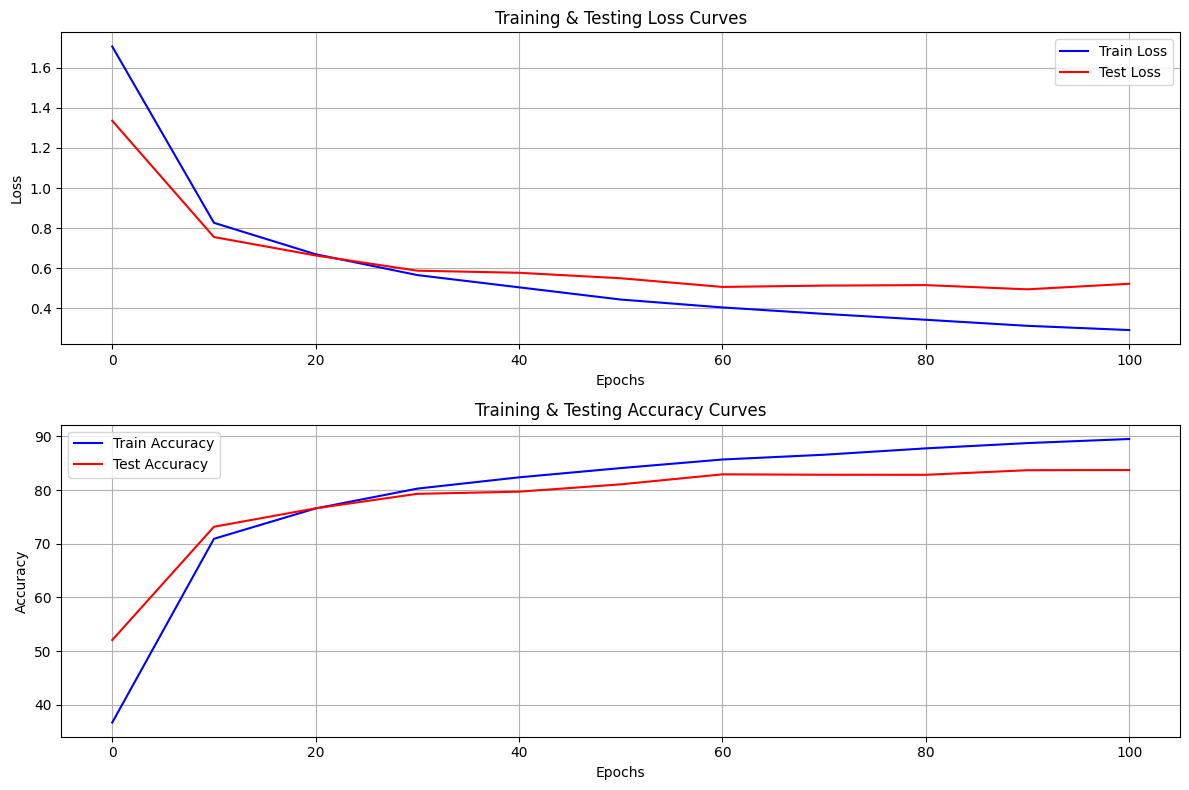

Model Saved Successfully


In [65]:
plot_loss_acc_curves(epoch_count, loss_values, test_loss_values, acc_values, test_acc_values)
save_model(model=model_conv_4, save_name='model_conv_4.pth')

Όπως βλέπουμε το παραπάνω μοντέλο απέδωσε πολύ καλά φτάνοντας σε ποσοστό ακρίβειας το 84% στα test samples, κάτι που σημαίνει ότι πραγματοποιεί με μεγάλη επιτυχία την ταξινόμηση και άρα είναι το καλύτερο που έχουμε καταφέρει να επιτύγχουμε μέχρι στιγμής. Ο λόγος για τον οποίο το μοντέλο μας απέδωσε τόσο καλά είναι επειδή ενσωματάσωμε όλες τις τεχνικές που είδαμε ότι μας βοήθησαν προηγουμένως, όπως το batch normalization, το `nn.Dropout`, την χρήση της συνάρτησης ενεργοποίησης `ReLU` που δεν οδηγεί σε **vanishing gradients** σε αντίθεση με την σιγμοειδή και τέλος την εισαγωγή περισσότερων νευρώνων στα κρυφά επίπεδα.

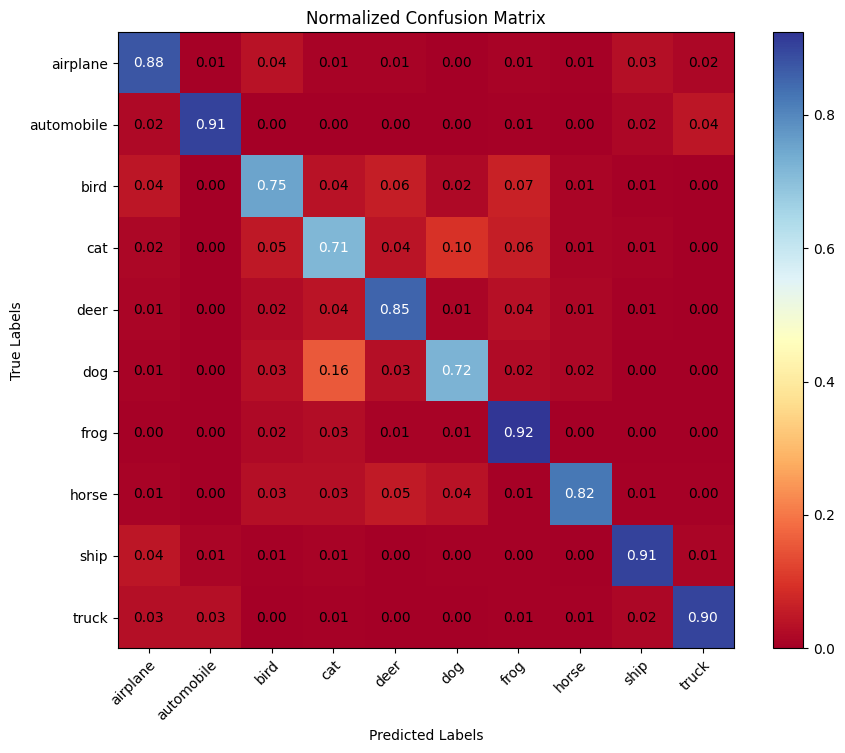

In [66]:
y_predictions = predict(model_conv_4, test_dataloader)
confusion_matrix(label_names, y_predictions, y_test_tensor)

Εφόσον βρήκαμε το συνελικτικό μοντέλο το οποίο αποδίδει καλύτερα, ας δοκιμάσουμε να χρησιμοποιήσουμε και scheduler για να δούμε άμα θα κατορθώσουμε να αυξήσουμε περαιτέρω το ποσοστό ακρίβειας του στο test sample ή αν θα μας οδηγήσει στο πρόβλημα του overfitting. Ο scheduler που χρησιμοποιούμε και εδώ είναι ο ίδιος με προηγουμένως, δηλαδή ο `StepLR()` ο οποίος μετά από ένα συγκεκριμένο αριθμό από epochs, το οποίο το ορίζουμε εμείς, μειώνει το learning rate κατά έναν παράγοντα τον οποίο τον ορίζουμε εμείς.

In [31]:
model_conv_scheduler = ConvolutionCIFARV4().to(device)
train_dataloader, test_dataloader = batch_creation(train_images_permuted, test_images_permuted, y_train_tensor, y_test_tensor, 32)
loss_fn, optimizer, scheduler = loss_optimizer(model=model_conv_scheduler, lr=0.001, momentum=0.7, scheduler_on=True, Adam=False)
epochs = 101
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epoch_count = []
loss_values = []
test_loss_values = []
acc_values = []
test_acc_values = []
start = time.time()
for epoch in range(epochs):
    train_loss, train_acc = training(model=model_conv_scheduler, train_dataloader=train_dataloader, loss_fn=loss_fn, optimizer=optimizer)
    test_loss, test_acc   = testing(model=model_conv_scheduler, test_dataloader=test_dataloader, loss_fn=loss_fn)
    scheduler.step()

    if epoch % 10 == 0:
        epoch_count.append(epoch)
        loss_values.append(train_loss.item())
        test_loss_values.append(test_loss.item())
        acc_values.append(train_acc)
        test_acc_values.append(test_acc)
        print(f"Epoch {epoch} | Loss : {train_loss:.5f} | Accuracy : {train_acc:.2f}% | Test Loss : {test_loss:.5f} | Test Accuracy : {test_acc:.2f}%")

end = time.time()

print(f'Total Execution time : {end-start:.3f} seconds')

Epoch 0 | Loss : 1.70895 | Accuracy : 36.55% | Test Loss : 1.35591 | Test Accuracy : 51.64%
Epoch 10 | Loss : 0.82336 | Accuracy : 71.06% | Test Loss : 0.74299 | Test Accuracy : 73.64%
Epoch 20 | Loss : 0.67027 | Accuracy : 76.66% | Test Loss : 0.66917 | Test Accuracy : 76.00%
Epoch 30 | Loss : 0.58157 | Accuracy : 79.70% | Test Loss : 0.58214 | Test Accuracy : 79.61%
Epoch 40 | Loss : 0.55666 | Accuracy : 80.51% | Test Loss : 0.58468 | Test Accuracy : 79.43%
Epoch 50 | Loss : 0.52243 | Accuracy : 81.78% | Test Loss : 0.56446 | Test Accuracy : 80.55%
Epoch 60 | Loss : 0.50746 | Accuracy : 82.27% | Test Loss : 0.55255 | Test Accuracy : 80.93%
Epoch 70 | Loss : 0.50077 | Accuracy : 82.42% | Test Loss : 0.54746 | Test Accuracy : 81.19%
Epoch 80 | Loss : 0.49395 | Accuracy : 82.87% | Test Loss : 0.53801 | Test Accuracy : 81.30%
Epoch 90 | Loss : 0.48423 | Accuracy : 83.01% | Test Loss : 0.54056 | Test Accuracy : 81.34%
Epoch 100 | Loss : 0.48305 | Accuracy : 83.05% | Test Loss : 0.53878 | 

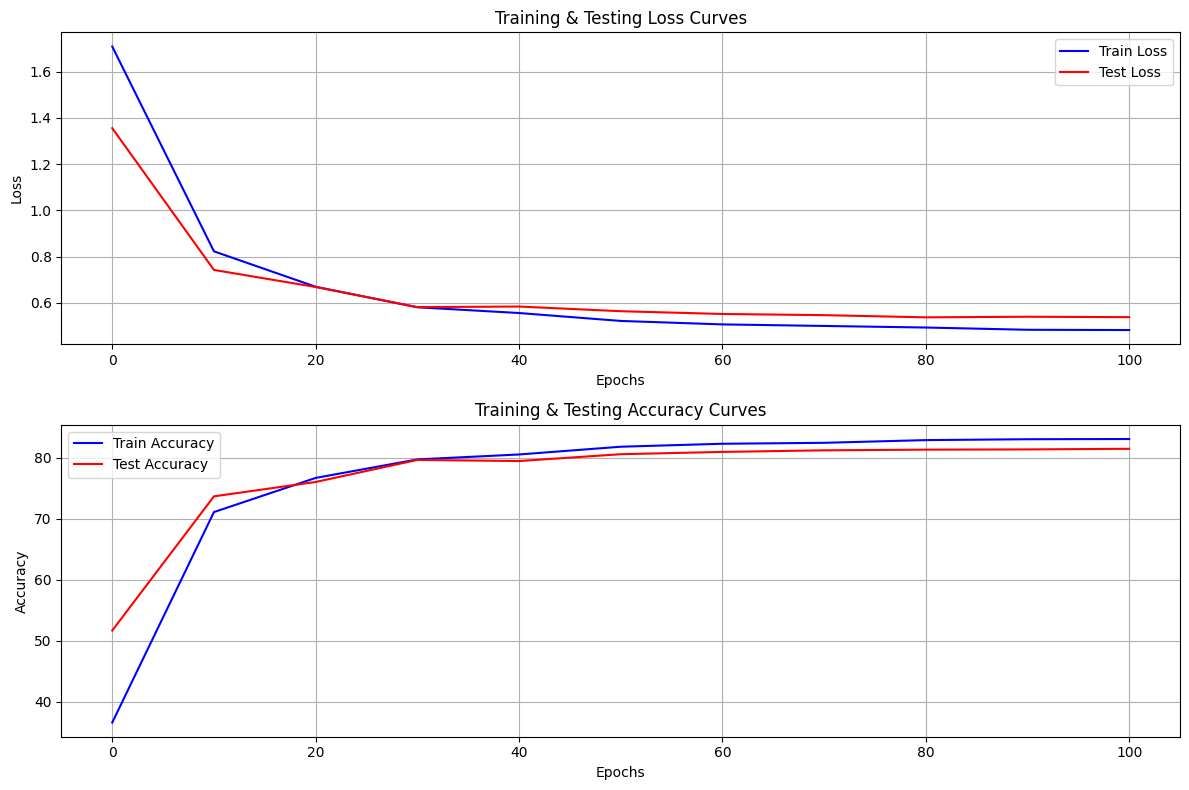

In [32]:
plot_loss_acc_curves(epoch_count, loss_values, test_loss_values, acc_values, test_acc_values)

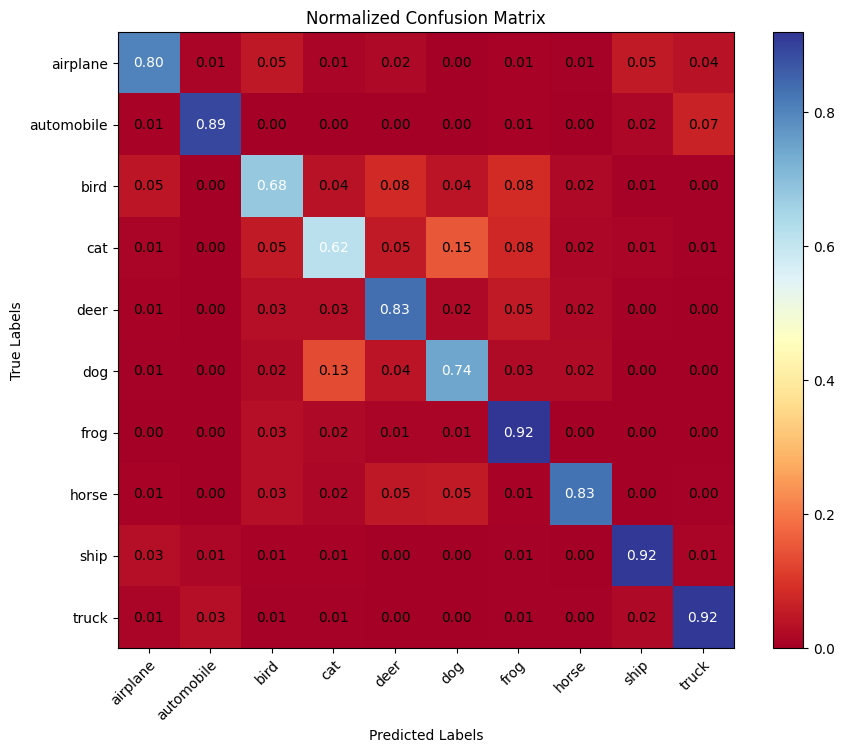

In [33]:
y_predictions = predict(model_conv_scheduler, test_dataloader)
confusion_matrix(label_names, y_predictions, y_test_tensor)

Παρατηρούμε ότι με την χρήση του scheduler δεν κατορθώνουμε να επιτύχουμε πιο μεγάλο ποσοστό ακρίβειας αλλά αντιθέτως επιτυγχάνουμε πιο αργή σύγκλιση λόγω της μείωσης του learning rate. Συνεπώς, ένας τρόπος για να το αντιμετωπίσουμε αυτό θα ήταν είτε να μειώνεται το βήμα με μικρότερο παράγοντα είτε να μειώνεται μετά από μεγαλύτερο αριθμό epochs.

Ας δοκιμάσουμε τώρα έναν άλλο scheduler τον `ReduceLROnPlateau()` ο οποίος μετά από ένα συγκεκριμένο αριθμό από epochs, ελέγχοντας συνεχώς το validation score, μειώνει το learning rate κάτα ένα παράγοντα που το ορίζουμε εμείς. Συνεπώς με αυτό τον τρόπο αναμένω πως σίγουρα θα έχουμε καλύτερα αποτελέσματα από ότι προηγουμένως διότι σε αυτή την περίπτωση το learning rate μειώνεται ανάλογα με το score που έχουμε στο validation, δηλαδή προσαρμόζεται ώστε να τα πάμε καλύτερα σε αυτό το κομμάτι.

In [34]:
model_conv_scheduler_2 = ConvolutionCIFARV4().to(device)
train_dataloader, test_dataloader = batch_creation(train_images_permuted, test_images_permuted, y_train_tensor, y_test_tensor, 32)
loss_fn, optimizer, scheduler = loss_optimizer(model=model_conv_scheduler_2, lr=0.001, momentum=0.7, scheduler_on=False, Adam=False)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
factor=0.5, # how much to reduce the learning rate 
patience=10) # how many epochs should pass before reducing the learning rate

epochs = 101
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epoch_count = []
loss_values = []
test_loss_values = []
acc_values = []
test_acc_values = []
start = time.time()
for epoch in range(epochs):
    train_loss, train_acc = training(model=model_conv_scheduler_2, train_dataloader=train_dataloader, loss_fn=loss_fn, optimizer=optimizer)
    test_loss, test_acc   = testing(model=model_conv_scheduler_2, test_dataloader=test_dataloader, loss_fn=loss_fn)
    scheduler.step(test_loss)

    if epoch % 10 == 0:
        epoch_count.append(epoch)
        loss_values.append(train_loss.item())
        test_loss_values.append(test_loss.item())
        acc_values.append(train_acc)
        test_acc_values.append(test_acc)
        print(f"Epoch {epoch} | Loss : {train_loss:.5f} | Accuracy : {train_acc:.2f}% | Test Loss : {test_loss:.5f} | Test Accuracy : {test_acc:.2f}%")

end = time.time()

print(f'Total Execution time : {end-start:.3f} seconds')

Epoch 0 | Loss : 1.70905 | Accuracy : 36.57% | Test Loss : 1.33041 | Test Accuracy : 52.63%
Epoch 10 | Loss : 0.82147 | Accuracy : 71.24% | Test Loss : 0.76437 | Test Accuracy : 72.58%
Epoch 20 | Loss : 0.67153 | Accuracy : 76.45% | Test Loss : 0.67836 | Test Accuracy : 76.06%
Epoch 30 | Loss : 0.56736 | Accuracy : 80.09% | Test Loss : 0.59745 | Test Accuracy : 79.48%
Epoch 40 | Loss : 0.50536 | Accuracy : 82.36% | Test Loss : 0.55595 | Test Accuracy : 80.55%
Epoch 50 | Loss : 0.44659 | Accuracy : 84.22% | Test Loss : 0.54949 | Test Accuracy : 81.41%
Epoch 60 | Loss : 0.40640 | Accuracy : 85.53% | Test Loss : 0.56261 | Test Accuracy : 81.41%
Epoch 70 | Loss : 0.37386 | Accuracy : 86.77% | Test Loss : 0.50859 | Test Accuracy : 83.21%
Epoch 80 | Loss : 0.31797 | Accuracy : 88.69% | Test Loss : 0.51916 | Test Accuracy : 83.18%
Epoch 90 | Loss : 0.28847 | Accuracy : 89.67% | Test Loss : 0.50479 | Test Accuracy : 84.19%
Epoch 100 | Loss : 0.27266 | Accuracy : 90.33% | Test Loss : 0.50002 | 

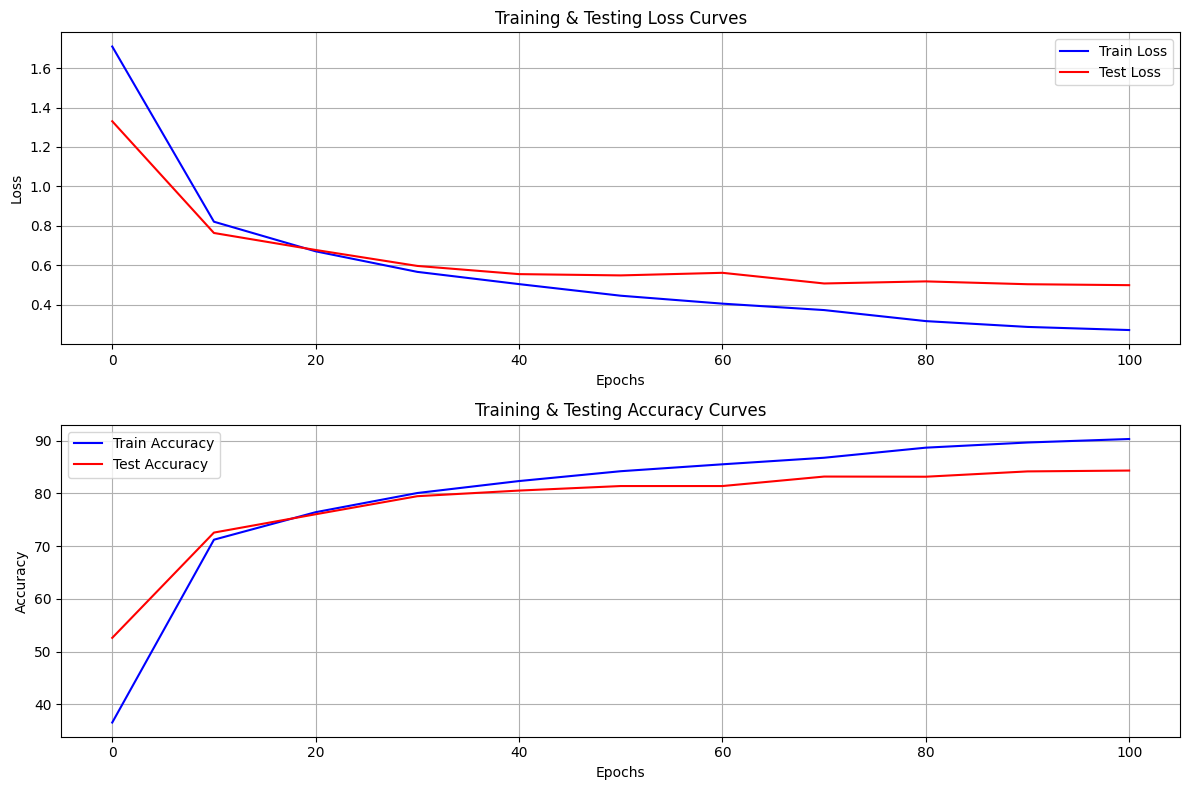

Model Saved Successfully


In [35]:
plot_loss_acc_curves(epoch_count, loss_values, test_loss_values, acc_values, test_acc_values)
save_model(model=model_conv_scheduler_2, save_name='model_conv_scheduler.pth')

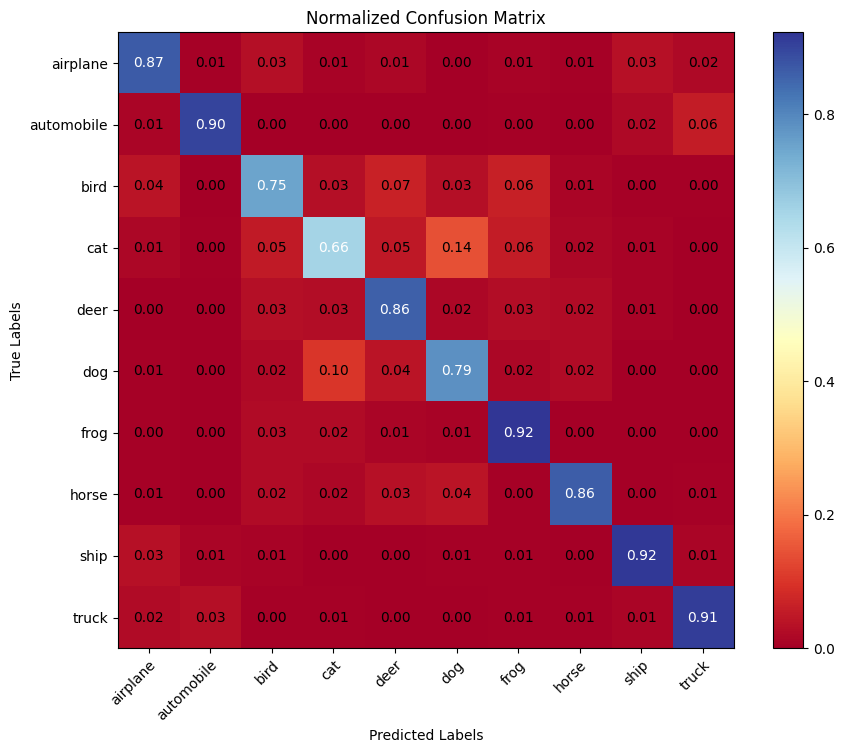

In [37]:
y_predictions = predict(model_conv_scheduler_2, test_dataloader)
confusion_matrix(label_names, y_predictions, y_test_tensor)

Όπως μπορούμε να δούμε, όντως είχαμε μια σημαντική βελτίωση ~3% σε σχέση με προηγουμένως με την χρήση του `ReduceLROnPlateau()` καθότι όπως αναφέραμε και προηγουμένως αυτός ο scheduler λαμβάνει υπόψη του το validation loss οπότε με βάση με αυτό μεταβάλλει το learing rate. Συνεπώς, για αυτή την περίπτωση προτιμούμε αυτόν τον scheduler καθότι βλέπουμε πως αποδίδει πολύ καλύτερα.

## **ADAM Optimizer**

Τώρα, ας δοκιμάσουμε αντί για την **Stochastic Gradient Descent** να χρησιμοποιήοουμε σαν optimizer τον **Adam** ο οποίος προτείνεται και στην βιβλιογραφία και συνίσταται για τα συνελικτικά δίκτυα καθότι προσφέρει καλύτερα αποτελέσματα.

Παρακάτω ακολουθεί ο κώδικας στο οποίον η μοναδική αλλαγή είναι η χρήση διαφορετικού optimizer.

In [95]:
model_adam = ConvolutionCIFARV4().to(device)
train_dataloader, test_dataloader = batch_creation(train_images_permuted, test_images_permuted, y_train_tensor, y_test_tensor, 32)
loss_fn, optimizer, scheduler = loss_optimizer(model=model_adam, lr=0.001, momentum=0.7, scheduler_on=False, Adam=True)
epochs = 101
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epoch_count = []
loss_values = []
test_loss_values = []
acc_values = []
test_acc_values = []
start = time.time()
for epoch in range(epochs):
    train_loss, train_acc = training(model=model_adam, train_dataloader=train_dataloader, loss_fn=loss_fn, optimizer=optimizer)
    test_loss, test_acc   = testing(model=model_adam, test_dataloader=test_dataloader, loss_fn=loss_fn)

    if epoch % 10 == 0:
        epoch_count.append(epoch)
        loss_values.append(train_loss.item())
        test_loss_values.append(test_loss.item())
        acc_values.append(train_acc)
        test_acc_values.append(test_acc)
        print(f"Epoch {epoch} | Loss : {train_loss:.5f} | Accuracy : {train_acc:.2f}% | Test Loss : {test_loss:.5f} | Test Accuracy : {test_acc:.2f}%")

end = time.time()

print(f'Total Execution time : {end-start:.3f} seconds')

Epoch 0 | Loss : 1.72336 | Accuracy : 33.80% | Test Loss : 1.43997 | Test Accuracy : 47.49%
Epoch 10 | Loss : 0.71210 | Accuracy : 75.42% | Test Loss : 0.60545 | Test Accuracy : 79.24%
Epoch 20 | Loss : 0.50521 | Accuracy : 82.56% | Test Loss : 0.55323 | Test Accuracy : 81.76%
Epoch 30 | Loss : 0.42292 | Accuracy : 85.47% | Test Loss : 0.51520 | Test Accuracy : 83.26%
Epoch 40 | Loss : 0.38591 | Accuracy : 86.44% | Test Loss : 0.55534 | Test Accuracy : 82.31%
Epoch 50 | Loss : 0.36522 | Accuracy : 87.17% | Test Loss : 0.54349 | Test Accuracy : 82.74%
Epoch 60 | Loss : 0.35691 | Accuracy : 87.68% | Test Loss : 0.49042 | Test Accuracy : 83.86%
Epoch 70 | Loss : 0.34069 | Accuracy : 88.04% | Test Loss : 0.47885 | Test Accuracy : 84.52%
Epoch 80 | Loss : 0.33423 | Accuracy : 88.37% | Test Loss : 0.47382 | Test Accuracy : 84.85%
Epoch 90 | Loss : 0.32763 | Accuracy : 88.74% | Test Loss : 0.46264 | Test Accuracy : 85.32%
Epoch 100 | Loss : 0.32553 | Accuracy : 88.63% | Test Loss : 0.49975 | 

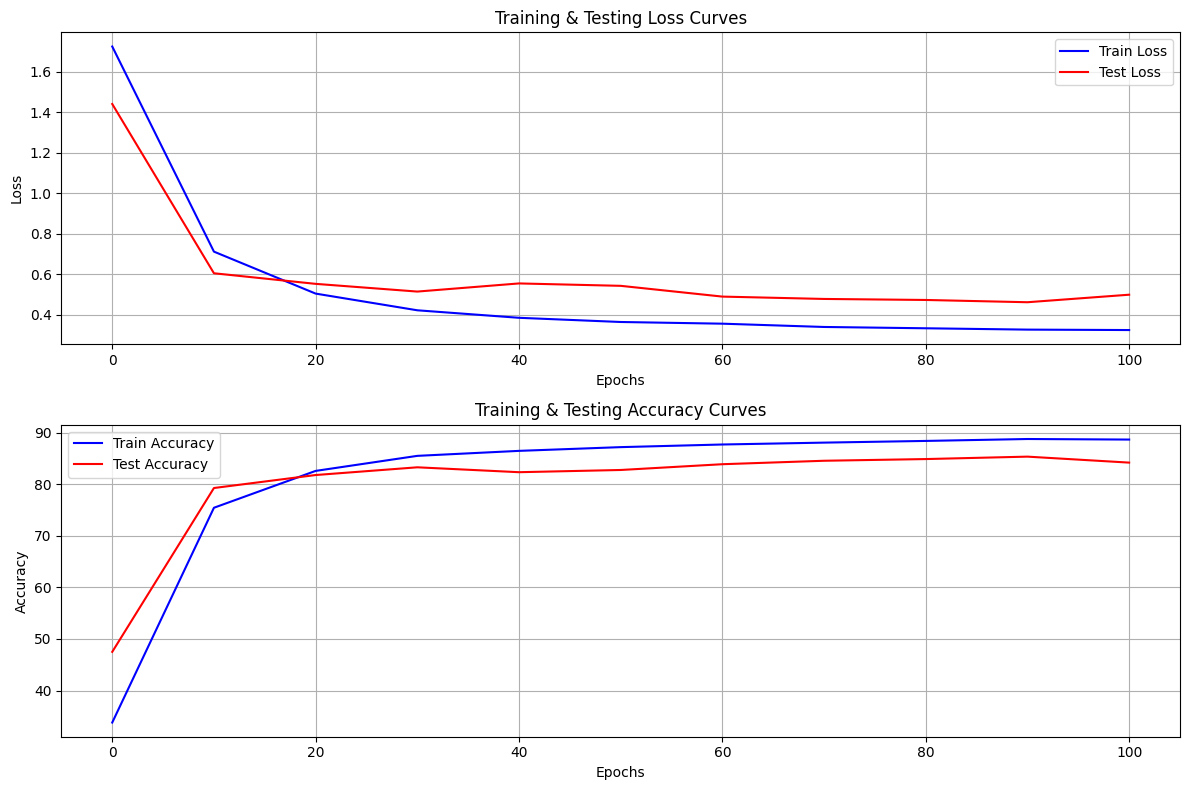

Model Saved Successfully


In [96]:
plot_loss_acc_curves(epoch_count, loss_values, test_loss_values, acc_values, test_acc_values)
save_model(model=model_adam, save_name='model_adam.pth')

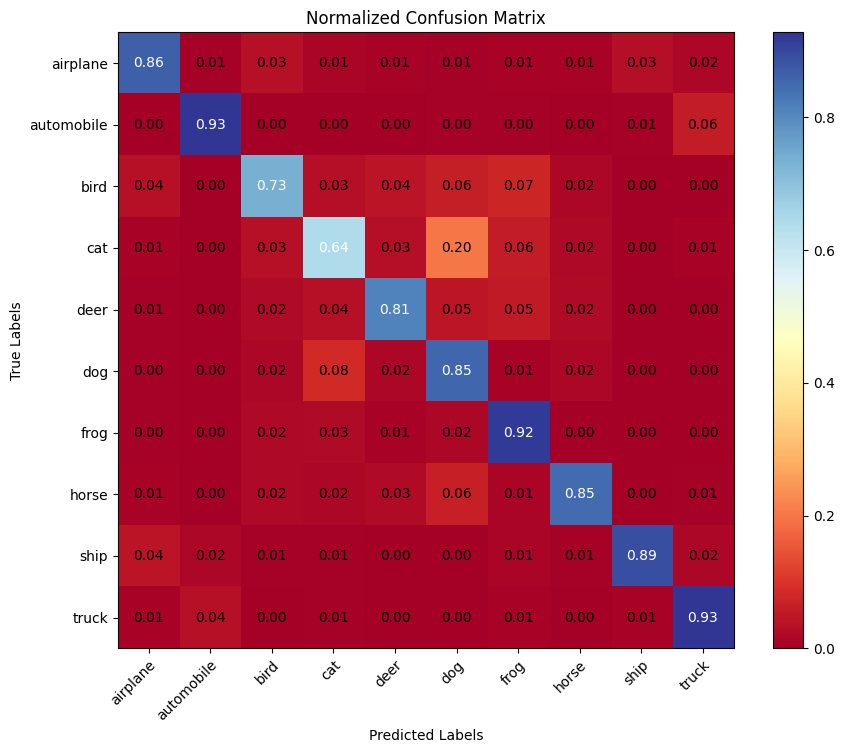

In [97]:
y_predictions = predict(model_adam, test_dataloader)
confusion_matrix(label_names, y_predictions, y_test_tensor)

Όπως παρατηρούμε με την χρήση αυτού του optimizer κατορθώσαμε να επιτύχουμε καλύτερα ποσοστά σε σχέση με προηγουμενώς, άρα με αυτό τον τρόπο επιβεβαιώνουμε πως αυτός ο optimizer είναι όντως πιο κατάλληλος για την δουλειά που θέλουμε να κάνουμε που είναι η κατηγοριοποίηση των εικόνων στις κατάλληλες κλάσεις.

Ας δοκιμάσουμε τώρα πέρα από τον Adam optimizer να βάλουμε και τον scheduler για να δούμε άμα θα λάβουμε κάποια βελτίωση στην ακρίβεια του μοντέλου μας.

In [27]:
model_adam_scheduler = ConvolutionCIFARV4().to(device)
train_dataloader, test_dataloader = batch_creation(train_images_permuted, test_images_permuted, y_train_tensor, y_test_tensor, 32)
loss_fn, optimizer, scheduler = loss_optimizer(model=model_adam_scheduler, lr=0.001, momentum=0.7, scheduler_on=True, Adam=True)
epochs = 101
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epoch_count = []
loss_values = []
test_loss_values = []
acc_values = []
test_acc_values = []

start = time.time()
for epoch in range(epochs):
    train_loss, train_acc = training(model=model_adam_scheduler, train_dataloader=train_dataloader, loss_fn=loss_fn, optimizer=optimizer)
    test_loss, test_acc   = testing(model=model_adam_scheduler, test_dataloader=test_dataloader, loss_fn=loss_fn)
    scheduler.step()

    if epoch % 10 == 0:
        epoch_count.append(epoch)
        loss_values.append(train_loss.item())
        test_loss_values.append(test_loss.item())
        acc_values.append(train_acc)
        test_acc_values.append(test_acc)
        print(f"Epoch {epoch} | Loss : {train_loss:.5f} | Accuracy : {train_acc:.2f}% | Test Loss : {test_loss:.5f} | Test Accuracy : {test_acc:.2f}%")

end = time.time()

print(f'Total Execution time : {end-start:.3f} seconds')

Epoch 0 | Loss : 1.71872 | Accuracy : 33.92% | Test Loss : 1.26004 | Test Accuracy : 55.95%
Epoch 10 | Loss : 0.71399 | Accuracy : 75.52% | Test Loss : 0.61521 | Test Accuracy : 78.89%
Epoch 20 | Loss : 0.42839 | Accuracy : 85.12% | Test Loss : 0.50739 | Test Accuracy : 83.08%
Epoch 30 | Loss : 0.30348 | Accuracy : 89.37% | Test Loss : 0.47299 | Test Accuracy : 84.59%
Epoch 40 | Loss : 0.24333 | Accuracy : 91.46% | Test Loss : 0.49676 | Test Accuracy : 84.64%
Epoch 50 | Loss : 0.20059 | Accuracy : 92.91% | Test Loss : 0.49670 | Test Accuracy : 85.30%
Epoch 60 | Loss : 0.17338 | Accuracy : 93.86% | Test Loss : 0.50806 | Test Accuracy : 85.30%
Epoch 70 | Loss : 0.15926 | Accuracy : 94.33% | Test Loss : 0.52299 | Test Accuracy : 85.25%
Epoch 80 | Loss : 0.15155 | Accuracy : 94.76% | Test Loss : 0.51492 | Test Accuracy : 85.47%
Epoch 90 | Loss : 0.14210 | Accuracy : 95.11% | Test Loss : 0.51482 | Test Accuracy : 85.55%
Epoch 100 | Loss : 0.13848 | Accuracy : 95.23% | Test Loss : 0.51987 | 

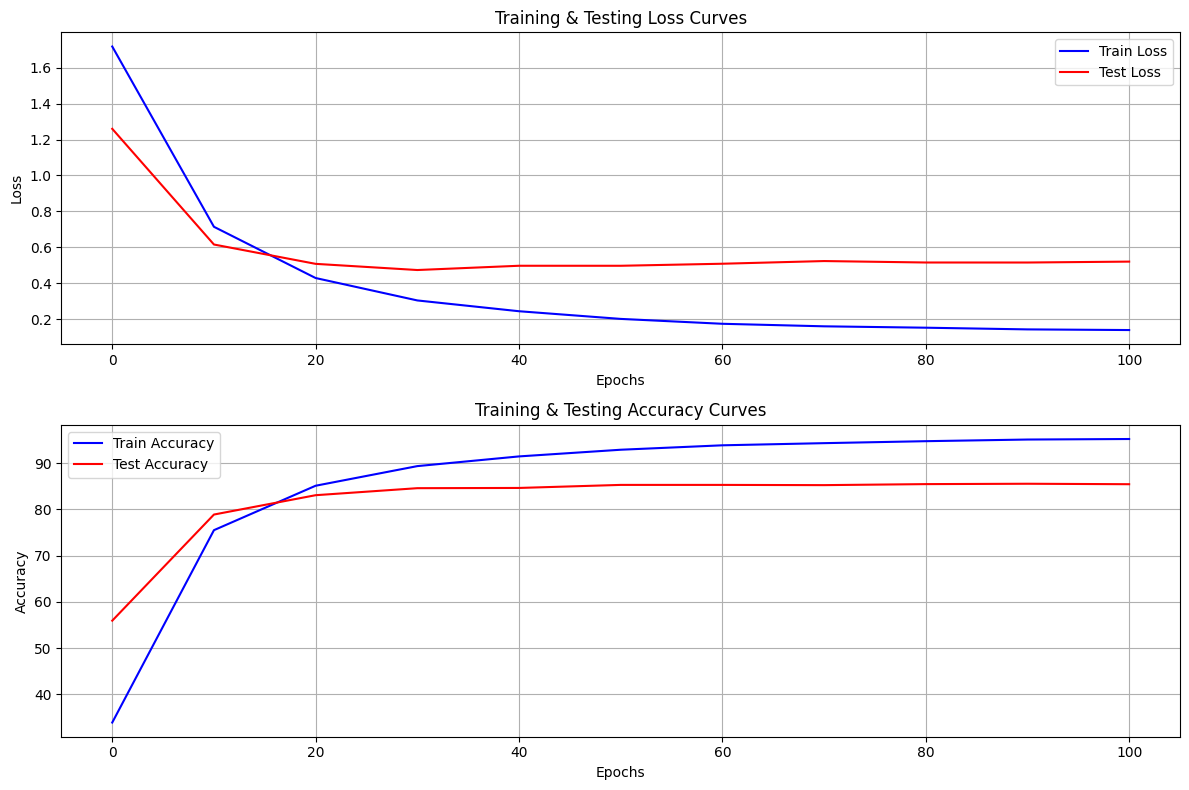

Model Saved Successfully


In [28]:
plot_loss_acc_curves(epoch_count, loss_values, test_loss_values, acc_values, test_acc_values)
save_model(model=model_adam_scheduler, save_name='model_adam_scheduler.pth')

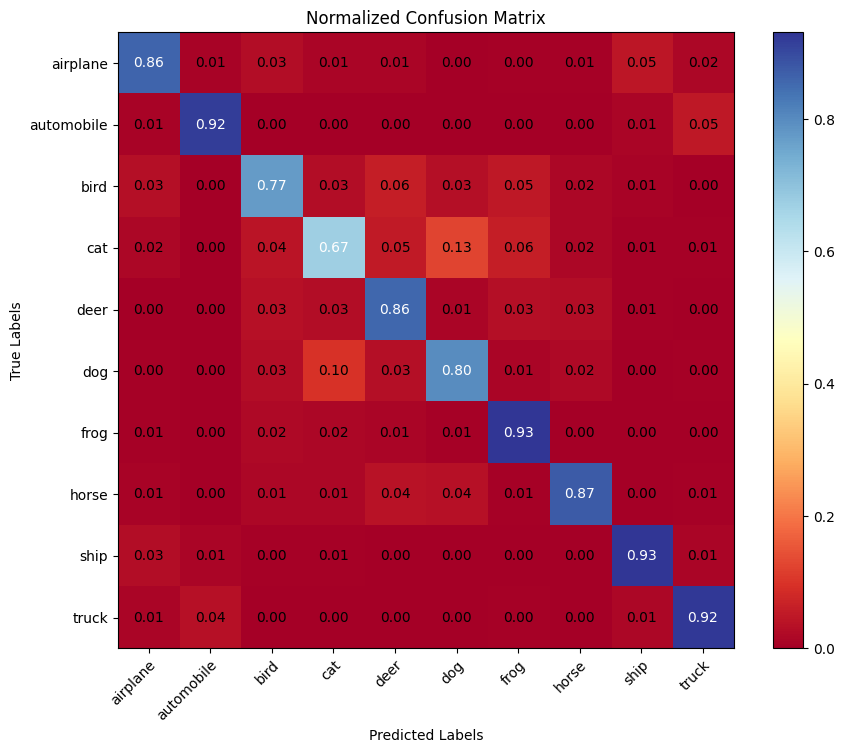

In [30]:
y_predictions = predict(model_adam_scheduler, test_dataloader)
confusion_matrix(label_names, y_predictions, y_test_tensor)

Όπως βλέπουμε με την χρήση του scheduler καταφέραμε να επιτύχουμε ελάχιστα μεγαλύτερα ποσοστά ακρίβειας σε σχέση με προηγουμένως, γεγονός που σημαίνει πως βοήθησε το μοντέλο μας ώστε να μην ταλαντώνεται μεταξύ των ισοβαρών και να οδηγηθεί πιο εύκολα στο τοπικό ελάχιστο, σε αντίθεση με προηγουμένως, όπου η ακρίβεια ήταν μεταξύ 84-85%. Ωστόσο, βλέπουμε πως αυτή η πρακτική βοήθησε και στο training sample αρκετά με αποτέλεσμσ να έχουμε μια διαφορά  ~10% μεταξύ training και testing sample, γεγονός που σημαίνει ότι άμα το αφήναμε να τρέξει για περισσότερα epochs θα συναντούσαμε το πρόβλημα της υπερ-προσαρμογής. Συνεπώς, μολονότι ο scheduler μας βοήθησε να ξεφύγουμε από το τοπικό ελάχιστο που ήμασταν "εγκλωβισμένοι" στο test sample, είναι αρκετά πιθανό ότι θα μας οδηγήσει σε overfitting, οπότε θα πρέπει να είμαστε προσεκτικοί και να ρυθμίζουμε κατάλληλα τον παράγοντα με τον οποίο επιθυμούμε να μειωθεί το learning rate.

## **Data Augmentation**

Μια ακόμα τεχνική που θα μπορούσαμε να χρησιμοποιήσουμε για να αποφύγουμε το overfitting και το νευρωνικό μας να μαθαίνει όντως και να μην μαθαίνει απλά τον θόρυβο θα ήταν να χρησιμοποιήσουμε την τεχνική του data augmentation(το οποίο μου το πρότεινε το **ChatGPT** σαν ένα ακόμα τρόπο αντιμετώπισης αυτού του προβλήματος). Ουσιαστικά, θα μπορούσαμε σε κάθε batch εικόνων που δίνουμε στο νευρωνικό, να εφαρμόζουμε με τυχαίο τρόπο κάποιους μετασχηματισμούς. Για παράδειγμα, για την CIFAR-10 που έχει εικόνες, θα μπορούσαμε να αλλάζουμε τυχαία το μέγεθος της εικόνας, να την περιστρέφουμε, να αλλάζουμε τον προσανατολισμό της αλλά και να τροποποιούμε τα χρώματα της εικόνας. Αυτή η τεχνική πέρα από το γεγονός ότι μας βοηθάει να αποφύγουμε το overfitting, μπορεί επίσης να βελτιώσει και την ακρίβεια στα test samples καθώς το μοντέλο εκτίθεται σε διάφορες παραλλαγές εισόδων.

In [25]:
def data_augmentation(train_images, test_images, y_train_tensor, y_test_tensor, BATCH_SIZE):

    augmentation_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),       # Horizontal flip
    transforms.RandomRotation(10),           # Rotate by ±10 degrees
    transforms.RandomResizedCrop(32, scale=(0.8, 1.0)),  # Randomly crop and resize back to 32x32
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1), # Color jitter
    transforms.ToTensor()
    ])

    train_dataset = TensorDataset(train_images, y_train_tensor)
    test_dataset  = TensorDataset(test_images, y_test_tensor)

    BATCH_SIZE = BATCH_SIZE

    train_dataloader = DataLoader(train_dataset, # the dataset to turn into iterable
    batch_size=BATCH_SIZE, # the size of the batch
    shuffle=True # shuffle data every epoch
    )

    test_dataloader = DataLoader(test_dataset, # the dataset to turn into iterable
    batch_size=BATCH_SIZE, # the size of the batch
    shuffle=False # no need to shuffle test data every epoch
    )

    aug_train_images = []
    aug_train_labels = []

    for X, y in train_dataloader:
        for i in range(X.shape[0]):
            image = transforms.ToPILImage()(X[i]) # transform the input to PIL image type
            image = augmentation_transforms(image) # apply the augmentation transformations 
            aug_train_images.append(image) # append the augmented image to the list
            aug_train_labels.append(y[i]) # append the corresponding label

    aug_train_images_tensor = torch.stack(aug_train_images).to(device)
    aug_train_labels_tensor = torch.stack(aug_train_labels)

    aug_train_dataset = TensorDataset(aug_train_images_tensor, aug_train_labels_tensor)
    
    aug_train_dataloader = DataLoader(aug_train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
    )

    return aug_train_dataloader, test_dataloader

Θα χρησιμοποιήσουμε όπως και προηγουμένως την ίδια κλάση και εδώ για το μοντέλο του νευρωνικού μας, απλά αυτή την φορά θα το εκπαιδεύσουμε με τα augmented δεδομένα για να δούμε πως θα τα πάει.

In [ ]:
model_conv_5 = ConvolutionCIFARV4().to(device)
train_dataloader, test_dataloader = data_augmentation(train_images_permuted, test_images_permuted, y_train_tensor, y_test_tensor, 32)
loss_fn, optimizer, scheduler = loss_optimizer(model=model_conv_5, lr=0.001, momentum=0.7, scheduler_on=False, Adam=False)
epochs = 101
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epoch_count = []
loss_values = []
test_loss_values = []
acc_values = []
test_acc_values = []
start = time.time()
for epoch in range(epochs):
    train_loss, train_acc = training(model=model_conv_5, train_dataloader=train_dataloader, loss_fn=loss_fn, optimizer=optimizer)
    test_loss, test_acc   = testing(model=model_conv_5, test_dataloader=test_dataloader, loss_fn=loss_fn)

    if epoch % 10 == 0:
        epoch_count.append(epoch)
        loss_values.append(train_loss.item())
        test_loss_values.append(test_loss.item())
        acc_values.append(train_acc)
        test_acc_values.append(test_acc)
        print(f"Epoch {epoch} | Loss : {train_loss:.5f} | Accuracy : {train_acc:.2f}% | Test Loss : {test_loss:.5f} | Test Accuracy : {test_acc:.2f}%")

end = time.time()

print(f'Total Execution time : {end-start:.3f} seconds')

Epoch 0 | Loss : 1.83589 | Accuracy : 31.60% | Test Loss : 1.44187 | Test Accuracy : 48.53%
Epoch 10 | Loss : 1.05372 | Accuracy : 62.82% | Test Loss : 0.93841 | Test Accuracy : 66.67%
Epoch 20 | Loss : 0.87568 | Accuracy : 69.31% | Test Loss : 0.79567 | Test Accuracy : 72.55%
Epoch 30 | Loss : 0.76360 | Accuracy : 73.08% | Test Loss : 0.74248 | Test Accuracy : 74.97%
Epoch 40 | Loss : 0.69005 | Accuracy : 75.53% | Test Loss : 0.69164 | Test Accuracy : 77.05%
Epoch 50 | Loss : 0.63530 | Accuracy : 77.57% | Test Loss : 0.67009 | Test Accuracy : 77.80%
Epoch 60 | Loss : 0.58242 | Accuracy : 79.03% | Test Loss : 0.67282 | Test Accuracy : 78.32%
Epoch 70 | Loss : 0.53608 | Accuracy : 80.93% | Test Loss : 0.65684 | Test Accuracy : 79.41%
Epoch 80 | Loss : 0.50673 | Accuracy : 81.82% | Test Loss : 0.69349 | Test Accuracy : 78.85%
Epoch 90 | Loss : 0.47208 | Accuracy : 83.02% | Test Loss : 0.69580 | Test Accuracy : 79.13%
Epoch 100 | Loss : 0.45113 | Accuracy : 83.61% | Test Loss : 0.71110 | 

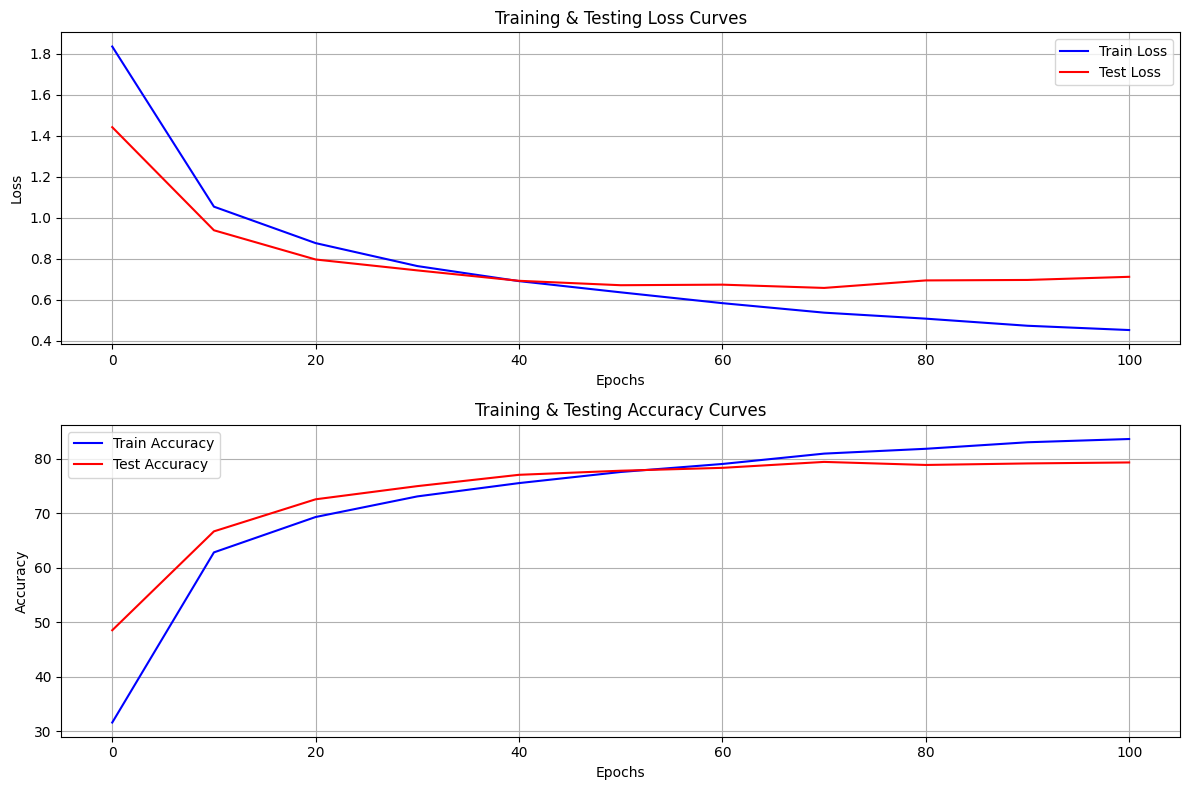

Model Saved Successfully


In [69]:
plot_loss_acc_curves(epoch_count, loss_values, test_loss_values, acc_values, test_acc_values)
save_model(model=model_conv_5, save_name='model_conv_5.pth')

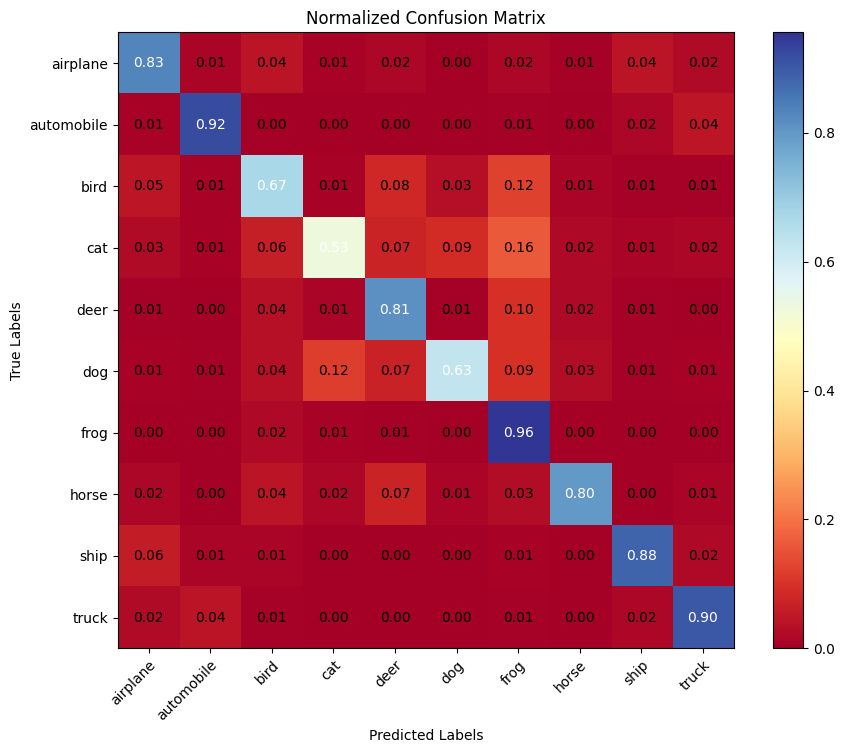

In [70]:
y_predictions = predict(model_conv_5, test_dataloader)
confusion_matrix(label_names, y_predictions, y_test_tensor)

Από τα παραπάνω αποτελέσματα βλέπουμε, πως έχουμε μικρότερη ακρίβεια στο test sample. Ωστόσο, το νευρωνικό μας δίκτυο έγινε με αυτό τον τρόπο πιο εύρωστο και είναι λιγότερο πιθανό να έχουμε το πρόβλημα της υπερ-προσαρμογής γιατί το δίκτυο όμως μαθαίνει πλέον τα ειδικά χαρακτηριστικά που έχει η κάθε κλάση και δεν τις απομνημονεύει. Επομένως, θεωρώ πως αυτή είναι μια πολύ καλή πρακτική που σίγουρα μπορεί να μας βοηθήσει και να φτιάξουμε πιο εύρωστα και ανθεκτικά νευρωνικά δίκτυα αλλά και να επιτύχουμε πολύ υψηλά ποσοστά ακρίβειας, το οποίο το κατορθώσαμε και εδω πέρα.

## **Συνδυασμός MLP & CNN**

Τέλος, δοκιμάζω να συνδυάσω το συνελικτικό δίκτυο που έχω φτιάξει μαζί με τον **MLP** που είχα φτιάξει προηγουμένως και είχε αποδώσει καλύτερα. Αυτό γίνεται για να δούμε τι θα προκύψει καθώς το μοντέλο που θα φτιάξουμε τώρα θα είναι αρκετά πιο σύνθετο. Ωστόσο, αυτό δεν μας εγγυάται απαραίτητα ότι θα έχουμε και καλύτερη ακρίβεια

Θα δοκιμάσω αρχικά να εκπαιδεύσω το μοντέλο μου με τα κανονικά δεδομένα, δηλαδή με τις εικόνες που φτιάχνω από την **CIFAR-10** και στην συνέχεια θα δοκιμάσω να κάνω **data augmentation** για να δω πως αποδίδει και σε αυτή την περίπτωση.

In [26]:
class Combination(nn.Module):
    def __init__(self, in_features=128, out_features=10, hidden_units=200):
        super().__init__()

        self.conv_layer_1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(32), # makes the training better, faster and adds performance
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(32), # makes the training better, faster and adds performance
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2)),
            nn.Dropout(0.25)
        )

        self.conv_layer_2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(64), # makes the training better, faster and adds performance
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2)),
            nn.Dropout(0.25)
        )

        self.linear_layer_1 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=64 * 8 * 8, out_features=in_features),  
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features=in_features, out_features=hidden_units)  
        )

        self.linear_layer_2 = nn.Sequential(
            nn.Linear(in_features=hidden_units, out_features=hidden_units), # here I create u = w^T*x + b
            nn.ReLU(), # y = φ(u)
            nn.Dropout(0.3),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.BatchNorm1d(num_features=hidden_units), # makes the training better, faster and adds performance
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.BatchNorm1d(num_features=hidden_units), # makes the training better, faster and adds performance
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=out_features) # Output of the 10 classes of the CIFAR-10
        )

    def forward(self, x):
        x = self.conv_layer_1(x)
        x = self.conv_layer_2(x)
        x = self.linear_layer_1(x)
        x = self.linear_layer_2(x)
        return x

In [ ]:
model_comb = Combination().to(device)
train_dataloader, test_dataloader = batch_creation(train_images_permuted, test_images_permuted, y_train_tensor, y_test_tensor, 32)
loss_fn, optimizer, scheduler = loss_optimizer(model=model_comb, lr=0.001, momentum=0.7, scheduler_on=False, Adam=False)
epochs = 101
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epoch_count = []
loss_values = []
test_loss_values = []
acc_values = []
test_acc_values = []
start = time.time()
for epoch in range(epochs):
    train_loss, train_acc = training(model=model_comb, train_dataloader=train_dataloader, loss_fn=loss_fn, optimizer=optimizer)
    test_loss, test_acc   = testing(model=model_comb, test_dataloader=test_dataloader, loss_fn=loss_fn)

    if epoch % 10 == 0:
        epoch_count.append(epoch)
        loss_values.append(train_loss.item())
        test_loss_values.append(test_loss.item())
        acc_values.append(train_acc)
        test_acc_values.append(test_acc)
        print(f"Epoch {epoch} | Loss : {train_loss:.5f} | Accuracy : {train_acc:.2f}% | Test Loss : {test_loss:.5f} | Test Accuracy : {test_acc:.2f}%")

end = time.time()

print(f'Total Execution time : {end-start:.3f} seconds')

Epoch 0 | Loss : 2.04044 | Accuracy : 21.01% | Test Loss : 1.82671 | Test Accuracy : 29.05%
Epoch 10 | Loss : 1.06300 | Accuracy : 63.24% | Test Loss : 0.87121 | Test Accuracy : 69.95%
Epoch 20 | Loss : 0.84824 | Accuracy : 71.42% | Test Loss : 0.72608 | Test Accuracy : 75.56%
Epoch 30 | Loss : 0.72112 | Accuracy : 76.18% | Test Loss : 0.62660 | Test Accuracy : 79.35%
Epoch 40 | Loss : 0.63987 | Accuracy : 79.08% | Test Loss : 0.59975 | Test Accuracy : 79.54%
Epoch 50 | Loss : 0.57424 | Accuracy : 81.03% | Test Loss : 0.57945 | Test Accuracy : 80.89%
Epoch 60 | Loss : 0.52248 | Accuracy : 82.91% | Test Loss : 0.54103 | Test Accuracy : 82.19%
Epoch 70 | Loss : 0.47645 | Accuracy : 84.39% | Test Loss : 0.54002 | Test Accuracy : 82.38%
Epoch 80 | Loss : 0.43925 | Accuracy : 85.85% | Test Loss : 0.54603 | Test Accuracy : 82.44%
Epoch 90 | Loss : 0.41241 | Accuracy : 86.54% | Test Loss : 0.51024 | Test Accuracy : 83.80%
Epoch 100 | Loss : 0.38631 | Accuracy : 87.41% | Test Loss : 0.52858 | 

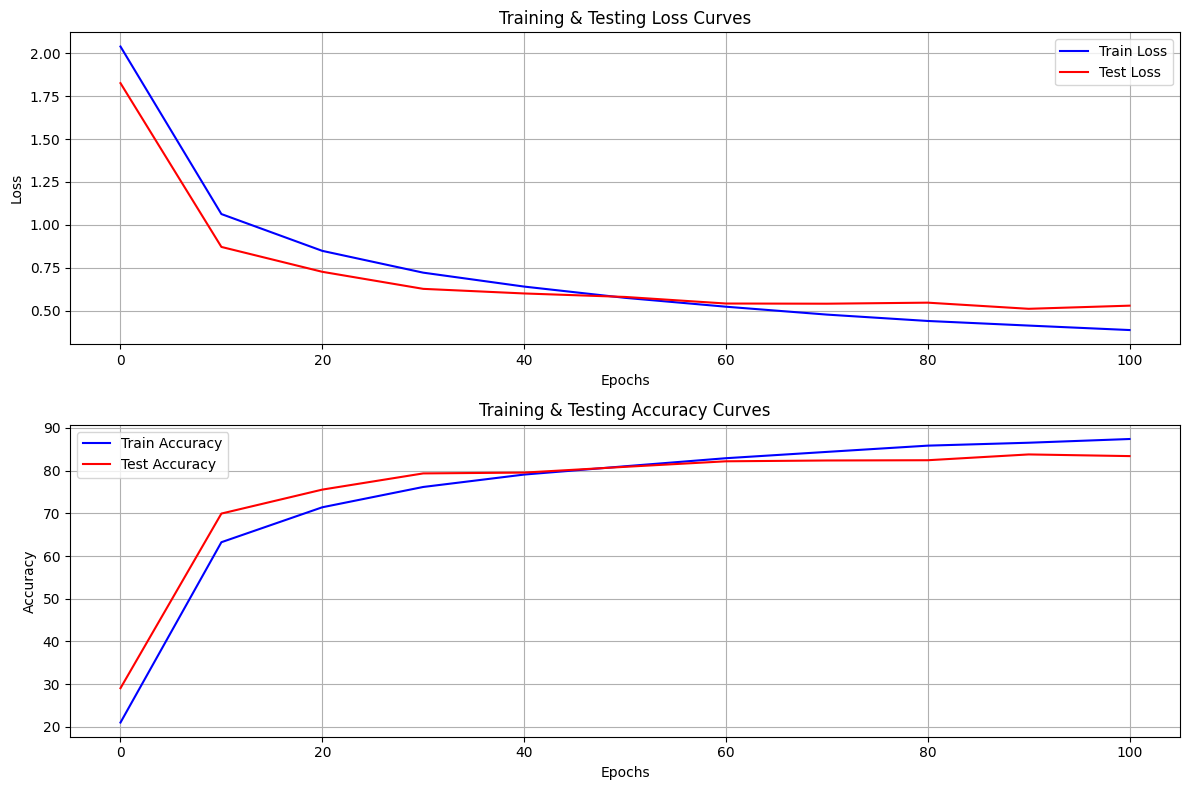

Model Saved Successfully


In [79]:
plot_loss_acc_curves(epoch_count, loss_values, test_loss_values, acc_values, test_acc_values)
save_model(model=model_comb, save_name='model_comb.pth')

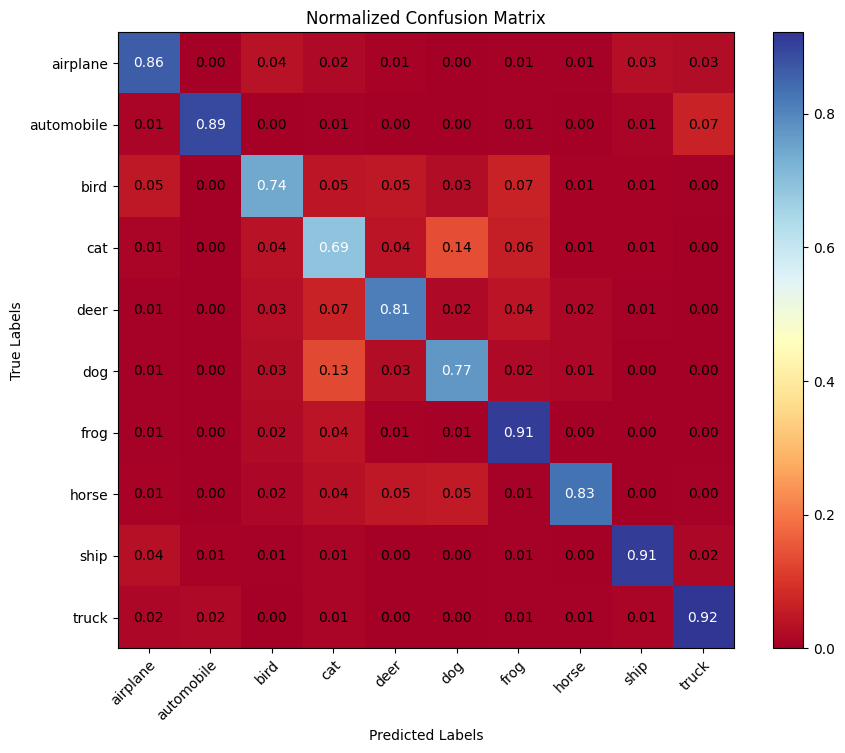

In [80]:
y_predictions = predict(model_comb, test_dataloader)
confusion_matrix(label_names, y_predictions, y_test_tensor)

Όπως μπορούμε να δούμε, ο συνδυασμός **MLP** και **CNN** δεν είχε τρομερή επίπτωση στην ακρίβεια του μοντέλου μας καθότι παρατηρούμε πως και τα δύο μοντέλα έχουν πάνω κάτω την ίδια ακρίβεια. Επομένως, ο συνδυασμός τους δεν μας επέφερε κάποια βελτίωση γεγονός που σημαίνει ότι μάλλον θα ήταν προτιμότερο να προσθέσουμε σε αυτό το σημείο περισσότερα blocks από convolutional layers αντί για το **MLP** για την καλύτερη κατηγοριοποίηση των εικόνων στις κατάλληλες κλάσεις.

Ας δοκιμάσουμε τώρα να δούμε την απόδοση του συνδυασμού με την χρήση επαυξημένων δεδομένων και να συγκρίνουμε με την προηγούμενη περίπτωση όπου χρησιμοποιήσαμε το **CNN**.

In [ ]:
model_comb_2 = Combination().to(device)
train_dataloader, test_dataloader = data_augmentation(train_images_permuted, test_images_permuted, y_train_tensor, y_test_tensor, 32)
loss_fn, optimizer, scheduler = loss_optimizer(model=model_comb_2, lr=0.001, momentum=0.7, scheduler_on=False, Adam=False)
epochs = 101
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epoch_count = []
loss_values = []
test_loss_values = []
acc_values = []
test_acc_values = []
start = time.time()
for epoch in range(epochs):
    train_loss, train_acc = training(model=model_comb_2, train_dataloader=train_dataloader, loss_fn=loss_fn, optimizer=optimizer)
    test_loss, test_acc   = testing(model=model_comb_2, test_dataloader=test_dataloader, loss_fn=loss_fn)

    if epoch % 10 == 0:
        epoch_count.append(epoch)
        loss_values.append(train_loss.item())
        test_loss_values.append(test_loss.item())
        acc_values.append(train_acc)
        test_acc_values.append(test_acc)
        print(f"Epoch {epoch} | Loss : {train_loss:.5f} | Accuracy : {train_acc:.2f}% | Test Loss : {test_loss:.5f} | Test Accuracy : {test_acc:.2f}%")

end = time.time()

print(f'Total Execution time : {end-start:.3f} seconds')

Epoch 0 | Loss : 2.10710 | Accuracy : 18.16% | Test Loss : 1.94258 | Test Accuracy : 24.35%
Epoch 10 | Loss : 1.32277 | Accuracy : 53.20% | Test Loss : 1.07327 | Test Accuracy : 61.95%
Epoch 20 | Loss : 1.08344 | Accuracy : 62.72% | Test Loss : 0.92417 | Test Accuracy : 68.80%
Epoch 30 | Loss : 0.96370 | Accuracy : 67.52% | Test Loss : 0.81216 | Test Accuracy : 72.17%
Epoch 40 | Loss : 0.87638 | Accuracy : 70.35% | Test Loss : 0.82433 | Test Accuracy : 73.10%
Epoch 50 | Loss : 0.80916 | Accuracy : 72.72% | Test Loss : 0.69320 | Test Accuracy : 77.01%
Epoch 60 | Loss : 0.75179 | Accuracy : 75.02% | Test Loss : 0.68109 | Test Accuracy : 77.58%
Epoch 70 | Loss : 0.70633 | Accuracy : 76.73% | Test Loss : 0.66713 | Test Accuracy : 78.35%
Epoch 80 | Loss : 0.65714 | Accuracy : 78.18% | Test Loss : 0.66334 | Test Accuracy : 78.55%
Epoch 90 | Loss : 0.62326 | Accuracy : 79.24% | Test Loss : 0.66128 | Test Accuracy : 78.84%
Epoch 100 | Loss : 0.58103 | Accuracy : 80.78% | Test Loss : 0.72001 | 

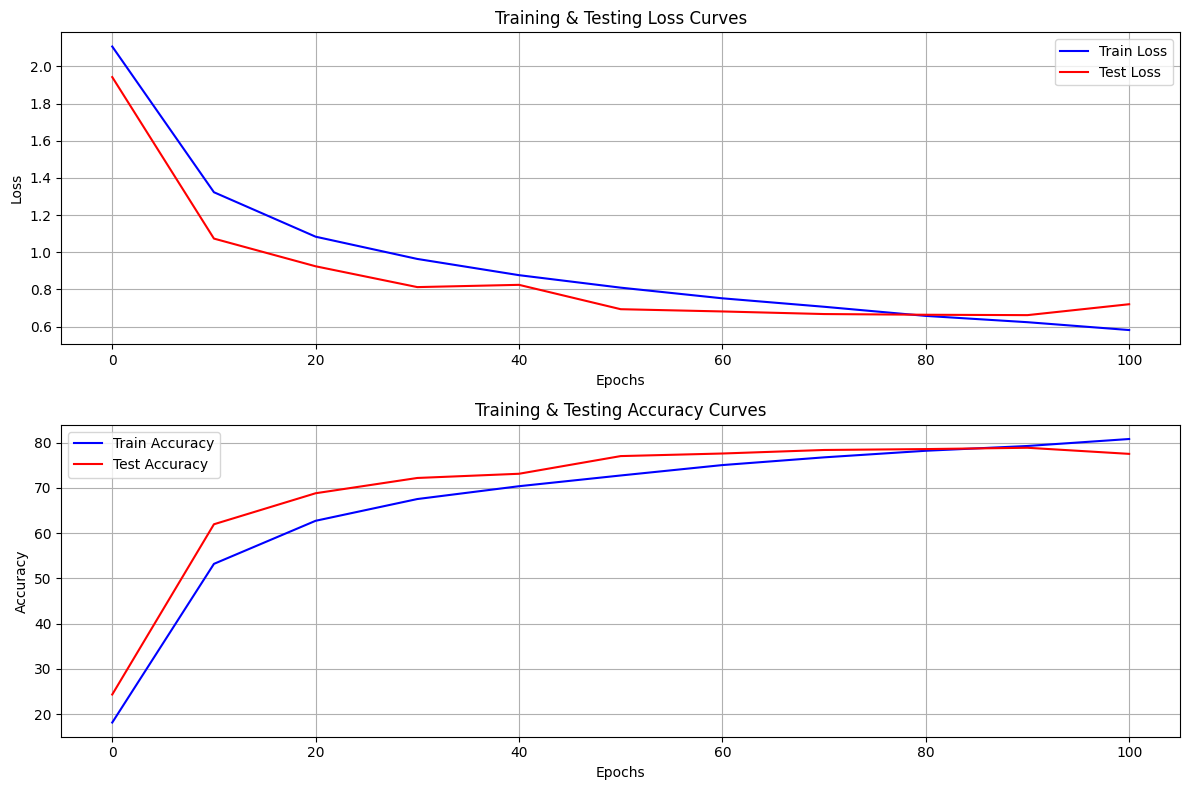

Model Saved Successfully


In [82]:
plot_loss_acc_curves(epoch_count, loss_values, test_loss_values, acc_values, test_acc_values)
save_model(model=model_comb_2, save_name='model_comb.pth')

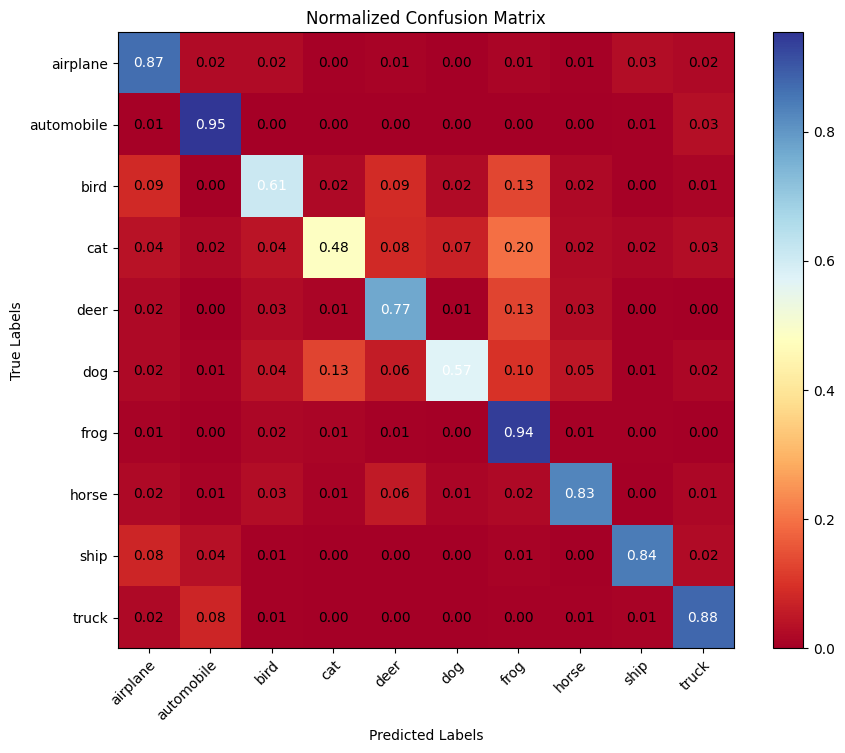

In [83]:
y_predictions = predict(model_comb_2, test_dataloader)
confusion_matrix(label_names, y_predictions, y_test_tensor)

Παρατηρούμε, πως τα ποσοστά ακρίβειας και στον συνδυασμό των μοντέλων αλλά και στο συνελικτικό που υλοποιήσαμε προηγουμένως είναι παρόμοια, πράγμα που σημαίνει πως δεν είχαμε κάποια ουσιαστική βελτίωση στην κατηγοριοποίηση των δεδομένων μας. Ωστόσο, παρατηρώντας τον confussion matrix βλέπουμε πως ο συνδυασμός των μοντέλων απέδωσε ελαφρώς χειρότερα στην κλάση στην οποία δυσκολευόταν να κατηγοροποιήσει προηγουμένως και το συνελικτικό δίκτυο. Συνεπώς, καταλήγουμε και εδώ στο συμπέρασμα πως για να πετύχουμε μεγαλύτερα ποσοστά ακρίβειας, θα ήταν προτιμότερο να εισάγουμε ένα ακόμα block από convolutional layers παρά να πάρουμε τον συνδυασμό του **MLP** που υλοποιήσαμε προηγουμένως με το **CNN** .

## **K-Fold Cross-Validation**

To **K-Fold Cross-Validation** είναι μια τεχνική για να εκτιμήσουμε το πόσο καλά μπορεί να γενικεύσει το μοντέλο μας. Ουσιαστικά, υπολογίζει την απόδοση του μοντέλου μας σε πολλαπλά train-test splits μειώνοντας έτσι την πιθανότητα να έχουμε ένα μοντέλο με πολύ καλά αποτελέσματα στο test sample λόγω του split που έγινε. Επίσης, μας βοηθάει να αποφύγουμε το πρόβλημα της υπερ-προσαρμογής καθώς μας δίνει μια πιο εύρωστη εκτίμηση της απόδοσης του μοντέλου μας αφού το δοκιμάζουμε σε διαφορετικά validation samples ενώ επίσης άμα αποδίδει καλά σε όλα τα folds τότε είναι λιγότερο πιθανό να έχουμε overfitting. Συνεπώς, τα οφέλη που προσφέρει το **K-Fold Cross Validation** είναι πολλά με κυριότερο και βασικότερο το γεγονός ότι μας δίνει πληροφορία για το πόσο εύρωστο και αξιόπιστο είναι το μοντέλο μας.

Παρακάτω, φαίνεται η υλοποίση της μεθόδου που περιγράψαμε προηγουμένως την οποία πραγματοποιούμε για 10 folds και από αυτά κρατάμε το καλύτερο μοντέλο που βρέθηκε για να το χρησιμοποίησουμε για να σχεδιάσουμε το confusion matrix. Τέλος, τυπώνω την μέση τιμή και την τυπική απόκλιση του μοντέλου μου καθώς αυτό μας βοηθάει να δούμε άμα θα το επιλέξουμε ή όχι για να πραγματοποιήσουμε την κατηγοριοποίηση των εικόνων στις κατάλληλες κλάσεις. Ιδανικά για να μπορέσουμε να πούμε ότι το μοντέλο μας είναι πολύ καλό θα θέλαμε μεγάλη μέση τιμή(καθότι μας δείχνει την μέση απόδοση του μοντέλου μας σε όλα τα folds) και μικρή τυπική απόκλιση πράγμα που δείχνει ότι το μοντέλο μας είναι αρκετά εύρωστο και μπορεί να κάνει σωστό classification οποιοδήποτε και αν είναι το validation sample. Αυτό σίγουρα μας εξασφαλίζει το generalization του μοντέλου μας.

In [39]:
from sklearn.model_selection import KFold
train_dataset = TensorDataset(train_images_permuted, y_train_tensor)
test_dataset  = TensorDataset(test_images_permuted, y_test_tensor)
dataset = ConcatDataset([train_dataset, test_dataset])

kf = KFold(n_splits=10, shuffle=True)
MODEL_PATH = Path("my_models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)
MODEL_NAME = "best_model.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
BATCH_SIZE = 32
epochs = 31
best_acc = 0.0
best_model_state = None
fold_accuracies = []

start = time.time()

for fold, (train_index, test_index) in enumerate(kf.split(dataset)):

    print(f'FOLD : {fold+1}')
    print("--------------------------------------")
    train_samples = SubsetRandomSampler(train_index)
    test_samples  = SubsetRandomSampler(test_index)

    trainloader = DataLoader(dataset,
    batch_size=BATCH_SIZE,
    sampler=train_samples)

    testloader = DataLoader(dataset,
    batch_size=BATCH_SIZE,
    sampler=test_samples)

    model_kfold = ConvolutionCIFARV4().to(device)

    loss_fn, optimizer, scheduler = loss_optimizer(model=model_kfold)

    for epoch in range(0, epochs):
        train_loss, train_acc = training(model=model_kfold, train_dataloader=trainloader, loss_fn=loss_fn, optimizer=optimizer)
        test_loss, test_acc   = testing(model=model_kfold, test_dataloader=testloader, loss_fn=loss_fn)

        if epoch % 5 == 0:
            print(f"Epoch {epoch} | Loss : {train_loss:.5f} | Accuracy : {train_acc:.2f}% | Test Loss : {test_loss:.5f} | Test Accuracy : {test_acc:.2f}%")
            
    fold_accuracies.append(test_acc)
    if test_acc > best_acc:
        best_acc = test_acc
        best_model_state = model_kfold.state_dict()
        print(f'New Model Found with best accuracy : {best_acc:.2f}%')

mean_acc = sum(fold_accuracies) / len(fold_accuracies)
std_acc  = ((sum((x-mean_acc) ** 2 for x in fold_accuracies)) / (len(fold_accuracies) - 1) ) ** 0.5

torch.save(obj=best_model_state, f=MODEL_SAVE_PATH)
print(f'Best model saved with accuracy : {best_acc:.2f}%')
print(f"Cross Validation Accuracy : {mean_acc:.3f}% ± {std_acc:.3f}%")
end = time.time()
print(f'Total Duration : {end-start}')

FOLD : 1
--------------------------------------
Epoch 0 | Loss : 1.73842 | Accuracy : 35.52% | Test Loss : 1.47406 | Test Accuracy : 47.26%
Epoch 5 | Loss : 1.01879 | Accuracy : 64.11% | Test Loss : 0.89620 | Test Accuracy : 68.52%
Epoch 10 | Loss : 0.83174 | Accuracy : 71.02% | Test Loss : 0.77225 | Test Accuracy : 72.97%
Epoch 15 | Loss : 0.73022 | Accuracy : 74.53% | Test Loss : 0.68541 | Test Accuracy : 75.57%
Epoch 20 | Loss : 0.66176 | Accuracy : 77.15% | Test Loss : 0.64953 | Test Accuracy : 77.44%
Epoch 25 | Loss : 0.60949 | Accuracy : 78.75% | Test Loss : 0.57753 | Test Accuracy : 79.82%
Epoch 30 | Loss : 0.56698 | Accuracy : 80.14% | Test Loss : 0.56890 | Test Accuracy : 80.44%
New Model Found with best accuracy : 80.44%
FOLD : 2
--------------------------------------
Epoch 0 | Loss : 1.73397 | Accuracy : 36.17% | Test Loss : 1.40453 | Test Accuracy : 49.95%
Epoch 5 | Loss : 1.01178 | Accuracy : 64.27% | Test Loss : 0.90660 | Test Accuracy : 67.54%
Epoch 10 | Loss : 0.83411 |

In [42]:
model_kfold = ConvolutionCIFARV4().to(device)
model_kfold = load_model(model_kfold, MODEL_SAVE_PATH)

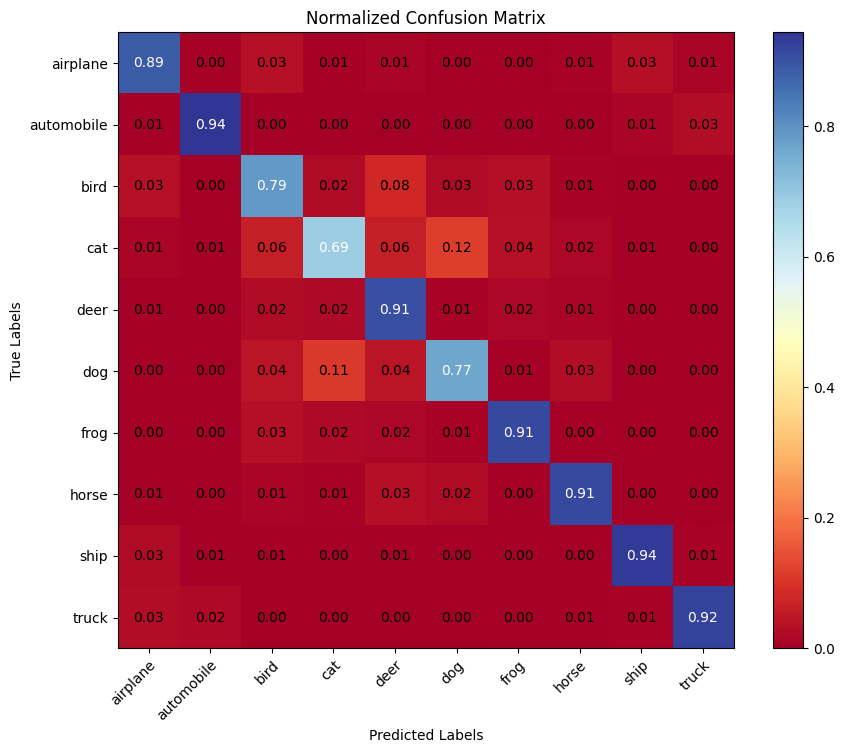

In [43]:
y_predictions = predict(model_kfold, test_dataloader)
confusion_matrix(label_names, y_predictions, y_test_tensor)

Όπως βλέπουμε το συγκεκριμένο μοντέλο αποδίδει πολύ καλά και είναι αρκετά εύρωστο αφού η τυπική του απόκλιση είναι πολύ μικρή. Συνεπώς είμαστε σίγουροι πως είναι κατάλληλο για την ορθή κατηγοριοποίση των εικόνων της CIFAR-10 διότι πετυχαίνει κατά μέσο όρο ~80% ακρίβεια. Φυσικά, για να αξιολογήσουμε όλα τα μοντέλα που έχουμε φτιάξει θα έπρεπε να εφαρμόσουμε αυτή την τεχνική παντού. Ωστόσο, αυτό είναι αρκετά χρονοβόρο ειδικά για την CIFAR-10 που έχει ήδη πολλά training και test samples. Καταλαβαίνουμε λοιπόν πως αυτή η τεχνική ίσως θα ήταν πιο κατάλληλη σε ένα μικρότερο σύνολο δεδομένων για την εκτίμηση της απόδοσης του μοντέλου μας.

## **Τελικά Συμπεράσματα**

Από όλη την ανάλυση που προηγήθηκε μπορούμε να συμπεράνουμε πως τα μοντέλα που αναπτύξαμε στην παρούσα εργασία αποδίδουν στην πλειονότητα τους αρκετά καλύτερα στην κατηγοριοποίηση των εικόνων της CIFAR-10 σε αντίθεση με τους αλγορίθμους πλησιέστερου γείτονα και πλησιέστερου κέντρου. Επομένως, μπορούμε να πούμε με βεβαιότητα πως για ένα πρόβλημα κατηγοριοποίσης όπως αυτό της CIFAR-10 θα επιλέγαμε σίγουρα ένα νευρωνικό δίκτυο αντί για τους αλγορίθμους της ενδιάμεσης εργασίας καθότι έχει την δυνατότητα να μαθαίνει καλύτερα τα ιδιαίτερα χαρακτηριστικά της εκάστοτε κλάσης.